In [1]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import torch
import copy
import argparse
import numpy as np
import json
import scipy
from torch_geometric.data import Data
from torch_sparse import SparseTensor
from tqdm import tqdm
from transformers import AutoModelForCausalLM, LlamaTokenizer, AdamW, get_linear_schedule_with_warmup,AutoTokenizer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, LoraModel, PeftConfig, PeftModel
import os
import pickle
from transformers.modeling_outputs import CausalLMOutputWithPast
from torch.nn import CrossEntropyLoss
import json
import random
import torch.nn as nn
import torch.nn.functional as F
from torch import einsum
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import pickle
from proj import FP_arxiv, FP_deezer_europe, FP_roman_empire, FP_amazon_ratings, FP_questions,Edge_roman_empire
import random
import matplotlib.pyplot as plt
import re

/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA SETUP: Loading binary /root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [34]:
# pubmed
import numpy as np

# 原始数据
data = [[4710, 4709], [4166, 4166], [4691, 4690], [4032, 4033], [4678, 4678], [3770, 3771], [4677, 4676], [3669, 3675]]

# # 翻转数据顺序
data = data[::-1]

# 计算并生成 LaTeX 格式的输出
latex_entries = []
for pair in data:
    arr = np.array(pair)
    mean_value = np.mean(arr / 5666*100) 
    std_value = np.std(arr / 5666*100)
    
    # Format the output to match the specified LaTeX format
    latex_entry = f"{mean_value:.2f}$\pm${std_value:.2f} &"
    latex_entries.append(latex_entry)

# Combine all entries into a single line for easy copying into your document
latex_row = ' '.join(latex_entries).strip('&')

# Print the final LaTeX row
print(latex_row)

64.81$\pm$0.05 & 82.54$\pm$0.01 & 66.55$\pm$0.01 & 82.56$\pm$0.00 & 71.17$\pm$0.01 & 82.78$\pm$0.01 & 73.53$\pm$0.00 & 83.12$\pm$0.01 


In [ ]:
[[1779, 1770], [1838, 1846], [1996, 2022], [2386, 2367], [2161, 2148], [2594, 2581], [2172, 2235], [2708, 2655]]

In [ ]:
5666    roman_empire

In [ ]:
3944 pubmed

In [ ]:
6123  amazon

In [15]:
arr=np.array([2762, 2730, 2747, 2749])

In [20]:
    mean_value = np.mean(arr / 6123) 
    std_value = np.std(arr / 6123)
    
    # Format the output to match the specified LaTeX format
    latex_entry = f"{mean_value:.4f}$\pm${std_value:.3f} &"
    latex_entries.append(latex_entry)

In [21]:
# Combine all entries into a single line for easy copying into your document
latex_row = ' '.join(latex_entries).strip('&')

# Print the final LaTeX row
print(latex_row)

83.75$\pm$0.00 & 83.85$\pm$0.00 & 83.24$\pm$0.00 & 83.82$\pm$0.00 & 83.67$\pm$0.25 & 53.89$\pm$0.16 & 44.86$\pm$0.19 & 44.86$\pm$0.19 & 0.45$\pm$0.00 & 0.4486$\pm$0.002 


# 查看多少链接关系

In [ ]:
file_path = f'./amazon_ratings/amazon_ratings.npz'
data = np.load(file_path)

# 切分索引
train_indices = np.where(data['train_masks'][0])[0]
val_indices = np.where(data['val_masks'][0])[0]
test_indices = np.where(data['test_masks'][0])[0]


# data = np.load('./roman_empire/roman_empire.npz')
adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
data.adj_t = data.adj_t.to_symmetric()

In [ ]:
file_path = f'./amazon_ratings/amazon_ratings.npz'
data = np.load(file_path)

In [ ]:
# 反转每一行
reversed_edges = data['edges'][:, ::-1]

# 拼接原始数据与反转后的数据
a= np.concatenate((data['edges'], reversed_edges), axis=0)

In [ ]:
# 使用 numpy.unique 获取唯一值及计数
unique_values, counts = np.unique(data['node_labels'], return_counts=True)

# 输出结果
print("Unique values:", unique_values)
print("Counts:", counts)

In [ ]:
connection_counts = {}

# 遍历矩阵中的每一行
for row in a:
    # 更新连接数
    for node in row:
        if node in connection_counts:
            connection_counts[node] += 1
        else:
            connection_counts[node] = 1


In [ ]:
connection_counts

In [ ]:
# 将字典的值转换成数组
values = np.array(list(connection_counts.values()))

# 计算中位数
median_connections = np.median(values)

In [ ]:
average_connections = sum(connection_counts.values()) / len(connection_counts)

In [ ]:
average_connections

In [ ]:
print(median_connections)

# Run(# Section 1  将所有token分成几类进行查看它们的注意力分布，发现不同类完全不一致。用来对比训练前后对比情况。)

In [6]:
def get_total_grad_norm(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_first_and_second_order_neighbors(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    return neighbors_dict

def random_get_first_and_second_order_neighbors_I(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 在完成邻居获取后，尝试添加扰动
        if len(first_order_neighbors) > 1:
            # 随机选择两个一阶邻居
            selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
            
            # 交换它们的二阶邻居列表
            first_order_neighbors[selected_neighbors[0]], first_order_neighbors[selected_neighbors[1]] = \
                first_order_neighbors[selected_neighbors[1]].copy(), first_order_neighbors[selected_neighbors[0]].copy()
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_II(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        iter_num=0
        while iter_num<=10:
            if len(first_order_neighbors) > 1:
                # 随机选择两个一阶邻居
                selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
                # 为这两个邻居随机选择一些二阶邻居进行交换
                swap_size = min(len(first_order_neighbors[selected_neighbors[0]]), len(first_order_neighbors[selected_neighbors[1]]))
                if swap_size > 0:
                    swap_indices = random.sample(range(swap_size), swap_size)
                    for idx in swap_indices:
                        first_order_neighbors[selected_neighbors[0]][idx], first_order_neighbors[selected_neighbors[1]][idx] = \
                            first_order_neighbors[selected_neighbors[1]][idx], first_order_neighbors[selected_neighbors[0]][idx]
            iter_num+=1
        
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_III(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    all_nodes = list(id_mapping.values())
    
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将所有的一阶和二阶节点收集到一个列表中
        all_neighbors = list(first_order_neighbors.keys()) + [neighbor for sublist in first_order_neighbors.values() for neighbor in sublist]
        
        print(first_order_neighbors)
        
        # 打乱所有节点
        np.random.shuffle(all_neighbors)
        
        # 重新分配一阶和二阶节点
        new_first_order_neighbors = all_neighbors[:len(first_order_neighbors)]
        new_second_order_neighbors = all_neighbors[len(first_order_neighbors):]
        
        # 构建新的邻居字典
        new_neighbors_dict = {node: [] for node in new_first_order_neighbors}
        
        for i, node in enumerate(new_first_order_neighbors):
            new_neighbors_dict[node] = new_second_order_neighbors[i * len(first_order_neighbors):(i + 1) * len(first_order_neighbors)]
        
        neighbors_dict[node_id.item()] = new_neighbors_dict
    
    return neighbors_dict


def get_all_neighbors(data, input_ids):
    # 获取所有输入节点的一阶和二阶邻居
    all_neighbors = {}
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        all_neighbors[node_id.item()] = first_order_neighbors
    
    return all_neighbors

def random_get_first_and_second_order_neighbors_IV(data, input_ids):
    all_neighbors = get_all_neighbors(data, input_ids)  # 获取整个 batch 的邻居信息
    neighbors_dict = {}

    for center_node_id in input_ids:
        temp_neighbors = copy.deepcopy(all_neighbors[center_node_id.item()])
        other_center_nodes = set(input_ids) - {center_node_id}
        
        # 收集其他中心节点的所有一阶和二阶邻居作为不相关节点池
        unrelated_nodes_pool = []
        for other_node_id in other_center_nodes:
            unrelated_nodes_pool.extend(list(all_neighbors[other_node_id.item()].keys()))
            for second_order_neighbors in all_neighbors[other_node_id.item()].values():
                unrelated_nodes_pool.extend(second_order_neighbors)
        
        # 确保不相关节点池中的节点不在当前中心节点的邻居列表中
        unrelated_nodes_pool = list(set(unrelated_nodes_pool) - set(temp_neighbors.keys()) - set([node for sublist in temp_neighbors.values() for node in sublist]))
        
        iter_num=0
        while iter_num<=10:
            if unrelated_nodes_pool:  # 如果存在不相关节点，则进行替换
                # 随机选择一定数量的不相关节点
                num_unrelated_to_replace = min(len(unrelated_nodes_pool), len(temp_neighbors)) // 2  # 可根据需要调整比例

                unrelated_nodes_sample = random.sample(unrelated_nodes_pool, num_unrelated_to_replace)

                # 对于每一个选中的不相关节点，随机决定是替换一阶还是二阶邻居
                for unrelated_node in unrelated_nodes_sample:
                    if random.choice([True, False]):  # 替换一阶邻居
                        replaced_node = random.choice(list(temp_neighbors.keys()))
                        temp_neighbors[unrelated_node] = temp_neighbors.pop(replaced_node)
                    else:  # 替换二阶邻居
                        if temp_neighbors:
                            first_order_node, second_order_neighbors = random.choice(list(temp_neighbors.items()))
                            if second_order_neighbors:
                                replaced_node = random.choice(second_order_neighbors)
                                second_order_neighbors.remove(replaced_node)
                                second_order_neighbors.append(unrelated_node)
            iter_num+=1
        neighbors_dict[center_node_id.item()] = temp_neighbors
    
    return neighbors_dict

In [7]:
def pre_data(args):
    if args.dataset=='ogbn-arxiv':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
        data=dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
        split_idx = dataset.get_idx_split()
        train_loader = NeighborLoader(data, input_nodes=split_idx["train"],
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      ,batch_size=args.batch_size, 
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["valid"],
                                      batch_size=args.batch_size,
                                         num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      , shuffle=False,num_workers=args.num_workers)
        test_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["test"],
                                     batch_size=args.batch_size,
                                    num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                     , shuffle=False,num_workers=args.num_workers)
        
    if args.dataset=='deezer-europe':
        deezer = scipy.io.loadmat(f'./deezer_europe/deezer-europe.mat')
        adj_t= SparseTensor(row=torch.tensor(deezer['A'].tocoo().row).to(torch.long), col=torch.tensor(deezer['A'].tocoo().col).to(torch.long),sparse_sizes=(len(deezer['label'][0]), len(deezer['label'][0])))
        data= Data(x=torch.tensor(deezer['features'].toarray()).to(torch.float32), adj_t=adj_t,y=torch.tensor(deezer['label']).squeeze())
        data.adj_t = data.adj_t.to_symmetric()
        # 获取节点总数
        num_nodes = len(data.y)
        # 定义数据集划分比例
        train_ratio = 0.5
        val_ratio = 0.25
        test_ratio = 0.25
        # 计算每种数据集包含的节点数
        num_train = int(num_nodes * train_ratio)
        num_val = int(num_nodes * val_ratio)
        num_test = num_nodes - num_train - num_val
        # 随机排列节点索引
        node_indices = torch.randperm(num_nodes)
        # 切分索引
        train_indices = node_indices[:num_train]
        val_indices = node_indices[num_train:num_train + num_val]
        test_indices = node_indices[num_train + num_val:]

        train_loader = NeighborLoader(data, input_nodes=train_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=True,num_workers=args.num_workers)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)    
    if args.dataset in ['roman_empire','amazon_ratings','questions']:
        file_path = f'./{args.dataset}/{args.dataset}_right.npz'
        data = np.load(file_path)
        
        # 切分索引
        train_indices = np.where(data['train_masks'][0])[0]
        val_indices = np.where(data['val_masks'][0])[0]
        test_indices = np.where(data['test_masks'][0])[0]
        
        
        # data = np.load('./roman_empire/roman_empire.npz')
        adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
        data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
        data.adj_t = data.adj_t.to_symmetric()


        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
    if args.dataset in ['pubmed']:
        file_path = f'./{args.dataset}/data.pt'
        data = torch.load(file_path)
        
        data.adj_t = data.adj_t.to_symmetric()
        
        data.y=torch.tensor(data.y)
        
        node_id = np.arange(data.num_nodes)
        np.random.shuffle(node_id)

        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
            
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
    if args.dataset in ['wikics']:
        file_path = f'./{args.dataset}/data_token_right_10.pt'
        
        data = torch.load(file_path)
        
        node_id = np.arange(data.num_nodes)
        
        
        random.shuffle(node_id)
        
        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
        
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)

    
    return train_loader,valid_loader,test_loader,data

In [8]:
def get_args():
    parser = argparse.ArgumentParser(description="PyTorch PYG implementation")
    parser.add_argument('--seed', type=int, default=42, help='random seed')

    # CPU/GPU
    parser.add_argument("--num_workers", default=6, type=int)
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('--device', default='cuda:0')
    
    """LLM Config"""
    parser.add_argument('--backbone', type=str, default='./llama2-7b-hf')
    parser.add_argument('--tokenizer', type=str, default='AutoTokenizer')
    parser.add_argument('--max_text_length', type=int, default=4096)
    parser.add_argument('--lora_r', type=int, default=64)
    parser.add_argument('--lora_alpha', type=int, default=128)
    parser.add_argument('--lora_dropout', type=int, default=0.05)

    
    """LLM Training"""
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--warmup_ratio', type=float, default=0.05)
    parser.add_argument('--weight_decay', type=float, default=0.005)
    parser.add_argument('--clip_grad_norm', type=float, default=1.0)
    parser.add_argument('--gradient_accumulation_steps', type=int, default=8)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--adam_eps', type=float, default=1e-8)
    parser.add_argument('--adam_beta1', type=float, default=0.9)
    parser.add_argument('--adam_beta2', type=float, default=0.999)
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.5)
    parser.add_argument(
        "--num_neighbors",
        type=str,
        default="8,8",
        help="Number of samples for each layer in SAGE. Length = num_layers",
    )
    parser.add_argument(
        "--perturbation",
        type=int,
        default=0,
        help="perturbation type",
    )
    """Dataset"""
    parser.add_argument('--do_lower_case', action='store_true')
    parser.add_argument("--dataset", type=str, default="amazon_ratings", help="Dataset")
    parser.add_argument("--data_path", type=str, default="./data", help="Path to data")
    parser.add_argument("--num_nodes", type=int, default="24492", help="the number of nodes")

    """Global """
    parser.add_argument("--train", type=bool, default="True", help="training ")
    parser.add_argument("--test", type=bool, default="False", help="testing ")
    args = parser.parse_args(args=[])

    
    return args

In [9]:
class Trainer():
    def __init__(self,args):
        self.args=args
        if args.dataset=='wikics':
            template={}
            template['train']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        if args.dataset=='roman_empire':
            template={}
            template['train']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>: {}"
            template['test']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>:"
        if args.dataset=='amazon_ratings':
            template={}
            template['train']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>: {}"
            template['test']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>:"
        if args.dataset=='pubmed':
            template={}
            template['train']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        
        self.template=template
        
        self.tokenizer = self.get_tokenizer()
        self.train_loader, self.valid_loader, self.test_loader,self.data=pre_data(self.args)
        
#         self.model= self.get_model()
        
#         self.optimizer, self.lr_scheduler=self.get_optimizer()
        
    def get_tokenizer(self):
        tokenizer = LlamaTokenizer.from_pretrained(self.args.backbone, max_length=self.args.max_text_length,do_lower_case=self.args.do_lower_case)
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.unk_token
        
        new_tokens=[ 'node_'+str(i) for i in range(self.args.num_nodes)]
        
        tokenizer.add_tokens(new_tokens)
        
        return tokenizer
    def get_optimizer(self):
        
        batch_per_epoch = len(self.train_loader)
        t_total = batch_per_epoch // self.args.gradient_accumulation_steps * self.args.epoch
        warmup_ratio = self.args.warmup_ratio
        warmup_iters = int(t_total * warmup_ratio)
        
        print("Batch per epoch: %d" % batch_per_epoch)
        print("Total Iters: %d" % t_total)
        print('Warmup ratio:', warmup_ratio)
        print("Warm up Iters: %d" % warmup_iters)
        
        
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": self.args.weight_decay,
                    'lr': self.args.lr,
                },
                # 这个组包含了bias和LayerNorm的所有参数，不应用权重衰减
                {
                    "params":[p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": 0.0,
                    'lr': self.args.lr,
                }

        ]
        optim = AdamW(optimizer_grouped_parameters,
                          lr=self.args.lr, eps=self.args.adam_eps)
        lr_scheduler = get_linear_schedule_with_warmup(optim, warmup_iters, t_total)
        
        return optim, lr_scheduler
    
    def get_model(self):
        model = AutoModelForCausalLM.from_pretrained(
                                    self.args.backbone,
                                    load_in_8bit=True,
                                    torch_dtype=torch.float16,
                                    use_safetensors=False,
                                    device_map='cuda:0'
                                )
        
        # model_embed=model.model.embed_tokens.weight.data
        
        model.resize_token_embeddings(32000+self.args.num_nodes)
        
        model.model.embed_tokens.weight.data[-self.args.num_nodes:]=self.data.x
        
        model = prepare_model_for_kbit_training(model)
        
        lora_config = LoraConfig(
            r=self.args.lora_r,
            lora_alpha=self.args.lora_alpha,
            lora_dropout=self.args.lora_dropout,
            bias="none",
            task_type="CAUSAL_LM",
            # target_modules=['q_proj','k_proj']
            target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj']
            
        )
        
        model= get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        
        return model
    
    def get_prompt(self,batch,is_training=True):
        #将label又数字id形式转化为文字
        if self.args.dataset=='ogbn-arxiv':
            dict_labelid2categeory=load_pickle('dict_labelid2arxivcategeory.pkl')
        if self.args.dataset=='deezer-europe':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='female'
            dict_labelid2categeory[1]='male'
        if self.args.dataset=='roman_empire':
            dict_labelid2categeory={}
            
            dict_labelid2categeory = {1: 'prepositional object',2: 'preposition',3: 'determiner',4: 'adjectival',5: 
                                    'conjunct',6: 'nominal subject',7: 'coordinating conjunction',0: 'root',
                                    8: 'direct object',9: 'adverbial',10: 'compound',11: 'auxiliary',
                                    12: 'appositional',13: 'passive auxiliary',14: 'passive nominal subject',15:
                                    'possession',16: 'relative clause',17: 'other'}
            
        if self.args.dataset=='amazon_ratings':
            
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='Very Positive'
            dict_labelid2categeory[1]='Positive'
            dict_labelid2categeory[2]='Neutral'
            dict_labelid2categeory[3]='Negative'
            dict_labelid2categeory[4]='Very Negative'
            
        if self.args.dataset=='questions':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='activate'
            dict_labelid2categeory[1]='no'
        
        if self.args.dataset=='wikics':
            dict_labelid2categeory={
            0: 'Computational linguistics',
            1: 'Databases',
            2: 'Operating systems',
            3: 'Computer architecture',
            4: 'Computer security',
            5: 'Internet protocols',
            6: 'Computer file systems',
            7: 'Distributed computing architecture',
            8: 'Web technology',
            9: 'Programming language topics'}
        if self.args.dataset=='pubmed':
            dict_labelid2categeory={
            0: 'Diabetes Mellitus, Experimental',
            1: 'Diabetes Mellitus Type 1',
            2: 'Diabetes Mellitus Type 2'}
        if self.args.perturbation==0:
            neighbors_dict=get_first_and_second_order_neighbors(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==1:
            neighbors_dict=random_get_first_and_second_order_neighbors_I(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==2:
            neighbors_dict=random_get_first_and_second_order_neighbors_II(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==3:
            neighbors_dict=random_get_first_and_second_order_neighbors_III(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==4:
            neighbors_dict=random_get_first_and_second_order_neighbors_IV(batch,batch.n_id[:batch.batch_size])
            
            
        batch_text=[]
        labels=[]
        for i,label in zip(neighbors_dict.keys(),batch.y[:batch.batch_size]):
            label=dict_labelid2categeory[label.item()]
            connect_text='['
            text=''
            for j in neighbors_dict[i].keys():
                connect_text+='node_'+str(j) + ' is connected [' + ','.join('node_'+str(item) for item in neighbors_dict[i][j]) + ' ] ,'
            connect_text=connect_text[:-1]+']'
            if is_training :
                text = self.template['train'].format('node_'+str(i),connect_text,'node_'+str(i),label)+'</s>'
            else:
                text = self.template['test'].format('node_'+str(i),connect_text,'node_'+str(i))
            batch_text.append(text)
            labels.append(label+'</s>')
        input_ids=self.tokenizer(batch_text,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        attention_mask=self.tokenizer(batch_text,padding='longest',
                                      max_length=self.args.max_text_length,return_tensors="pt")['attention_mask']
        
        #去掉开头的字符
        label_ids=self.tokenizer(labels,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        
        
        
        if is_training:
            
            label_ids[label_ids.eq(self.tokenizer.pad_token_id)]=-100
            label_ids[:,-1]=2
            label_ids[label_ids.eq(1)]=-100
            label_ids=torch.cat((torch.full((label_ids.size(0), input_ids.size(-1)-label_ids.size(-1)), -100),
                              label_ids),dim=-1)
        else:
            # 测试阶段可能不需要生成标签
            label_ids = labels
        
        return input_ids, attention_mask, label_ids,neighbors_dict
    def load_checkpoint(self, ckpt_path,proj_path):
        results = self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
        results = self.proj_model.load_state_dict(torch.load(proj_path), strict=True)
        if self.verbose:
            print('Model loaded from ', ckpt_path)
            print('Model loaded from ', proj_path)
            print(results)
    def train(self):
        
        self.model.train()
        
        pbar = tqdm(total=len(self.train_loader), ncols=275)
        for epoch in range(self.args.epoch):
            
            for step_i, batch in enumerate(self.train_loader):
                
                input_ids, attention_mask, labels, neighbors_dict=self.get_prompt(batch,True)
                
                attention_mask=attention_mask.to(self.args.device)
                
                labels=labels.to(self.args.device)
                
                input_ids=input_ids.to(self.args.device)
                
                output= self.model(
                    input_ids=input_ids,
                    labels=labels,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True)
                
                loss = output['loss']/ self.args.gradient_accumulation_steps
                
                
                loss.backward()
                
                
                if step_i % self.args.gradient_accumulation_steps == 0:
                    # 在训练循环中调用
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.clip_grad_norm)
                    
                    self.optimizer.step()  # Update
                    self.lr_scheduler.step()
                    for param in self.model.parameters():
                        param.grad = None
                if step_i % 1 == 0:
                    lr = self.lr_scheduler.get_lr()[0]
                    desc_str = f'Epoch {epoch} | LR {lr:.6f} |'
                    desc_str += f' Loss:{loss:.3f}'
                    pbar.set_description(desc_str)
                    pbar.update(1)
        pbar.close()
            
        torch.save(self.model.state_dict(),"llmcom_{}_end_{}.pth".format(self.args.epoch,self.args.dataset))
                                         
    def test(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            acc_list=[]
            for time in range(4):
                with torch.no_grad():
                    print('len of val_loader is {}'.format(len(self.test_loader)))
                    acc=0
                    for step_i, batch in tqdm(enumerate(self.test_loader)):

                        input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                        attention_mask=attention_mask.to(self.args.device)

                        input_ids=input_ids.to(self.args.device)

                        embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                        output= self.model.generate(inputs_embeds=embeds,
                                                    attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                        output=self.tokenizer.batch_decode(output)
                        # print(output)
                        print(labels)
                        for i in range(len(output)):
                            if labels[i] in output[i]:
                               acc+=1
                        print(acc)
                    acc_list.append(acc)
            print(acc_list)
    def test_perturbation(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            
            acc_list_perbation=[]
            for perturbation in range(1,5):
                print('test_perturbation is {}'.format(perturbation))
                self.args.perturbation=perturbation
                acc_list=[]
                for time in range(4):
                    with torch.no_grad():
                        print('len of val_loader is {}'.format(len(self.test_loader)))
                        acc=0
                        for step_i, batch in tqdm(enumerate(self.test_loader)):

                            input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                            attention_mask=attention_mask.to(self.args.device)

                            input_ids=input_ids.to(self.args.device)

                            embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                            output= self.model.generate(inputs_embeds=embeds,
                                                        attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                            output=self.tokenizer.batch_decode(output)
                            # print(output)
                            print(labels)
                            for i in range(len(output)):
                                if labels[i] in output[i]:
                                   acc+=1
                            print(acc)
                        acc_list.append(acc)
                print(acc_list)
                acc_list_perbation.append(acc_list)
            print(acc_list_perbation)    

In [83]:
def set_random_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置一个固定的随机种子值
seed_value = 42
set_random_seed(seed_value)

In [84]:
args=get_args()

In [85]:
trainer=Trainer(args)

In [9]:
trainer.model.load_state_dict(torch.load("llmcom_1_end_{}.pth".format(trainer.args.dataset)), strict=True)  

<All keys matched successfully>

In [10]:
trainer.args.dataset

'amazon_ratings'

In [86]:
def calculate_column_averages(tensor):
    # 获取张量的形状
    n, m = tensor.shape
    
    # 初始化一个列表来存储每列的平均值
    column_averages = []
    
    # 按列迭代
    for col_idx in range(m):
        # 提取当前列
        current_column = tensor[:, col_idx]
        
        # 过滤非零值
        non_zero_values = current_column[current_column != 0]
        
        # 计算非零值的平均值
        if len(non_zero_values) > 0:
            avg_value = torch.mean(non_zero_values)
        else:
            avg_value = torch.tensor(0.0)  # 如果没有非零值，则返回0作为平均值
        
        # 添加到结果列表
        column_averages.append(avg_value.item())
    
    return torch.tensor(column_averages)

In [10]:
batch=next(iter(trainer.test_loader))

In [11]:
input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
attention_mask = attention_mask.to(trainer.args.device)
input_ids = input_ids.to(trainer.args.device)
output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
import os
import torch
from tqdm import tqdm

# 确保atten_roman文件夹存在
if not os.path.exists("atten_{}".format(trainer.args.dataset)):
    os.makedirs("atten_{}".format(trainer.args.dataset))

def generate_avg_attn(trainer):
    with torch.no_grad():
        for step_i, batch in enumerate(tqdm(trainer.test_loader, desc="Processing batches")):
            input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
            attention_mask = attention_mask.to(trainer.args.device)
            input_ids = input_ids.to(trainer.args.device)
            output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            
            # 计算平均注意力权重
            all_attn = torch.stack([output.attentions[i].mean(dim=1) for i in range(32)]).transpose(0, 1).to(torch.float16)
            
            column_averages_node=[]
            column_averages_text=[]
            for batch_id in range(all_attn.shape[0]):
                for head_id in range(all_attn.shape[1]):
                    column_averages=calculate_column_averages(all_attn[batch_id,head_id])

                    column_averages_node.extend(column_averages[input_ids.cpu()[batch_id]>=trainer.tokenizer.vocab_size])
                    column_averages_text.extend(column_averages[input_ids.cpu()[batch_id]<trainer.tokenizer.vocab_size])
            # column_averages_node=torch.stack(column_averages_node)
            # column_averages_text=torch.stack(column_averages_text)
            
#             # 假设 avg_attn 和 input_ids 是已定义的张量
#             mask = (input_ids == 0)[0]

#             # 创建一个全零张量，形状与 mask 相同
#             indices = torch.nonzero(mask, as_tuple=True)[0]
#             for i in indices:
#                 all_attn[:,:,i,indices]=0
            
            yield column_averages_node,column_averages_text

# 初始化一个空列表来存储注意力权重
atten_node = []
atten_text=[]
# 遍历生成器并每处理100个batch保存一次atten
batch_counter = 0
for batch_averages_node,batch_averages_text in generate_avg_attn(trainer):
    atten_node.extend(batch_averages_node)
    atten_text.extend(batch_averages_text)
    batch_counter += 1
    
    # 每100个batch保存一次atten
    if batch_counter % 100 == 0:
        # 将atten列表转换为张量并保存到atten_roman文件夹
        save_path = os.path.join("atten_{}".format(trainer.args.dataset), f'atten_node_{batch_counter // 100}.pth')
        torch.save(torch.tensor(atten_node), save_path)
        
        save_path = os.path.join("atten_{}".format(trainer.args.dataset), f'atten_text_{batch_counter // 100}.pth')
        torch.save(torch.tensor(atten_text), save_path)
        
        # 清空atten列表以备下一轮使用
        atten_node.clear()
        atten_text.clear()

# 如果剩余不足100个batch的数据，则在最后也保存一下
if len(atten) > 0:
        # 将atten列表转换为张量并保存到atten_roman文件夹
        save_path = os.path.join("atten_{}".format(trainer.args.dataset), f'atten_node_finial.pth')
        torch.save(torch.stack(atten_node), save_path)
        
        save_path = os.path.join("atten_{}".format(trainer.args.dataset), f'atten_text_finial.pth')
        torch.save(torch.stack(atten_text), save_path)
        
        # 清空atten列表以备下一轮使用
        atten_node.clear()
        atten_text.clear()
    

Processing batches:   2%|▏         | 102/6123 [05:41<5:21:43,  3.21s/it]

In [10]:
# 定义一个函数来读取所有存储的注意力权重文件
def load_attention_weights(directory):
    # 获取目录中的所有.pth文件
    node_files = [f for f in os.listdir(directory) if f.endswith('.pth') and f.startswith('atten_node')]
    
    text_files = [f for f in os.listdir(directory) if f.endswith('.pth') and f.startswith('atten_text')]
    
    # 加载所有.pth文件中的注意力权重
    atten_node = []
    for file_name in node_files:
        file_path = os.path.join(directory, file_name)
        loaded_data = torch.load(file_path)
        atten_node.extend(loaded_data)
    
    atten_text = []
    for file_name in text_files:
        file_path = os.path.join(directory, file_name)
        loaded_data = torch.load(file_path)
        atten_text.extend(loaded_data)
    
    return atten_node,atten_text

In [89]:
# trained_atten_node, trained_atten_text= load_attention_weights("trained_atten_{}".format(trainer.args.dataset))

# atten_node, atten_text= load_attention_weights("atten_{}".format(trainer.args.dataset))
# trained_atten_node_logs = np.log10(trained_atten_node)
# trained_atten_text_logs = np.log10(trained_atten_text)

# atten_node_logs = np.log10(atten_node)
# atten_text_logs = np.log10(atten_text)

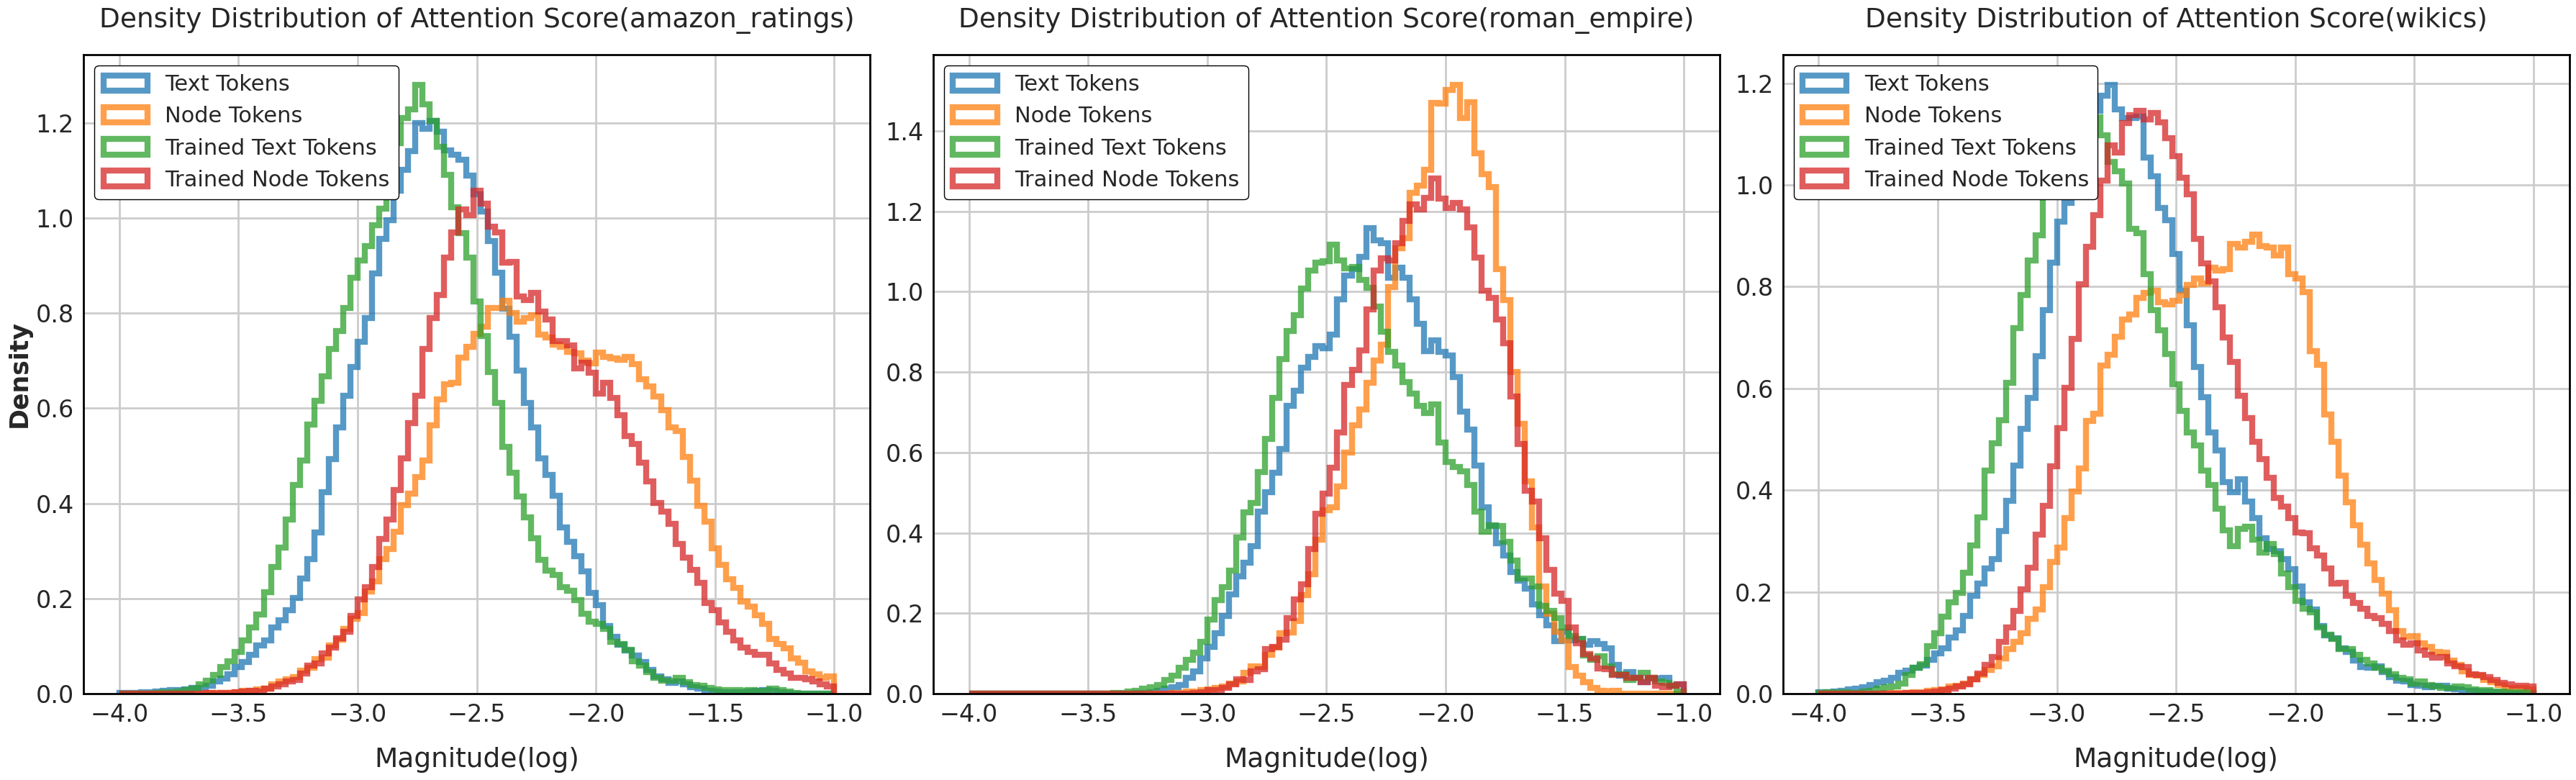

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 使用seaborn来美化图形

# 设置Seaborn样式
sns.set(style="whitegrid")

# 定义bins
bins = np.linspace(-4, -1, 100)

# 使用不同的颜色方案和透明度，以及边框颜色来提高区分度
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 更具对比度的颜色
alphas = [0.75, 0.75, 0.75, 0.75]  # 透明度

# 创建一个新的图形对象，使用1行3列布局以容纳三个子图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 11))  # 调整图形大小以提供更大空间

datasets = ['amazon_ratings', 'roman_empire', 'wikics']

for ax, dataset in zip(axes, datasets):
    trained_atten_node, trained_atten_text = load_attention_weights("trained_atten_{}".format(dataset))
    atten_node, atten_text = load_attention_weights("atten_{}".format(dataset))
    
    trained_atten_node_logs = np.log10(trained_atten_node)
    trained_atten_text_logs = np.log10(trained_atten_text)
    atten_node_logs = np.log10(atten_node)
    atten_text_logs = np.log10(atten_text)

    # 绘制直方图，使用'step'类型以创建无填充的线条直方图
    for data, color, alpha, label in zip(
            [atten_text_logs, atten_node_logs, trained_atten_text_logs, trained_atten_node_logs],
            colors, alphas,
            ['Text Tokens', 'Node Tokens', 'Trained Text Tokens', 'Trained Node Tokens']):
        ax.hist(data, bins=bins, density=True, histtype='step', linewidth=6,
                edgecolor=color, alpha=alpha, label=label)

    # 添加x轴标签，并设置字体大小和加粗
    ax.set_xlabel('Magnitude(log)', fontsize=27,labelpad=20)

    # 添加标题，并设置字体大小和加粗
    ax.set_title('Density Distribution of Attention Score({})'.format(dataset), pad=27, fontsize=27)

    # 设置边框线宽及颜色为黑色
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
        
    # 添加图例，并添加背景区域
    # ax.legend(loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', fontsize=20)
    
    # 添加图例，并添加背景区域
    legend = ax.legend(loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', fontsize=22)

    # 加粗图例中的文本
    # for text in legend.get_texts():
    #     text.set_weight('bold')
        
    # # 添加图例，并添加背景区域，同时设置字体为加粗
    # ax.legend(loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black',
    #       fontsize=20, fontweight='bold')  # 加粗图例中的文本

    # 增加x轴和y轴刻度字体大小
    ax.tick_params(axis='both', which='major', labelsize=24)  # 设置主刻度标签大小
    # ax.tick_params(axis='both', which='minor', labelsize=15)  # 如果有次刻度，设置次刻度标签大小

    
    # 添加网格线，但使它们更轻淡
    ax.grid(True, which='both', linestyle='-', linewidth=2, alpha=1)

# 仅在第一个子图中显示y轴标签，因为所有的子图共享相同的y轴信息
axes[0].set_ylabel('Density', fontsize=25, fontweight='bold')

# 调整布局，确保元素不会重叠
plt.tight_layout()

# # 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = "attention_score_density_distribution.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')


# 指定要保存的文件名和路径，这里我们使用PNG格式并设置高DPI以保证高清
# output_filename_png = "attention_score_density_distribution.png"
# plt.savefig(output_filename_png, format='png', dpi=300, bbox_inches='tight')


# 显示图表
plt.show()

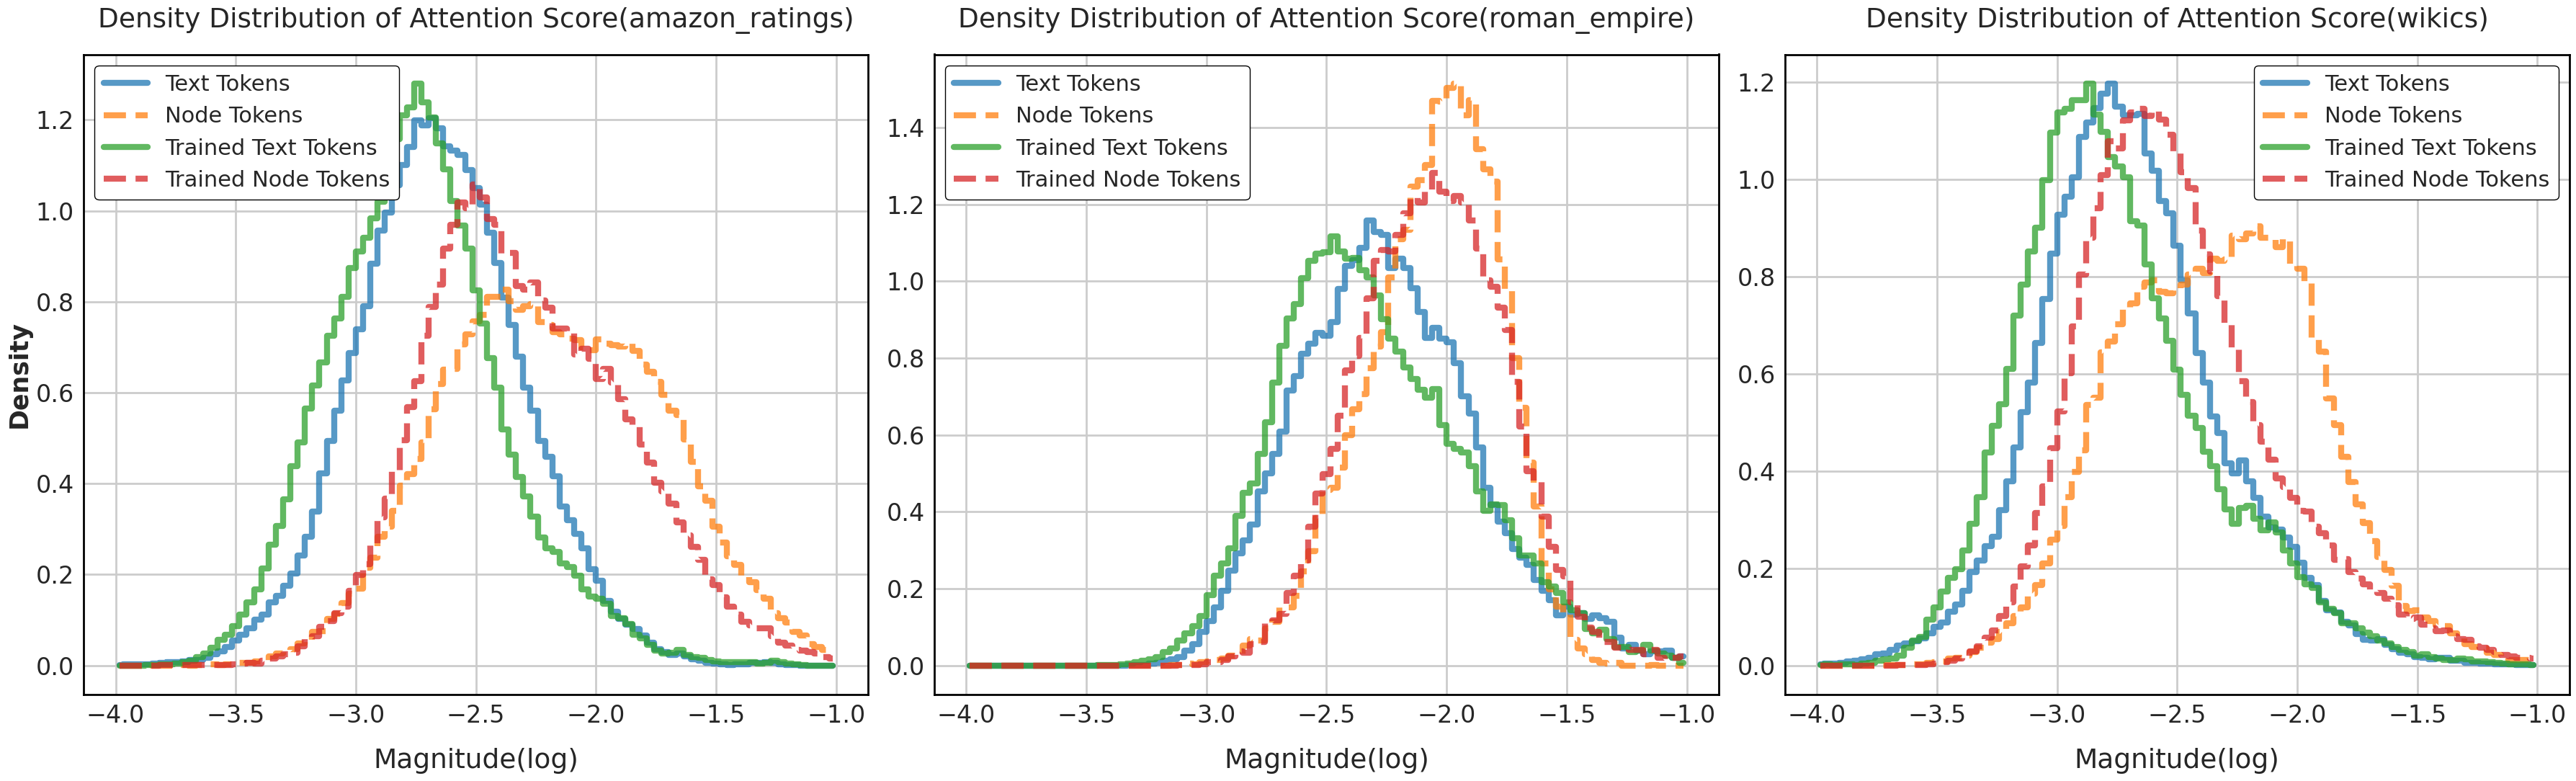

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 使用seaborn来美化图形

# 设置Seaborn样式
sns.set(style="whitegrid")

# 定义bins
bins = np.linspace(-4, -1, 100)

# 使用不同的颜色方案和透明度，以及边框颜色来提高区分度
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # 更具对比度的颜色
alphas = [0.75, 0.75, 0.75, 0.75]  # 透明度
line_styles = ['-', '--', '-', '--']  # 不同的线型

# 创建一个新的图形对象，使用1行3列布局以容纳三个子图
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 11))  # 调整图形大小以提供更大空间

datasets = ['amazon_ratings', 'roman_empire', 'wikics']

for ax, dataset in zip(axes, datasets):
    trained_atten_node, trained_atten_text = load_attention_weights("trained_atten_{}".format(dataset))
    atten_node, atten_text = load_attention_weights("atten_{}".format(dataset))
    
    trained_atten_node_logs = np.log10(trained_atten_node)
    trained_atten_text_logs = np.log10(trained_atten_text)
    atten_node_logs = np.log10(atten_node)
    atten_text_logs = np.log10(atten_text)

    # 绘制直方图，使用'step'类型以创建无填充的线条直方图，并为每条线指定不同的线型
    for data, color, alpha, linestyle, label in zip(
            [atten_text_logs, atten_node_logs, trained_atten_text_logs, trained_atten_node_logs],
            colors, alphas, line_styles,  # 确保 line_styles 包含的是线型字符串列表
            ['Text Tokens', 'Node Tokens', 'Trained Text Tokens', 'Trained Node Tokens']):
        counts, edges = np.histogram(data, bins=bins, density=True)
        centers = 0.5 * (edges[1:] + edges[:-1])
        ax.plot(centers, counts, drawstyle='steps-mid', linewidth=6, color=color, alpha=alpha, linestyle=linestyle, label=label)  # 正确设置 linestyle 和 label

    # 添加x轴标签，并设置字体大小和加粗
    ax.set_xlabel('Magnitude(log)', fontsize=27, labelpad=20)

    # 添加标题，并设置字体大小和加粗
    ax.set_title('Density Distribution of Attention Score({})'.format(dataset), pad=27, fontsize=27)

    # 设置边框线宽及颜色为黑色
    for spine in ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    if dataset=='wikics':
        # 添加图例，并添加背景区域
        legend = ax.legend(loc='upper right', frameon=True, framealpha=1, facecolor='white', edgecolor='black', fontsize=22)
    else:
        # 添加图例，并添加背景区域
        legend = ax.legend(loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', fontsize=22)

    # 增加x轴和y轴刻度字体大小
    ax.tick_params(axis='both', which='major', labelsize=24)  # 设置主刻度标签大小
    
    # 添加网格线，但使它们更轻淡
    ax.grid(True, which='both', linestyle='-', linewidth=2, alpha=1)

# 仅在第一个子图中显示y轴标签，因为所有的子图共享相同的y轴信息
axes[0].set_ylabel('Density', fontsize=25, fontweight='bold')

# 调整布局，确保元素不会重叠
plt.tight_layout()

# 指定要保存的文件名和路径，这里我们使用PDF格式
output_filename = "attention_score_density_distribution.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

# 显示图表
plt.show()

In [10]:
import numpy as np
from scipy import stats
from scipy.stats import entropy
from numpy.linalg import norm
import matplotlib.pyplot as plt

# 定义辅助函数来进行KS检验并打印结果
def perform_ks_test(data1, data2, label1, label2):
    stat, p_value = stats.ks_2samp(data1, data2)
    print(f"KS Test between {label1} and {label2}:")
    print(f"Statistics={stat:.3f}, p-value={p_value:.3f}")
    
    alpha = 0.05  # 显著性水平
    if p_value > alpha:
        print('相同分布 (fail to reject H0)')
    else:
        print('不同分布 (reject H0)')
    print()

# 定义辅助函数来进行双样本t检验并打印结果
def perform_t_test(data1, data2, label1, label2, equal_var=True):
    stat, p_value = stats.ttest_ind(data1, data2, equal_var=equal_var)
    test_type = 'Equal Variance' if equal_var else 'Unequal Variance'
    print(f"{test_type} T-Test between {label1} and {label2}:")
    print(f"Statistics={stat:.3f}, p-value={p_value:.3f}")
    
    alpha = 0.05  # 显著性水平
    if p_value > alpha:
        print('无法拒绝原假设：均值相同 (fail to reject H0)')
    else:
        print('拒绝原假设：均值不同 (reject H0)')
    print()

# 定义函数来计算JS散度
def js_divergence(p, q):
    p = p / norm(p, ord=1)
    q = q / norm(q, ord=1)
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m)
    kl_qm = entropy(q, m)
    js = 0.5 * (kl_pm + kl_qm)
    return js

# 将数据转换为概率分布
def data_to_prob_dist(data, bins=100, range=(-3, -1)):
    counts, _ = np.histogram(data, bins=bins, range=range)
    prob_dist = counts / counts.sum()
    return prob_dist

# 定义主函数进行数据分析
def analyze_dataset(dataset_name):
    # 加载数据
    trained_atten_node, trained_atten_text = load_attention_weights("trained_atten_{}".format(dataset_name))
    atten_node, atten_text = load_attention_weights("atten_{}".format(dataset_name))

    # 计算log10
    trained_atten_node_logs = np.log10(trained_atten_node)
    trained_atten_text_logs = np.log10(trained_atten_text)
    atten_node_logs = np.log10(atten_node)
    atten_text_logs = np.log10(atten_text)

    # 执行KS检验
    print(f"\nAnalysis for dataset: {dataset_name}")
    perform_ks_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens')
    perform_ks_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens')
    perform_ks_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens')
    perform_ks_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens')

    # 执行T检验（等方差）
    print("Performing t-tests assuming equal variances:")
    perform_t_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens')
    perform_t_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens')
    perform_t_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens')
    perform_t_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens')

    # 执行Welch's t-test（不等方差）
    print("Now performing Welch's t-tests (assuming unequal variances):")
    perform_t_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens', equal_var=False)
    perform_t_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens', equal_var=False)
    perform_t_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens', equal_var=False)
    perform_t_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens', equal_var=False)

    # 计算JS散度
    prob_atten_text = data_to_prob_dist(atten_text_logs)
    prob_trained_atten_text = data_to_prob_dist(trained_atten_text_logs)
    prob_atten_node = data_to_prob_dist(atten_node_logs)
    prob_trained_atten_node = data_to_prob_dist(trained_atten_node_logs)

    js_atten_text_vs_trained = js_divergence(prob_atten_text, prob_trained_atten_text)
    js_atten_node_vs_trained = js_divergence(prob_atten_node, prob_trained_atten_node)
    js_atten_text_vs_node = js_divergence(prob_atten_text, prob_atten_node)
    js_trained_atten_text_vs_node = js_divergence(prob_trained_atten_text, prob_trained_atten_node)

    # 输出JS散度结果
    print(f"JS Divergence between Text Tokens and Trained Text Tokens: {js_atten_text_vs_trained:.4f}")
    print(f"JS Divergence between Node Tokens and Trained Node Tokens: {js_atten_node_vs_trained:.4f}")
    print(f"JS Divergence between Text Tokens and Node Tokens: {js_atten_text_vs_node:.4f}")
    print(f"JS Divergence between Trained Text Tokens and Trained Node Tokens: {js_trained_atten_text_vs_node:.4f}")

# 数据集列表
datasets = ['amazon_ratings', 'roman_empire', 'wikics']

# 对每个数据集进行分析
for dataset in datasets:
    analyze_dataset(dataset)


Analysis for dataset: amazon_ratings
KS Test between Text Tokens and Trained Text Tokens:
Statistics=0.118, p-value=0.000
不同分布 (reject H0)

KS Test between Node Tokens and Trained Node Tokens:
Statistics=0.116, p-value=0.000
不同分布 (reject H0)

KS Test between Text Tokens and Node Tokens:
Statistics=0.428, p-value=0.000
不同分布 (reject H0)

KS Test between Trained Text Tokens and Trained Node Tokens:
Statistics=0.438, p-value=0.000
不同分布 (reject H0)

Performing t-tests assuming equal variances:
Equal Variance T-Test between Text Tokens and Trained Text Tokens:
Statistics=95.066, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Equal Variance T-Test between Node Tokens and Trained Node Tokens:
Statistics=69.334, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Equal Variance T-Test between Text Tokens and Node Tokens:
Statistics=-337.116, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Equal Variance T-Test between Trained Text Tokens and Trained Node Tokens:
Statistics=-318.054, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Now p

In [71]:
from scipy import stats

# 假设 atten_text_logs, atten_node_logs, trained_atten_text_logs, trained_atten_node_logs 已定义并包含数据

# 定义一个函数来进行KS检验并打印结果
def perform_ks_test(data1, data2, label1, label2):
    stat, p_value = stats.ks_2samp(data1, data2)
    print(f"KS Test between {label1} and {label2}:")
    print(f"Statistics={stat:.3f}, p-value={p_value:.3f}")
    
    alpha = 0.05  # 显著性水平
    if p_value > alpha:
        print('相同分布 (fail to reject H0)')
    else:
        print('不同分布 (reject H0)')
    print()

# 执行KS检验
perform_ks_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens')
perform_ks_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens')
perform_ks_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens')
perform_ks_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens')

KS Test between Text Tokens and Trained Text Tokens:
Statistics=0.092, p-value=0.000
不同分布 (reject H0)

KS Test between Node Tokens and Trained Node Tokens:
Statistics=0.049, p-value=0.000
不同分布 (reject H0)

KS Test between Text Tokens and Node Tokens:
Statistics=0.279, p-value=0.000
不同分布 (reject H0)

KS Test between Trained Text Tokens and Trained Node Tokens:
Statistics=0.316, p-value=0.000
不同分布 (reject H0)



In [72]:
from scipy import stats

# 定义一个函数来进行双样本t检验并打印结果
def perform_t_test(data1, data2, label1, label2, equal_var=True):
    # 执行t检验
    stat, p_value = stats.ttest_ind(data1, data2, equal_var=equal_var)
    
    print(f"{'Equal Variance ' if equal_var else 'Unequal Variance '}T-Test between {label1} and {label2}:")
    print(f"Statistics={stat:.3f}, p-value={p_value:.3f}")
    
    alpha = 0.05  # 显著性水平
    if p_value > alpha:
        print('无法拒绝原假设：均值相同 (fail to reject H0)')
    else:
        print('拒绝原假设：均值不同 (reject H0)')
    print()

# 执行t检验，首先假设等方差
perform_t_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens')
perform_t_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens')
perform_t_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens')
perform_t_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens')

# 然后不假设等方差（Welch's t-test）
print("Now performing Welch's t-tests (assuming unequal variances):")
perform_t_test(atten_text_logs, trained_atten_text_logs, 'Text Tokens', 'Trained Text Tokens', equal_var=False)
perform_t_test(atten_node_logs, trained_atten_node_logs, 'Node Tokens', 'Trained Node Tokens', equal_var=False)
perform_t_test(atten_text_logs, atten_node_logs, 'Text Tokens', 'Node Tokens', equal_var=False)
perform_t_test(trained_atten_text_logs, trained_atten_node_logs, 'Trained Text Tokens', 'Trained Node Tokens', equal_var=False)

Equal Variance T-Test between Text Tokens and Trained Text Tokens:
Statistics=44.061, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Equal Variance T-Test between Node Tokens and Trained Node Tokens:
Statistics=0.461, p-value=0.645
无法拒绝原假设：均值相同 (fail to reject H0)

Equal Variance T-Test between Text Tokens and Node Tokens:
Statistics=-60.455, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Equal Variance T-Test between Trained Text Tokens and Trained Node Tokens:
Statistics=-78.651, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Now performing Welch's t-tests (assuming unequal variances):
Unequal Variance T-Test between Text Tokens and Trained Text Tokens:
Statistics=44.061, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Unequal Variance T-Test between Node Tokens and Trained Node Tokens:
Statistics=0.461, p-value=0.645
无法拒绝原假设：均值相同 (fail to reject H0)

Unequal Variance T-Test between Text Tokens and Node Tokens:
Statistics=-88.788, p-value=0.000
拒绝原假设：均值不同 (reject H0)

Unequal Variance T-Test between Trained Text Tokens 

In [73]:
import numpy as np
from scipy.stats import entropy
from numpy.linalg import norm

def js_divergence(p, q):
    """
    计算两个离散概率分布之间的Jensen-Shannon散度。
    
    参数:
    p -- 第一个概率分布 (numpy array)
    q -- 第二个概率分布 (numpy array)

    返回:
    JS散度值 (float)
    """
    # 确保输入是概率分布（和为1）
    p = p / norm(p, ord=1)
    q = q / norm(q, ord=1)
    
    # 计算平均分布
    m = 0.5 * (p + q)
    
    # 计算KL散度
    kl_pm = entropy(p, m)
    kl_qm = entropy(q, m)
    
    # 计算JS散度
    js = 0.5 * (kl_pm + kl_qm)
    
    return js

# 假设atten_text_logs, atten_node_logs, trained_atten_text_logs, trained_atten_node_logs 已定义并包含数据

# 将原始数据转换为概率分布
def data_to_prob_dist(data, bins=100, range=(-3, -1)):
    """
    将数据转换为离散的概率分布。
    
    参数:
    data -- 数据样本 (list or numpy array)
    bins -- 直方图的bin数量
    range -- 直方图的范围
    
    返回:
    概率分布 (numpy array)
    """
    counts, _ = np.histogram(data, bins=bins, range=range)
    prob_dist = counts / counts.sum()
    return prob_dist

# 创建概率分布
prob_atten_text = data_to_prob_dist(atten_text_logs)
prob_trained_atten_text = data_to_prob_dist(trained_atten_text_logs)
prob_atten_node = data_to_prob_dist(atten_node_logs)
prob_trained_atten_node = data_to_prob_dist(trained_atten_node_logs)

# 计算JS散度
js_atten_text_vs_trained = js_divergence(prob_atten_text, prob_trained_atten_text)
js_atten_node_vs_trained = js_divergence(prob_atten_node, prob_trained_atten_node)
js_atten_text_vs_node = js_divergence(prob_atten_text, prob_atten_node)
js_trained_atten_text_vs_node = js_divergence(prob_trained_atten_text, prob_trained_atten_node)

# 输出结果
print(f"JS Divergence between Text Tokens and Trained Text Tokens: {js_atten_text_vs_trained:.4f}")
print(f"JS Divergence between Node Tokens and Trained Node Tokens: {js_atten_node_vs_trained:.4f}")
print(f"JS Divergence between Text Tokens and Node Tokens: {js_atten_text_vs_node:.4f}")
print(f"JS Divergence between Trained Text Tokens and Trained Node Tokens: {js_trained_atten_text_vs_node:.4f}")

JS Divergence between Text Tokens and Trained Text Tokens: 0.0064
JS Divergence between Node Tokens and Trained Node Tokens: 0.0099
JS Divergence between Text Tokens and Node Tokens: 0.0753
JS Divergence between Trained Text Tokens and Trained Node Tokens: 0.0791


In [ ]:
# trainer.train()

In [ ]:
# trainer.test()

# A.2

In [111]:
def get_total_grad_norm(parameters):
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_first_and_second_order_neighbors(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    return neighbors_dict

def random_get_first_and_second_order_neighbors_I(data, input_ids):
    # 将邻接矩阵转换为 SparseTensor，这里直接使用 data.adj_t，因为它已经是 SparseTensor 类型
    adj_matrix = data.adj_t
    
    # 创建一个从原始节点 ID 到新节点 ID 的映射
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    # 创建一个空字典来存储结果
    neighbors_dict = {}
    
    # 对于每一个输入节点
    for node_id in input_ids:
        # 将原始节点 ID 映射到新的节点 ID
        new_node_id = id_mapping[node_id.item()]
        
        # 获取该节点的所有邻居
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        
        # 获取一阶邻居的原始 ID
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        # 为每个一阶邻居获取二阶邻居
        for first_order_neighbor in first_order_neighbor_ids:
            # 获取该一阶邻居的所有邻居
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            
            # 过滤掉自己作为一阶邻居的情况
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            
            # 获取二阶邻居的原始 ID
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            
            # 添加二阶邻居到对应的一阶邻居下
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 在完成邻居获取后，尝试添加扰动
        if len(first_order_neighbors) > 1:
            # 随机选择两个一阶邻居
            selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
            
            # 交换它们的二阶邻居列表
            first_order_neighbors[selected_neighbors[0]], first_order_neighbors[selected_neighbors[1]] = \
                first_order_neighbors[selected_neighbors[1]].copy(), first_order_neighbors[selected_neighbors[0]].copy()
        
        # 将邻居列表添加到字典中
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_II(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        iter_num=0
        while iter_num<=10:
            if len(first_order_neighbors) > 1:
                # 随机选择两个一阶邻居
                selected_neighbors = random.sample(list(first_order_neighbors.keys()), 2)
                # 为这两个邻居随机选择一些二阶邻居进行交换
                swap_size = min(len(first_order_neighbors[selected_neighbors[0]]), len(first_order_neighbors[selected_neighbors[1]]))
                if swap_size > 0:
                    swap_indices = random.sample(range(swap_size), swap_size)
                    for idx in swap_indices:
                        first_order_neighbors[selected_neighbors[0]][idx], first_order_neighbors[selected_neighbors[1]][idx] = \
                            first_order_neighbors[selected_neighbors[1]][idx], first_order_neighbors[selected_neighbors[0]][idx]
            iter_num+=1
        
        neighbors_dict[node_id.item()] = first_order_neighbors
    
    return neighbors_dict

def random_get_first_and_second_order_neighbors_III(data, input_ids):
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    all_nodes = list(id_mapping.values())
    
    neighbors_dict = {}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        # 将所有的一阶和二阶节点收集到一个列表中
        all_neighbors = list(first_order_neighbors.keys()) + [neighbor for sublist in first_order_neighbors.values() for neighbor in sublist]
        
        print(first_order_neighbors)
        
        # 打乱所有节点
        np.random.shuffle(all_neighbors)
        
        # 重新分配一阶和二阶节点
        new_first_order_neighbors = all_neighbors[:len(first_order_neighbors)]
        new_second_order_neighbors = all_neighbors[len(first_order_neighbors):]
        
        # 构建新的邻居字典
        new_neighbors_dict = {node: [] for node in new_first_order_neighbors}
        
        for i, node in enumerate(new_first_order_neighbors):
            new_neighbors_dict[node] = new_second_order_neighbors[i * len(first_order_neighbors):(i + 1) * len(first_order_neighbors)]
        
        neighbors_dict[node_id.item()] = new_neighbors_dict
    
    return neighbors_dict


def get_all_neighbors(data, input_ids):
    # 获取所有输入节点的一阶和二阶邻居
    all_neighbors = {}
    adj_matrix = data.adj_t
    id_mapping = {old_id.item(): new_id for new_id, old_id in enumerate(data.n_id)}
    
    for node_id in input_ids:
        new_node_id = id_mapping[node_id.item()]
        first_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == new_node_id]
        first_order_neighbors = {data.n_id[i].item(): [] for i in first_order_neighbor_ids.tolist()}
        
        for first_order_neighbor in first_order_neighbor_ids:
            second_order_neighbor_ids = adj_matrix.storage.col()[adj_matrix.storage.row() == first_order_neighbor]
            second_order_neighbor_ids = second_order_neighbor_ids[second_order_neighbor_ids != new_node_id]
            second_order_neighbors = [data.n_id[i].item() for i in second_order_neighbor_ids.tolist()]
            first_order_neighbors[data.n_id[first_order_neighbor].item()].extend(second_order_neighbors)
        
        all_neighbors[node_id.item()] = first_order_neighbors
    
    return all_neighbors

def random_get_first_and_second_order_neighbors_IV(data, input_ids):
    all_neighbors = get_all_neighbors(data, input_ids)  # 获取整个 batch 的邻居信息
    neighbors_dict = {}

    for center_node_id in input_ids:
        temp_neighbors = copy.deepcopy(all_neighbors[center_node_id.item()])
        other_center_nodes = set(input_ids) - {center_node_id}
        
        # 收集其他中心节点的所有一阶和二阶邻居作为不相关节点池
        unrelated_nodes_pool = []
        for other_node_id in other_center_nodes:
            unrelated_nodes_pool.extend(list(all_neighbors[other_node_id.item()].keys()))
            for second_order_neighbors in all_neighbors[other_node_id.item()].values():
                unrelated_nodes_pool.extend(second_order_neighbors)
        
        # 确保不相关节点池中的节点不在当前中心节点的邻居列表中
        unrelated_nodes_pool = list(set(unrelated_nodes_pool) - set(temp_neighbors.keys()) - set([node for sublist in temp_neighbors.values() for node in sublist]))
        
        iter_num=0
        while iter_num<=10:
            if unrelated_nodes_pool:  # 如果存在不相关节点，则进行替换
                # 随机选择一定数量的不相关节点
                num_unrelated_to_replace = min(len(unrelated_nodes_pool), len(temp_neighbors)) // 2  # 可根据需要调整比例

                unrelated_nodes_sample = random.sample(unrelated_nodes_pool, num_unrelated_to_replace)

                # 对于每一个选中的不相关节点，随机决定是替换一阶还是二阶邻居
                for unrelated_node in unrelated_nodes_sample:
                    if random.choice([True, False]):  # 替换一阶邻居
                        replaced_node = random.choice(list(temp_neighbors.keys()))
                        temp_neighbors[unrelated_node] = temp_neighbors.pop(replaced_node)
                    else:  # 替换二阶邻居
                        if temp_neighbors:
                            first_order_node, second_order_neighbors = random.choice(list(temp_neighbors.items()))
                            if second_order_neighbors:
                                replaced_node = random.choice(second_order_neighbors)
                                second_order_neighbors.remove(replaced_node)
                                second_order_neighbors.append(unrelated_node)
            iter_num+=1
        neighbors_dict[center_node_id.item()] = temp_neighbors
    
    return neighbors_dict

In [4]:
def pre_data(args):
    if args.dataset=='ogbn-arxiv':
        dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=T.ToSparseTensor())
        data=dataset[0]
        data.adj_t = data.adj_t.to_symmetric()
        split_idx = dataset.get_idx_split()
        train_loader = NeighborLoader(data, input_nodes=split_idx["train"],
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      ,batch_size=args.batch_size, 
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["valid"],
                                      batch_size=args.batch_size,
                                         num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                      , shuffle=False,num_workers=args.num_workers)
        test_loader = NeighborLoader(copy.copy(data), input_nodes=split_idx["test"],
                                     batch_size=args.batch_size,
                                    num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")]
                                     , shuffle=False,num_workers=args.num_workers)
        
    if args.dataset=='deezer-europe':
        deezer = scipy.io.loadmat(f'./deezer_europe/deezer-europe.mat')
        adj_t= SparseTensor(row=torch.tensor(deezer['A'].tocoo().row).to(torch.long), col=torch.tensor(deezer['A'].tocoo().col).to(torch.long),sparse_sizes=(len(deezer['label'][0]), len(deezer['label'][0])))
        data= Data(x=torch.tensor(deezer['features'].toarray()).to(torch.float32), adj_t=adj_t,y=torch.tensor(deezer['label']).squeeze())
        data.adj_t = data.adj_t.to_symmetric()
        # 获取节点总数
        num_nodes = len(data.y)
        # 定义数据集划分比例
        train_ratio = 0.5
        val_ratio = 0.25
        test_ratio = 0.25
        # 计算每种数据集包含的节点数
        num_train = int(num_nodes * train_ratio)
        num_val = int(num_nodes * val_ratio)
        num_test = num_nodes - num_train - num_val
        # 随机排列节点索引
        node_indices = torch.randperm(num_nodes)
        # 切分索引
        train_indices = node_indices[:num_train]
        val_indices = node_indices[num_train:num_train + num_val]
        test_indices = node_indices[num_train + num_val:]

        train_loader = NeighborLoader(data, input_nodes=train_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=True,num_workers=args.num_workers)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)    
    if args.dataset in ['roman_empire','amazon_ratings','questions']:
        file_path = f'./{args.dataset}/{args.dataset}_right.npz'
        data = np.load(file_path)
        
        # 切分索引
        train_indices = np.where(data['train_masks'][0])[0]
        val_indices = np.where(data['val_masks'][0])[0]
        test_indices = np.where(data['test_masks'][0])[0]
        
        
        # data = np.load('./roman_empire/roman_empire.npz')
        adj_t= SparseTensor(row=torch.tensor(data['edges']).t()[0].to(torch.long), col=torch.tensor(data['edges']).t()[1].to(torch.long),sparse_sizes=(len(data['node_labels']),len(data['node_labels']) ))
        data= Data(x=torch.tensor(data['node_features']), adj_t=adj_t,y=torch.tensor(data['node_labels']))
        data.adj_t = data.adj_t.to_symmetric()


        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
    if args.dataset in ['pubmed']:
        file_path = f'./{args.dataset}/data.pt'
        data = torch.load(file_path)
        
        data.adj_t = data.adj_t.to_symmetric()
        
        data.y=torch.tensor(data.y)
        
        node_id = np.arange(data.num_nodes)
        np.random.shuffle(node_id)

        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
            
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
    if args.dataset in ['wikics']:
        file_path = f'./{args.dataset}/data_token_right_10.pt'
        
        data = torch.load(file_path)
        
        node_id = np.arange(data.num_nodes)
        
        
        random.shuffle(node_id)
        
        train_indices = np.sort(node_id[:int(data.num_nodes * 0.6)])
        val_indices = np.sort(
            node_id[int(data.num_nodes * 0.6):int(data.num_nodes * 0.8)])
        test_indices = np.sort(node_id[int(data.num_nodes * 0.8):])
        
        train_loader = NeighborLoader(data, input_nodes=train_indices,
                                       num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size,
                                      shuffle=True,num_workers=args.num_workers,
                                      pin_memory=True)
        
        valid_loader = NeighborLoader(copy.copy(data), input_nodes=val_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                                      batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)
        
        test_loader = NeighborLoader(copy.copy(data), input_nodes=test_indices,
        num_neighbors=[eval(num_neighbors) for num_neighbors in args.num_neighbors.split(",")], 
                batch_size=args.batch_size, shuffle=False,num_workers=args.num_workers)

    
    return train_loader,valid_loader,test_loader,data

In [5]:
def get_args():
    parser = argparse.ArgumentParser(description="PyTorch PYG implementation")
    parser.add_argument('--seed', type=int, default=42, help='random seed')

    # CPU/GPU
    parser.add_argument("--num_workers", default=6, type=int)
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('--device', default='cuda:0')
    
    """LLM Config"""
    parser.add_argument('--backbone', type=str, default='./llama2-7b-hf')
    parser.add_argument('--tokenizer', type=str, default='AutoTokenizer')
    parser.add_argument('--max_text_length', type=int, default=4096)
    parser.add_argument('--lora_r', type=int, default=64)
    parser.add_argument('--lora_alpha', type=int, default=128)
    parser.add_argument('--lora_dropout', type=int, default=0.05)

    
    """LLM Training"""
    parser.add_argument('--batch_size', type=int, default=1)
    parser.add_argument('--warmup_ratio', type=float, default=0.05)
    parser.add_argument('--weight_decay', type=float, default=0.005)
    parser.add_argument('--clip_grad_norm', type=float, default=1.0)
    parser.add_argument('--gradient_accumulation_steps', type=int, default=8)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--adam_eps', type=float, default=1e-8)
    parser.add_argument('--adam_beta1', type=float, default=0.9)
    parser.add_argument('--adam_beta2', type=float, default=0.999)
    parser.add_argument('--epoch', type=int, default=1)
    parser.add_argument('--dropout', type=float, default=0.5)
    parser.add_argument(
        "--num_neighbors",
        type=str,
        default="8,8",
        help="Number of samples for each layer in SAGE. Length = num_layers",
    )
    parser.add_argument(
        "--perturbation",
        type=int,
        default=0,
        help="perturbation type",
    )
    """Dataset"""
    parser.add_argument('--do_lower_case', action='store_true')
    parser.add_argument("--dataset", type=str, default="amazon_ratings", help="Dataset")
    parser.add_argument("--data_path", type=str, default="./data", help="Path to data")
    parser.add_argument("--num_nodes", type=int, default="24492", help="the number of nodes")

    """Global """
    parser.add_argument("--train", type=bool, default="True", help="training ")
    parser.add_argument("--test", type=bool, default="False", help="testing ")
    args = parser.parse_args(args=[])
    
    return args

In [6]:
class Trainer():
    def __init__(self,args):
        self.args=args
        if args.dataset=='wikics':
            template={}
            template['train']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        if args.dataset=='roman_empire':
            template={}
            template['train']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>: {}"
            template['test']="<User>: In an article, words that have dependency relationships (where one word depends on another) are connected, forming a dependency graph. Based on the connections between words, determine the syntactic role of each word. Given that a word {} that connect {}, what is the word {} syntactic role? <Assistant>:"
        if args.dataset=='amazon_ratings':
            template={}
            template['train']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>: {}"
            template['test']="<User>: In a product graph dataset, edges connect products that are frequently purchased together. Based on the connections between products (books, music CDs, DVDs, VHS tapes), predict the average rating given by reviewers for the products. Given that a product {} that connect {}, what is the product {} rating? <Assistant>:"
        if args.dataset=='pubmed':
            template={}
            template['train']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>: {}"
            template['test']="<User>: In medical paper dataset, papers that cite each other form a linkage relationship. Based on the linkage relationships among papers, the research directions of medical papers can be predicted. Given that a paper {} that connect {}, What is the category of the paper {}? <Assistant>:"
        
        self.template=template
        
        self.tokenizer = self.get_tokenizer()
        self.train_loader, self.valid_loader, self.test_loader,self.data=pre_data(self.args)
        
        self.model= self.get_model()
        
        self.optimizer, self.lr_scheduler=self.get_optimizer()
        
    def get_tokenizer(self):
        tokenizer = LlamaTokenizer.from_pretrained(self.args.backbone, max_length=self.args.max_text_length,do_lower_case=self.args.do_lower_case)
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.unk_token
        
        new_tokens=[ 'node_'+str(i) for i in range(self.args.num_nodes)]
        
        tokenizer.add_tokens(new_tokens)
        
        return tokenizer
    def get_optimizer(self):
        
        batch_per_epoch = len(self.train_loader)
        t_total = batch_per_epoch // self.args.gradient_accumulation_steps * self.args.epoch
        warmup_ratio = self.args.warmup_ratio
        warmup_iters = int(t_total * warmup_ratio)
        
        print("Batch per epoch: %d" % batch_per_epoch)
        print("Total Iters: %d" % t_total)
        print('Warmup ratio:', warmup_ratio)
        print("Warm up Iters: %d" % warmup_iters)
        
        
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
                {
                    "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": self.args.weight_decay,
                    'lr': self.args.lr,
                },
                # 这个组包含了bias和LayerNorm的所有参数，不应用权重衰减
                {
                    "params":[p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
                    "weight_decay": 0.0,
                    'lr': self.args.lr,
                }

        ]
        optim = AdamW(optimizer_grouped_parameters,
                          lr=self.args.lr, eps=self.args.adam_eps)
        lr_scheduler = get_linear_schedule_with_warmup(optim, warmup_iters, t_total)
        
        return optim, lr_scheduler
    
    def get_model(self):
        model = AutoModelForCausalLM.from_pretrained(
                                    self.args.backbone,
                                    load_in_8bit=True,
                                    torch_dtype=torch.float16,
                                    use_safetensors=False,
                                    device_map='cuda:0'
                                )
        
        # model_embed=model.model.embed_tokens.weight.data
        
        model.resize_token_embeddings(32000+self.args.num_nodes)
        
        model.model.embed_tokens.weight.data[-self.args.num_nodes:]=self.data.x
        
        model = prepare_model_for_kbit_training(model)
        
        lora_config = LoraConfig(
            r=self.args.lora_r,
            lora_alpha=self.args.lora_alpha,
            lora_dropout=self.args.lora_dropout,
            bias="none",
            task_type="CAUSAL_LM",
            # target_modules=['q_proj','k_proj']
            target_modules=['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj']
            
        )
        
        model= get_peft_model(model, lora_config)
        model.print_trainable_parameters()

        
        return model
    
    def get_prompt(self,batch,is_training=True):
        #将label又数字id形式转化为文字
        if self.args.dataset=='ogbn-arxiv':
            dict_labelid2categeory=load_pickle('dict_labelid2arxivcategeory.pkl')
        if self.args.dataset=='deezer-europe':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='female'
            dict_labelid2categeory[1]='male'
        if self.args.dataset=='roman_empire':
            dict_labelid2categeory={}
            
            dict_labelid2categeory = {1: 'prepositional object',2: 'preposition',3: 'determiner',4: 'adjectival',5: 
                                    'conjunct',6: 'nominal subject',7: 'coordinating conjunction',0: 'root',
                                    8: 'direct object',9: 'adverbial',10: 'compound',11: 'auxiliary',
                                    12: 'appositional',13: 'passive auxiliary',14: 'passive nominal subject',15:
                                    'possession',16: 'relative clause',17: 'other'}
            
        if self.args.dataset=='amazon_ratings':
            
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='Very Positive'
            dict_labelid2categeory[1]='Positive'
            dict_labelid2categeory[2]='Neutral'
            dict_labelid2categeory[3]='Negative'
            dict_labelid2categeory[4]='Very Negative'
            
        if self.args.dataset=='questions':
            dict_labelid2categeory={}
            dict_labelid2categeory[0]='activate'
            dict_labelid2categeory[1]='no'
        
        if self.args.dataset=='wikics':
            dict_labelid2categeory={
            0: 'Computational linguistics',
            1: 'Databases',
            2: 'Operating systems',
            3: 'Computer architecture',
            4: 'Computer security',
            5: 'Internet protocols',
            6: 'Computer file systems',
            7: 'Distributed computing architecture',
            8: 'Web technology',
            9: 'Programming language topics'}
        if self.args.dataset=='pubmed':
            dict_labelid2categeory={
            0: 'Diabetes Mellitus, Experimental',
            1: 'Diabetes Mellitus Type 1',
            2: 'Diabetes Mellitus Type 2'}
        if self.args.perturbation==0:
            neighbors_dict=get_first_and_second_order_neighbors(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==1:
            neighbors_dict=random_get_first_and_second_order_neighbors_I(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==2:
            neighbors_dict=random_get_first_and_second_order_neighbors_II(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==3:
            neighbors_dict=random_get_first_and_second_order_neighbors_III(batch,batch.n_id[:batch.batch_size])
        if self.args.perturbation==4:
            neighbors_dict=random_get_first_and_second_order_neighbors_IV(batch,batch.n_id[:batch.batch_size])
            
            
        batch_text=[]
        labels=[]
        for i,label in zip(neighbors_dict.keys(),batch.y[:batch.batch_size]):
            label=dict_labelid2categeory[label.item()]
            connect_text='['
            text=''
            for j in neighbors_dict[i].keys():
                connect_text+='node_'+str(j) + ' is connected [' + ','.join('node_'+str(item) for item in neighbors_dict[i][j]) + ' ] ,'
            connect_text=connect_text[:-1]+']'
            if is_training :
                text = self.template['train'].format('node_'+str(i),connect_text,'node_'+str(i),label)+'</s>'
            else:
                text = self.template['test'].format('node_'+str(i),connect_text,'node_'+str(i))
            batch_text.append(text)
            labels.append(label+'</s>')
        input_ids=self.tokenizer(batch_text,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        attention_mask=self.tokenizer(batch_text,padding='longest',
                                      max_length=self.args.max_text_length,return_tensors="pt")['attention_mask']
        
        #去掉开头的字符
        label_ids=self.tokenizer(labels,padding='longest',
                                 max_length=self.args.max_text_length,return_tensors="pt")['input_ids']
        
        
        
        if is_training:
            
            label_ids[label_ids.eq(self.tokenizer.pad_token_id)]=-100
            label_ids[:,-1]=2
            label_ids[label_ids.eq(1)]=-100
            label_ids=torch.cat((torch.full((label_ids.size(0), input_ids.size(-1)-label_ids.size(-1)), -100),
                              label_ids),dim=-1)
        else:
            # 测试阶段可能不需要生成标签
            label_ids = labels
        
        return input_ids, attention_mask, label_ids,neighbors_dict
    def load_checkpoint(self, ckpt_path,proj_path):
        results = self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
        results = self.proj_model.load_state_dict(torch.load(proj_path), strict=True)
        if self.verbose:
            print('Model loaded from ', ckpt_path)
            print('Model loaded from ', proj_path)
            print(results)
    def train(self):
        
        self.model.train()
        
        pbar = tqdm(total=len(self.train_loader), ncols=275)
        for epoch in range(self.args.epoch):
            
            for step_i, batch in enumerate(self.train_loader):
                
                input_ids, attention_mask, labels, neighbors_dict=self.get_prompt(batch,True)
                
                attention_mask=attention_mask.to(self.args.device)
                
                labels=labels.to(self.args.device)
                
                input_ids=input_ids.to(self.args.device)
                
                output= self.model(
                    input_ids=input_ids,
                    labels=labels,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    return_dict=True)
                
                loss = output['loss']/ self.args.gradient_accumulation_steps
                
                
                loss.backward()
                
                
                if step_i % self.args.gradient_accumulation_steps == 0:
                    # 在训练循环中调用
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.args.clip_grad_norm)
                    
                    self.optimizer.step()  # Update
                    self.lr_scheduler.step()
                    for param in self.model.parameters():
                        param.grad = None
                if step_i % 1 == 0:
                    lr = self.lr_scheduler.get_lr()[0]
                    desc_str = f'Epoch {epoch} | LR {lr:.6f} |'
                    desc_str += f' Loss:{loss:.3f}'
                    pbar.set_description(desc_str)
                    pbar.update(1)
        pbar.close()
            
        torch.save(self.model.state_dict(),"llmcom_{}_end_{}.pth".format(self.args.epoch,self.args.dataset))
                                         
    def test(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            acc_list=[]
            for time in range(4):
                with torch.no_grad():
                    print('len of val_loader is {}'.format(len(self.test_loader)))
                    acc=0
                    for step_i, batch in tqdm(enumerate(self.test_loader)):

                        input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                        attention_mask=attention_mask.to(self.args.device)

                        input_ids=input_ids.to(self.args.device)

                        embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                        output= self.model.generate(inputs_embeds=embeds,
                                                    attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                        output=self.tokenizer.batch_decode(output)
                        # print(output)
                        print(labels)
                        for i in range(len(output)):
                            if labels[i] in output[i]:
                               acc+=1
                        print(acc)
                    acc_list.append(acc)
            print(acc_list)
    def test_perturbation(self):
        for epoch in range(1):
            ckpt_path = "llmcom_1_end_{}.pth".format(self.args.dataset)

            self.model.load_state_dict(torch.load(ckpt_path), strict=True)  
            
            self.model.eval()
            
            acc_list_perbation=[]
            for perturbation in range(1,5):
                print('test_perturbation is {}'.format(perturbation))
                self.args.perturbation=perturbation
                acc_list=[]
                for time in range(4):
                    with torch.no_grad():
                        print('len of val_loader is {}'.format(len(self.test_loader)))
                        acc=0
                        for step_i, batch in tqdm(enumerate(self.test_loader)):

                            input_ids, attention_mask, labels,neighbors_dict=self.get_prompt(batch,False)

                            attention_mask=attention_mask.to(self.args.device)

                            input_ids=input_ids.to(self.args.device)

                            embeds=self.model.model.model.embed_tokens(input_ids).to(self.args.device)

                            output= self.model.generate(inputs_embeds=embeds,
                                                        attention_mask=attention_mask,max_new_tokens=20,num_beams=2)
                            output=self.tokenizer.batch_decode(output)
                            # print(output)
                            print(labels)
                            for i in range(len(output)):
                                if labels[i] in output[i]:
                                   acc+=1
                            print(acc)
                        acc_list.append(acc)
                print(acc_list)
                acc_list_perbation.append(acc_list)
            print(acc_list_perbation)    

In [7]:
def set_random_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# 设置一个固定的随机种子值
seed_value = 42
set_random_seed(seed_value)

In [8]:
args=get_args()

In [9]:
trainer=Trainer(args)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


trainable params: 159,907,840 || all params: 7,098,961,920 || trainable%: 2.2525524407940476
Batch per epoch: 12246
Total Iters: 1530
Warmup ratio: 0.05
Warm up Iters: 76


/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
trainer.model.load_state_dict(torch.load("llmcom_1_end_{}.pth".format(trainer.args.dataset)), strict=True) 

<All keys matched successfully>

In [9]:
def calculate_column_averages(tensor):
    # 获取张量的形状
    n, m = tensor.shape
    
    # 初始化一个列表来存储每列的平均值
    column_averages = []
    
    # 按列迭代
    for col_idx in range(m):
        # 提取当前列
        current_column = tensor[:, col_idx]
        
        # 过滤非零值
        non_zero_values = current_column[current_column != 0]
        
        # 计算非零值的平均值
        if len(non_zero_values) > 0:
            avg_value = torch.mean(non_zero_values)
        else:
            avg_value = torch.tensor(0.0)  # 如果没有非零值，则返回0作为平均值
        
        # 添加到结果列表
        column_averages.append(avg_value.item())
    
    return torch.tensor(column_averages)

In [12]:
batch=next(iter(trainer.test_loader))

In [12]:
input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
attention_mask = attention_mask.to(trainer.args.device)
input_ids = input_ids.to(trainer.args.device)
output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [12]:
import os
import torch
from tqdm import tqdm

def generate_avg_attn(trainer):
    with torch.no_grad():
        for step_i, batch in enumerate(tqdm(trainer.test_loader, desc="Processing batches")):
            input_ids, attention_mask, labels, neighbors_dict = trainer.get_prompt(batch, False)
            attention_mask = attention_mask.to(trainer.args.device)
            input_ids = input_ids.to(trainer.args.device)
            output = trainer.model(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            
            # 计算平均注意力权重
            all_attn = torch.stack([output.attentions[i].mean(dim=1) for i in range(32)]).transpose(0, 1).to(torch.float16)
            
            idx_src_list=[]
            idx_dist_list=[]
            for i in range(len(neighbors_dict)):
                nodes=torch.where(input_ids[0]>=32000)[0][:-1].tolist()
                idx_src=[]
                idx_dist=[]

                index=1
                i=list(neighbors_dict.keys())[i]
                for j in neighbors_dict[i]:

                    idx_src.append(nodes[index])
                    if len(neighbors_dict[i][j])!=0:
                        idx_dist.append(nodes[index+1:index+len(neighbors_dict[i][j])+1])
                    index+=len(neighbors_dict[i][j])+1
                # idx_dist.append(idx_src.copy())
                # idx_src.append(nodes[0])
            idx_src_list.extend(idx_src)
            idx_dist_list.extend(idx_dist)
            
            atten_node_position = [[] for _ in range(8)]

            for batch_id in range(all_attn.shape[0]):
                for i in range(len(idx_src_list)):
                    if len(idx_dist_list)>i:
                        atten_node=all_attn[batch_id,:,idx_dist_list[i],idx_src_list[i]]
                        for j in range(atten_node.shape[1]):
                            atten_node_position[j].extend(atten_node[:,j].view(-1).tolist())
            
            yield atten_node_position

In [12]:
import os
import pickle

def save_attention_weights(atten_node_all, batch_counter, dataset_name):
    folder_path = f"atten_position_{dataset_name}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_prefix = 'atten_' if batch_counter > 0 else 'atten_final_'
    save_path = os.path.join(folder_path, f'{file_prefix}{batch_counter // 100}.pkl')
    
    with open(save_path, 'wb') as f:
        pickle.dump(atten_node_all, f)

# 初始化一个空列表来存储注意力权重
atten_node_all = [[] for _ in range(8)]
batch_counter = 0

for atten_node_position in generate_avg_attn(trainer):
    atten_node_all = [a + b for a, b in zip(atten_node_all, atten_node_position)]
    batch_counter += 1

    if batch_counter % 100 == 0:
        save_attention_weights(atten_node_all, batch_counter, trainer.args.dataset)
        atten_node_all = [[] for _ in range(8)]

if any(atten_node_all):
    save_attention_weights(atten_node_all, batch_counter, trainer.args.dataset)

Processing batches:   0%|          | 0/2341 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Processing batches:  19%|█▉        | 441/2341 [01:37<07:01,  4.51it/s]


KeyboardInterrupt: 

In [2]:
import os
import pickle

def load_attention_weights_pickle(folder_path):
    atten_data = [[] for _ in range(8)]
    
    # 获取文件夹中所有的 .pkl 文件
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                
                atten_data = [a + b for a, b in zip(atten_data, data)]
    
    return atten_data

/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


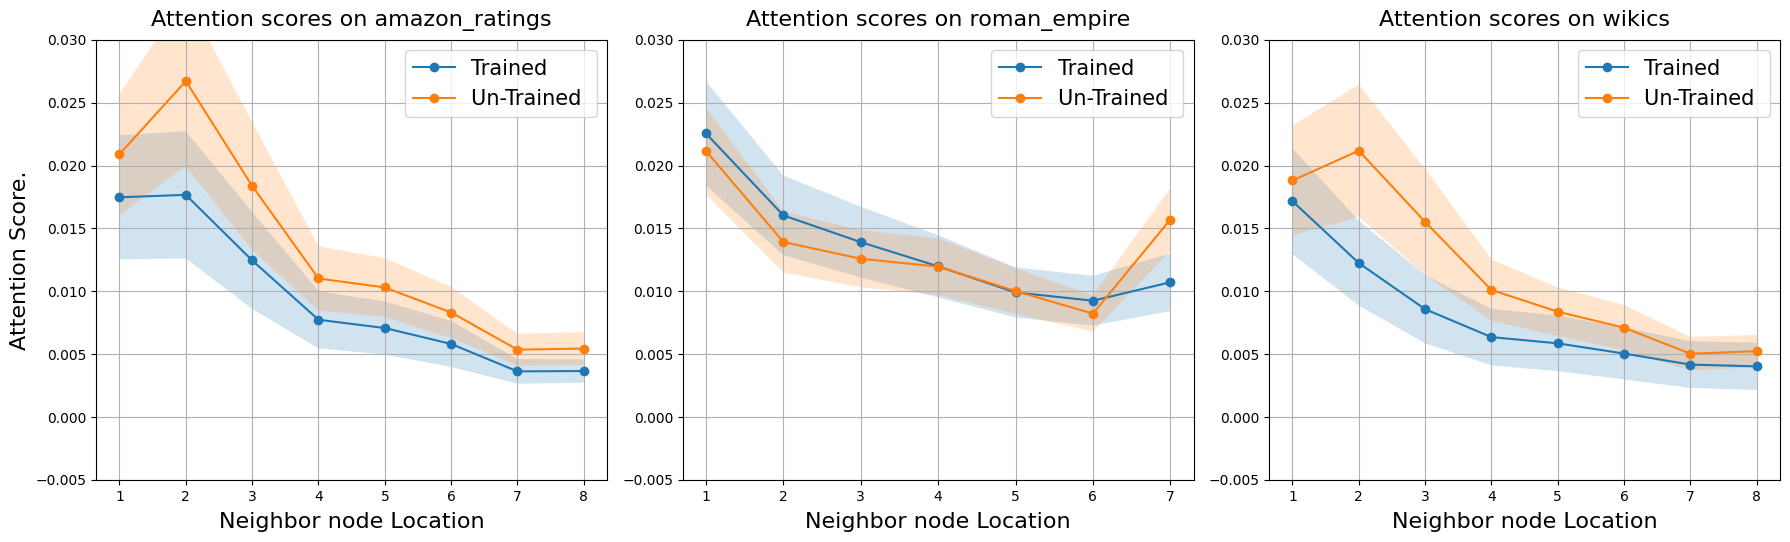

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 定义一个辅助函数来加载数据和计算均值标准差
def load_and_calculate_means_stds(dataset):
    trained_data = load_attention_weights_pickle(f"atten_position_{dataset}_raw")
    untrained_data = load_attention_weights_pickle(f"atten_position_{dataset}")

    num_clusters = list(range(1, len(trained_data) + 1))
    
    trained_means = [np.mean(data) for data in trained_data]
    trained_stds = [np.std(data)/5 for data in trained_data]

    untrained_means = [np.mean(data) for data in untrained_data]
    untrained_stds = [np.std(data)/5 for data in untrained_data]

    return num_clusters, trained_means, trained_stds, untrained_means, untrained_stds

# 创建一个1x3的子图布局
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

datasets = ['amazon_ratings', 'roman_empire', 'wikics']

for i, (ax, dataset) in enumerate(zip(axs, datasets)):
    # 加载数据并计算均值和标准差
    num_clusters, trained_means, trained_stds, untrained_means, untrained_stds = load_and_calculate_means_stds(dataset)

    # 绘制训练后的注意力分数
    ax.plot(num_clusters, trained_means, 'o-', label='Trained')
    ax.fill_between(num_clusters, np.array(trained_means) - np.array(trained_stds),
                    np.array(trained_means) + np.array(trained_stds), alpha=0.2)

    # 绘制未训练的注意力分数
    ax.plot(num_clusters, untrained_means, 'o-', label='Un-Trained ')
    ax.fill_between(num_clusters, np.array(untrained_means) - np.array(untrained_stds),
                    np.array(untrained_means) + np.array(untrained_stds), alpha=0.2)
    
    if i == 0:  # 只在第一个子图中显示y轴标签
        ax.set_ylabel('Attention Score.', fontsize=16)
    else:
        ax.set_ylabel('')  # 移除其他子图的y轴标签
        
    # 设置子图标题和标签
    ax.set_title(f'Attention scores on {dataset}',fontsize=16,pad=10)
    ax.set_xlabel('Neighbor node Location',fontsize=16,labelpad=6)
    ax.set_ylim(-0.005, 0.03)
    ax.legend(fontsize=15)
    ax.grid(True)

# 添加主标题
# plt.suptitle('Comparison of Attention Scores Before and After Training Across Datasets')

# 调整布局以防止重叠
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# 保存图表为PDF文件
output_filename = 'attention_scores_local_position.pdf'
plt.savefig(output_filename, format='pdf', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()

In [13]:
import os
import pickle

def save_attention_weights_perturbation(atten_node_all, batch_counter, dataset_name,perturbation):
    folder_path = f"atten_position_{dataset_name}_{perturbation}"
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_prefix = 'atten_' if batch_counter > 0 else 'atten_final_'
    save_path = os.path.join(folder_path, f'{file_prefix}{batch_counter // 100}.pkl')
    
    with open(save_path, 'wb') as f:
        pickle.dump(atten_node_all, f)


for i in range(1,5):
    trainer.args.perturbation=i
    
    # 初始化一个空列表来存储注意力权重
    atten_node_all = [[] for _ in range(8)]
    batch_counter = 0
    
    for atten_node_position in generate_avg_attn(trainer):
        atten_node_all = [a + b for a, b in zip(atten_node_all, atten_node_position)]
        batch_counter += 1

        if batch_counter % 100 == 0:
            
            save_attention_weights_perturbation(atten_node_all, batch_counter, trainer.args.dataset,trainer.args.perturbation)
            
            atten_node_all = [[] for _ in range(8)]
            
        if batch_counter == 400:
            break

    if any(atten_node_all):
        save_attention_weights(atten_node_all, batch_counter, trainer.args.dataset)

Processing batches:   0%|          | 0/6123 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/bitsandbytes/autograd/_functions.py:318: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Processing batches:   0%|          | 0/6123 [00:00<?, ?it/s]

{1775: [5927, 20298, 20665, 9761, 16802], 2867: [20298, 20665, 9761, 890, 18335], 5927: [1775, 20298, 20665, 18335], 7303: [20298, 20665, 890, 18335], 15240: [18335, 2168, 12059, 9975, 18566, 1968, 4253], 20298: [1775, 2867, 5927, 20665, 16802, 890, 18335], 20665: [2867, 5927, 7303, 20298, 9761, 12059, 15269]}


Processing batches:   0%|          | 1/6123 [00:01<1:44:27,  1.02s/it]

{1810: [16920, 23668, 3112, 8325, 6054, 11054, 18655], 7340: [1810, 16920, 24230, 11053, 6268, 1890, 23925], 16920: [1810, 7340, 23668, 23935], 23668: [7340, 16920, 24230, 3112, 8325, 6054, 18655, 23151], 23935: [1810, 16920, 24230, 22773], 24230: [1810, 7340, 23668, 23935]}


Processing batches:   0%|          | 2/6123 [00:01<56:45,  1.80it/s]  

{2543: [4315, 4624, 12498, 13606, 14150, 2337, 1374], 4315: [2543, 4624, 14150, 2337, 1374, 4643, 2317, 3025], 18543: [20985, 12498, 7236, 5846, 14089, 17703, 22041], 20985: [18543, 22193, 14150, 7236, 22041, 19940, 10895], 22193: [18543, 20985, 12498, 7236, 15135, 2203, 10826, 5757]}


Processing batches:   0%|          | 3/6123 [00:01<41:05,  2.48it/s]

{4660: [11644, 14049, 15061, 17686], 8025: [13024, 14049, 15061, 17686, 3250], 8744: [11644, 13024, 14049, 3250], 11644: [4660, 8744, 13024, 14049], 13024: [8025, 8744, 11644, 3250, 1714], 14049: [4660, 8025, 8744, 11644, 17686, 1714, 22207], 15061: [4660, 8025, 14049, 17686], 17686: [4660, 8025, 14049, 15061, 1714]}


Processing batches:   0%|          | 4/6123 [00:01<34:08,  2.99it/s]

{2260: [20533, 4022, 11384, 17991, 13287, 19935, 20306, 22910], 13962: [16496, 5444, 5365, 8346, 6299, 15720, 7448], 16496: [2260, 13962, 20533, 20306], 18130: [13962, 20533, 13359, 13570], 20488: [2260, 13962, 20533, 20306, 5365], 20533: [13962, 18130, 4022, 13287, 20306, 13359, 1135, 2285]}


Processing batches:   0%|          | 5/6123 [00:01<30:15,  3.37it/s]

{742: [14207, 21097, 2515, 9977, 18290, 1414, 145, 569], 3509: [14207, 21097, 145, 3083], 14167: [14207, 21097, 5914, 21903], 14207: [742, 3509, 14167, 20707, 21097], 20707: [14207, 21097, 145, 3083], 21097: [742, 3509, 14167, 14207, 20707, 18745]}


Processing batches:   0%|          | 6/6123 [00:02<27:53,  3.65it/s]

{4809: [11602, 14988, 13183, 15594, 4805, 13873, 20102, 22316], 7934: [4809, 15452, 22317, 22316, 9478, 9792, 21096], 11602: [15452, 22317, 22512, 22316, 14650, 8434, 21293, 22524], 14988: [4809, 11602, 16280, 4805, 20102, 1422, 5359], 15452: [7934, 11602, 22317, 13183, 13873, 9792, 18274, 12310], 16280: [4809, 11602, 14988, 15452, 5359, 12419], 22317: [7934, 15452, 9478, 1221, 9480, 22241, 22242, 19251], 22512: [11602, 15452, 22317, 13873]}


Processing batches:   0%|          | 7/6123 [00:02<26:25,  3.86it/s]

{1124: [14808, 10643, 11386, 9746, 11957, 22044, 9255], 12461: [3879, 1199, 19709, 22000, 22757], 14808: [1124, 11386, 9746, 22044, 9255, 4159, 23497], 15561: [1124, 14808, 11957, 22044], 16600: [1124, 14808, 11957, 22044], 8139: [3879, 1199, 19709, 22757], 3879: [12461, 8139, 1199, 19709, 22757, 1757], 1199: [12461, 3879, 6426, 1508, 8341, 21649, 9908, 23052]}


Processing batches:   0%|          | 8/6123 [00:02<25:07,  4.06it/s]

{4562: [5177, 8299, 17609, 9482, 9915, 13063, 20552, 4415], 5177: [9482, 15263, 12065, 18118, 9415, 90, 2303, 5038], 8299: [5177, 13063, 15263, 12065, 90, 2519, 2822, 10565], 17609: [4562, 5177, 13063, 4415, 1304, 9158, 2425], 21893: [5177, 17609, 9482, 9915, 4415, 10565, 1304, 2425]}


Processing batches:   0%|          | 9/6123 [00:02<24:28,  4.16it/s]

{1802: [3378, 11229, 15340, 10260, 15540, 1580, 22307], 3378: [9379, 1580, 22307, 15781, 16919, 7659, 19621], 9379: [1802, 11229, 21795, 15781, 7659, 19621, 13765], 11229: [1802, 3378, 9379, 15340, 22307, 16919, 19621, 13765], 21795: [1802, 3378, 9379, 11229, 22307, 15781, 16919, 19621]}


Processing batches:   0%|          | 11/6123 [00:03<22:37,  4.50it/s]

{5191: [10799, 18631, 20304, 10528, 13818, 19544, 14365, 3736], 5317: [5191, 13818, 1018, 4352, 15301, 18071, 14597], 21029: [13818, 3558, 10106, 9298, 11594, 17441, 12962, 15595], 21822: [21029, 18631, 19544, 4755, 15538, 20718], 23413: [18631, 19544, 4755, 402, 2593, 9857, 18721, 22365]}
{9772: [17646, 1753, 3991, 11120], 7086: [13723, 17646, 704, 9308], 11948: [17646, 1753, 3991, 11120], 13723: [17646, 1753, 11120, 9403, 19100, 20547, 11521], 8601: [4477, 11628, 12826, 16754], 17646: [7086, 9308, 9403, 15907, 18046, 2710, 13795], 14019: [17646, 1753, 3991, 11120], 21735: [11120, 9308, 9032, 12285, 14094, 17397, 23083]}


Processing batches:   0%|          | 12/6123 [00:03<22:09,  4.60it/s]

{9316: [10958, 17764, 4746, 250, 6763, 16027, 13652], 10958: [9316, 19097, 4746, 250, 6763, 16027, 13652], 17764: [9316, 10958, 19097, 4746, 250, 6763, 13652], 18215: [6763, 3702, 9280, 10302, 14096], 19097: [9316, 10958, 17764, 4746, 250, 6763, 13652]}


Processing batches:   0%|          | 13/6123 [00:03<21:43,  4.69it/s]

{1068: [4927, 12159, 21728, 2020], 4927: [1068, 12159, 14349, 21728, 2020], 12159: [1068, 4927, 14349, 2020], 14349: [4927, 12159, 21728, 2020], 21728: [1068, 4927, 14349, 2020, 1679]}


Processing batches:   0%|          | 14/6123 [00:03<21:29,  4.74it/s]

{1983: [1258, 18697, 13767, 23647, 4647, 19671, 20865], 16295: [23647, 4647, 7320, 13292], 1258: [4647, 19671, 16081, 13949, 13741, 14328, 21602, 1480], 18697: [1983, 1258, 23647, 20865], 17181: [23647, 4647, 7320, 13292], 20047: [23647, 4647, 13292, 13966, 15980, 19027, 23455], 13767: [1983, 4647, 20865, 13292], 23647: [1983, 16295, 18697, 17181, 19671, 13292, 23455]}


Processing batches:   0%|          | 15/6123 [00:04<21:50,  4.66it/s]

{2385: [7135, 12007, 18614, 23778, 23946, 3919, 14382], 2397: [2385, 12007, 18614, 23946], 7135: [2385, 12007, 23946, 3919], 12007: [7135, 18614, 23778, 23946, 3919, 14382, 4201], 18614: [2385, 2397, 12007, 3919], 23778: [2385, 23946, 3919, 2103, 7405, 10791, 1486, 24371], 23946: [2385, 2397, 7135, 12007, 23778, 3919, 14382]}


Processing batches:   0%|          | 16/6123 [00:04<21:44,  4.68it/s]

{1295: [7651, 5288, 13999, 17290, 207, 23931, 24310], 3546: [10046, 13999, 207, 5910, 3096, 19762, 24033], 7651: [3546, 10046, 5288, 3096, 14917, 23780, 16473, 7182], 10046: [1295, 3546, 7651, 17290, 4727, 2855, 23908, 8271], 23878: [7651, 10046, 5288, 23931, 24310, 2855, 11383]}


Processing batches:   0%|          | 17/6123 [00:04<21:33,  4.72it/s]

{1761: [10602, 13016, 22200, 22226], 10602: [1761, 13016, 22200, 4845], 13016: [1761, 10602, 22200, 22226], 22200: [1761, 10602, 13016, 22226], 22226: [1761, 13016, 22200, 4845]}


Processing batches:   0%|          | 18/6123 [00:04<21:33,  4.72it/s]

{2643: [20942, 13627, 13943, 6900, 4007, 4852, 4377, 5299], 3163: [2643, 24338, 2647, 23960], 6401: [18122, 13627, 5299, 676, 23241, 6808, 18956, 12453], 11842: [18122, 24425, 5299, 4774, 10964, 4343, 24015], 18122: [2643, 6401, 11842, 23960], 23735: [24015, 8199, 18794, 1388, 14062, 22136, 5179, 24043], 24338: [2643, 3163, 6401, 23960, 9150, 23812, 24445, 24448], 24425: [2643, 6401, 5299, 23241, 6808, 14062, 298]}


Processing batches:   0%|          | 19/6123 [00:04<21:54,  4.64it/s]

{3512: [3837, 4596, 17893, 19788, 22851, 5648], 3837: [3512, 4596, 13500, 17893, 22851, 4466, 14048], 4596: [3512, 3837, 17893, 22851, 5648, 4466, 14048, 8166], 13500: [3837, 4596, 17893, 22851, 5648], 17893: [3512, 3837, 13500, 19788, 5648, 14048, 8166], 19788: [3512, 3837, 17893, 22851], 22851: [3512, 3837, 4596, 13500, 19788]}


Processing batches:   0%|          | 20/6123 [00:05<21:36,  4.71it/s]

{2519: [8299, 2303, 13054, 17609, 5038, 20552, 1304, 20666], 5177: [2519, 16788, 4562, 9415, 12065, 9915, 21382, 9482], 7632: [5038, 20666, 8750, 12700, 1782, 22941, 23260], 8299: [2303, 13054, 5038, 4562, 11, 4415, 21215, 16534], 16788: [5177, 8299, 13054, 20666, 23260, 2822, 6179]}


Processing batches:   0%|          | 21/6123 [00:05<21:38,  4.70it/s]

{3881: [20361, 4327, 6813, 8903, 17211, 21791, 22681], 8782: [6883, 8002, 8022, 10523, 18728, 19706, 2763], 12062: [8782, 20361, 6813, 6883, 18728], 14131: [20361, 6813, 22681, 19706, 10248], 20361: [3881, 8782, 12062, 14131, 4327, 8903, 21791, 18728]}


Processing batches:   0%|          | 22/6123 [00:05<21:51,  4.65it/s]

{10550: [9664, 3672, 4451, 10531, 16636, 17383], 5202: [6954, 14468, 17490, 11033, 23748, 11678], 9664: [10550, 16636, 17383, 3633, 12830], 6954: [5202, 17490, 11033, 23193], 14468: [5202, 17490, 11033, 23748, 23193], 17490: [5202, 6954, 14468, 11033, 23748, 11678, 23193], 11033: [5202, 6954, 14468, 17490, 11678, 23193], 23748: [5202, 14468, 17490, 23193]}


Processing batches:   0%|          | 23/6123 [00:05<22:01,  4.62it/s]

{6196: [7209, 12739, 16680, 22597], 14173: [7209, 12739, 16680, 22597, 11799, 14026, 23581], 9971: [21556, 4014, 16781, 18550], 16942: [4014, 16781, 18550, 4731, 5292, 13969, 15707], 6073: [2197, 15133, 14205, 13111, 21424, 3154, 10694], 21556: [8983, 13800, 21570, 3095, 15826, 8712, 23299, 10531], 21614: [6347, 14153, 22445, 8958, 23250, 15687, 23393, 22982], 20180: [21424, 23299, 72, 17980, 18881, 19287, 20647]}


Processing batches:   0%|          | 24/6123 [00:06<22:05,  4.60it/s]

{9077: [19066, 6353, 7100, 21178], 19066: [1080, 426, 21898, 16183, 19508, 16395, 16929, 8721], 20070: [19066, 9551, 7100, 20417], 6353: [9077, 426, 21178, 16929, 5960, 17829, 19361], 1080: [19066, 9551, 7100, 20417], 426: [19066, 6353, 7100, 21178], 9551: [20070, 1080, 21898, 21178, 16395, 20012, 20450, 16099], 21898: [19066, 9551, 7100, 20417]}


Processing batches:   0%|          | 25/6123 [00:06<22:11,  4.58it/s]

{4836: [18254, 18901, 19552, 22174, 9193, 18192], 13561: [18901, 9193, 5203, 6586], 18254: [4836, 18901, 19552, 22174], 18901: [13561, 18254, 19552, 22174, 9193, 18192, 11106, 12357], 19552: [4836, 18254, 18901, 594, 7527, 4854, 7133, 11912], 22174: [4836, 18254, 18901, 19552, 5203, 6586, 11106]}


Processing batches:   0%|          | 26/6123 [00:06<22:48,  4.45it/s]

{2550: [16300, 10754, 4066, 19045, 464, 21632, 11178], 3383: [2550, 464, 11066, 10618, 3804, 21443, 21543, 9751], 10417: [2550, 16300, 3804, 9600, 17403, 15261, 6063, 22591], 16076: [3383, 21543, 17324, 3830, 12533, 20168, 13477, 15932], 16300: [4066, 21632, 11178, 11066, 3804, 22591, 12210, 11732]}


Processing batches:   0%|          | 27/6123 [00:06<22:36,  4.50it/s]

{881: [19318, 1201, 19684, 1785, 19760, 3718, 16822, 20387], 14450: [1201, 17485, 8944, 18144, 425, 6938, 19412, 18998], 16517: [17485, 425, 19412, 3655, 8554, 21304, 1428], 19318: [881, 1428, 11645, 15151, 1326, 22420, 6241, 12445], 22025: [19760, 20387, 17485, 14627, 7195, 11148, 6075, 12257]}


Processing batches:   0%|          | 28/6123 [00:06<23:02,  4.41it/s]

{7615: [8656, 13498, 15688, 20690, 698, 21694, 21955], 8656: [7615, 15688, 698, 21694, 9621, 2198, 22179, 22228], 9408: [7615, 20690, 21694, 21955, 4658, 9412, 11999], 13498: [7615, 8656, 15688, 698], 15688: [7615, 8656, 13498, 698, 22179, 11009], 18506: [8656, 22179, 22228, 18053], 20690: [7615, 8656, 9408, 9412], 6779: [18053, 1352, 2144, 9011]}


Processing batches:   0%|          | 29/6123 [00:07<24:21,  4.17it/s]

{2542: [17669, 24183, 24437, 24000], 17669: [2542, 24184, 24437, 10717, 1363, 13703, 7931], 24183: [2542, 24184, 24437, 24000, 13703, 7103, 24431], 24184: [17669, 24183, 24437, 24000, 13703, 7103, 24431], 24437: [2542, 17669, 24183, 24184, 24000, 13703, 7103]}


Processing batches:   0%|          | 30/6123 [00:07<23:52,  4.25it/s]

{5713: [3505, 9063, 10438, 15812, 16461, 22662], 8711: [3505, 15812, 5188, 17171], 15883: [3505, 16461, 17171, 17756], 3053: [3505, 5188, 2172, 8886], 17787: [3505, 15812, 22662, 5188], 21538: [3505, 16461, 22662, 5188], 419: [17171, 3522, 8726, 19576], 991: [17171, 3522, 8726, 19576]}


Processing batches:   1%|          | 31/6123 [00:07<23:43,  4.28it/s]

{111: [9551, 19066, 20417, 20012, 21058, 7100, 16395, 21898], 9551: [21178, 7100, 16395, 8721, 16099, 20450, 20982, 21305], 19066: [7100, 16099, 736, 3385, 19508, 1080, 7238], 20417: [21178, 1080, 7238, 16183, 11209, 3393, 5960, 8956], 21178: [111, 8721, 16099, 20982, 21305, 5960, 426, 1096]}


Processing batches:   1%|          | 32/6123 [00:07<23:35,  4.30it/s]

{6866: [22633, 3938, 5085, 9472], 7393: [22633, 3938, 9472, 7482], 224: [10874, 20895, 9472, 6984, 11448, 17558, 23439], 6150: [3938, 5085, 9472, 7482], 2106: [22633, 3938, 5085, 7482], 10874: [224, 6984, 11448, 17558], 20895: [224, 23439, 5027, 20749], 22633: [7393, 2106, 3938, 5085, 9472, 7482, 13363]}


Processing batches:   1%|          | 33/6123 [00:08<24:08,  4.20it/s]

{13663: [14177, 19198, 544, 18602, 17709, 19476, 21504, 22294], 14177: [13663, 20220, 23596, 544, 18602, 22294, 9297, 15307], 19198: [14411, 9691, 17986, 21225, 14664, 18342, 14071, 12627], 20220: [14177, 23596, 544, 17709, 19476, 22294, 17634, 19491], 23596: [20220, 544, 21504, 22294, 15307, 17634, 5749]}


Processing batches:   1%|          | 34/6123 [00:08<23:51,  4.25it/s]

{583: [13543, 10196, 3, 9572, 4692, 19793, 13088, 15447], 4935: [14703, 2659, 549, 5515, 11708, 10078, 13614, 22313], 10943: [7291, 15581, 17241, 21746, 23438], 11911: [21746, 14673, 15336, 8669, 10350, 8127, 6241, 8554], 22064: [11708, 21746, 23438, 12799, 7109, 15504, 19318, 22651]}


Processing batches:   1%|          | 35/6123 [00:08<24:05,  4.21it/s]

{1206: [11405, 19611, 20653, 7793], 2292: [11405, 20653, 3716, 15610, 18648, 2571, 22677], 3496: [19611, 675, 3760, 6066], 11405: [1206, 2292, 20653, 23125, 15610, 894, 8095, 21671], 18453: [19611, 6829, 15518, 1184, 20199, 14045, 24165], 19611: [2292, 18453, 20653, 3716, 22677, 15518, 19197, 22167], 20653: [23125, 22677, 21671, 6829, 22167, 17606, 11824, 21488], 23125: [11405, 19611, 20653, 7793]}


Processing batches:   1%|          | 36/6123 [00:08<24:31,  4.14it/s]

{5328: [10948, 20141, 5752, 5132, 12572, 9165, 4165, 11460], 13870: [14140, 17163, 19986, 7082, 21662, 4096, 11870, 14918], 16535: [12572, 17163, 11857, 19320, 20202, 19083, 17992, 22383], 20107: [12572, 7907, 15632, 13406, 6822, 8089, 1263, 1049], 23200: [11857, 22383, 19387, 5898, 5872, 20947, 3840, 14335]}


Processing batches:   1%|          | 37/6123 [00:09<24:27,  4.15it/s]

{659: [3157, 15084, 21664, 8273, 16305, 18693], 3157: [8273, 16305, 13003, 9168, 4780, 10295, 6665, 5123], 15084: [659, 21664, 8273, 16305, 18693, 13366], 21658: [16305, 4780, 13366, 5474, 4335, 7421, 9676, 18401], 21664: [659, 15084, 8273, 16305, 18693]}


Processing batches:   1%|          | 38/6123 [00:09<23:39,  4.29it/s]

{4102: [22281, 3466, 4541, 23284], 1293: [22281, 3466, 4541, 1946], 8128: [4541, 23284, 1946, 7457], 12983: [23284, 1946, 6737, 3431, 14377, 7490, 23303], 19204: [2821, 5598, 8919, 12308], 22281: [23284, 3854, 10586, 1258, 21578, 8716, 3296], 7338: [4541, 23284, 1946, 7457], 23526: [4541, 1946, 6737, 3431, 8106]}


Processing batches:   1%|          | 39/6123 [00:09<23:08,  4.38it/s]

{405: [4453, 4455, 12705, 20775, 4454, 16837, 20358], 4453: [405, 4455, 12705, 20775, 4454, 16837, 20358], 4455: [405, 4453, 12705, 20775, 20358, 5535, 5536], 12705: [405, 4453, 4455, 20775, 4454, 20358], 20775: [405, 4453, 4455, 12705, 4454, 16837, 20358]}


Processing batches:   1%|          | 40/6123 [00:09<22:41,  4.47it/s]

{2840: [6042, 17335, 1704, 21807, 12449, 22804, 21935, 23369], 18058: [6042, 1704, 21807, 21935, 4666, 7258, 23225, 23302], 18846: [1704, 12449, 2022, 1636, 13370, 9169, 351, 19586], 19973: [18846, 6042, 1704, 22804, 21160, 13817, 17262, 2484], 20566: [6042, 12449, 4666, 23225, 13370, 15362, 14402]}


Processing batches:   1%|          | 41/6123 [00:09<22:36,  4.48it/s]

{212: [1133, 3028, 22139, 1515], 1133: [212, 3028, 23783, 23814], 3028: [212, 1133, 23783, 23926], 6636: [22139, 23783, 23814, 23926, 8742, 10793, 24151], 22139: [212, 6636, 23814, 12642], 23783: [1133, 3028, 6636, 24151, 1644, 23575, 3702]}


Processing batches:   1%|          | 42/6123 [00:10<22:18,  4.54it/s]

{3445: [7929, 2586, 12003, 11058, 7035, 16186, 18845], 4792: [7929, 2586, 12003, 11058, 14069, 12020, 19222, 20260], 7929: [3445, 4792, 13520, 11058, 18845, 12020, 14786, 22120], 13520: [3445, 7929, 12003, 7035, 14069, 20260, 6256], 18815: [4792, 13520, 2586, 11058, 22120]}


Processing batches:   1%|          | 43/6123 [00:10<22:17,  4.55it/s]

{18553: [23802, 23955, 24279, 24309], 5314: [5854, 7639, 7640, 23876], 20994: [590, 2920, 9496, 12613], 5682: [7218, 23802, 24279, 7638], 21071: [23802, 24279, 24309, 24332], 18067: [23955, 24279, 7640, 2682], 21099: [2920, 12613, 4982, 7641], 7218: [5682, 24309, 24332, 6105, 4709, 14707, 14260, 23171]}


Processing batches:   1%|          | 44/6123 [00:10<22:48,  4.44it/s]

{75: [16627, 2217, 12489, 10033, 19622, 16809, 3156, 11631], 5563: [8372, 19196, 5163, 14034, 3579, 15791, 21943, 23530], 17020: [75, 3156, 11631, 2959, 14676, 12853, 21690, 22425], 19646: [2021, 5504, 18580, 20197, 23096], 20122: [8943, 1891, 10399, 7901, 1841, 21645, 15961]}


Processing batches:   1%|          | 45/6123 [00:10<23:19,  4.34it/s]

{4595: [3792, 9207, 12790, 19640], 8418: [18967, 10719, 15550, 20295, 20604, 21931, 22259], 8781: [3792, 9207, 12790, 19640], 11208: [3792, 9207, 12790, 19640], 18967: [11225, 16411, 1715, 21869, 2178, 12727, 7325, 23860], 23329: [3784, 9809, 1035, 14644, 16812, 7108, 23063]}


Processing batches:   1%|          | 46/6123 [00:11<23:13,  4.36it/s]

{1295: [3546, 10046, 65, 5288, 2855, 13999, 19762, 17290], 3546: [7651, 10046, 24310, 13999, 19762, 5910, 24033], 7651: [10046, 65, 5288, 19762, 17290, 7182, 16473, 11383], 10046: [3546, 7651, 2855, 20587, 3096, 23878, 20834, 4727], 24310: [3546, 7651, 10046, 13999, 17290, 23878, 4727, 23908]}


Processing batches:   1%|          | 47/6123 [00:11<22:53,  4.43it/s]

{9813: [13379, 20668, 21556, 7977, 10053, 149, 14162], 13379: [9813, 21556, 7977, 10053], 6360: [7977, 19058, 5420, 19704, 9702, 7287, 19545, 11833], 14026: [8425, 14173, 16506, 22597], 985: [7977, 10053, 149, 21614], 20668: [9813, 21556, 7977, 10053], 21556: [4155, 9765, 19576, 17980, 11737, 13800, 2147, 22737], 7977: [13379, 21556, 149, 17980, 4041, 20915, 21570, 23299]}


Processing batches:   1%|          | 48/6123 [00:11<22:58,  4.41it/s]

{5450: [11214, 12620, 12774, 15293, 11118, 11196, 13704, 23011], 11214: [5450, 11118, 11196, 3786, 14562, 11861, 15779, 5119], 12620: [23011, 11861, 1111, 16078, 13530, 15024, 2304, 17687], 12774: [11214, 12620, 13704, 23011, 13530, 13367, 22129], 15293: [12620, 23011, 13367, 8198, 9691, 6881, 2339, 18753]}


Processing batches:   1%|          | 49/6123 [00:11<22:31,  4.50it/s]

{2517: [7367, 12417, 13672, 13093, 15392, 17155, 1949, 21567], 5523: [15607, 13672, 13093, 17155, 12973, 13395, 15983, 14324], 7326: [15392, 21567, 12973, 13840, 13224, 8543, 21472], 7367: [5523, 1949, 3408, 760, 1958, 14480, 3002], 15607: [2517, 5523, 7326, 1949, 14324, 13840, 13224, 10362]}


Processing batches:   1%|          | 50/6123 [00:11<22:41,  4.46it/s]

{928: [18561, 7050, 4158, 5889, 19460, 6815, 2717, 167], 7559: [9115, 5889, 4386, 16838, 8842, 18733, 1520, 23532], 9115: [7559, 4386, 18733, 9635, 14541, 17184, 15655, 9008], 13427: [18733, 1520, 14541, 479, 6035, 20744, 22091, 15181], 18561: [9115, 5889, 16838, 1520, 14541, 3634, 273, 19261]}


Processing batches:   1%|          | 51/6123 [00:12<22:19,  4.53it/s]

{6438: [7360, 1467, 18178, 17246, 21031, 7739, 3743, 5397], 7042: [6058, 15627, 2045, 13890, 11200, 23207, 23691], 9727: [7042, 20179, 8034, 20043], 10408: [7042, 20179, 8034, 20043], 11712: [7042, 20179, 8034, 20043], 15182: [6058, 15627, 13890, 12882, 5645, 19510, 4418], 20179: [10408, 15627, 11200, 20043, 16966, 9752, 16069]}


Processing batches:   1%|          | 52/6123 [00:12<23:15,  4.35it/s]

{1026: [6937, 10769, 21151, 6879, 8043], 6937: [1026, 9145, 687, 15990, 20738, 8043, 8701, 14589], 9145: [6937, 687, 6879, 14589, 17835], 10769: [1026, 687, 15990, 21151, 6879, 8043, 14589], 687: [6937, 9145, 10769, 20738, 6879, 14589, 19714], 15990: [6937, 10769, 21151, 6879, 2726], 20738: [6937, 687, 8043, 14589, 11570], 21151: [1026, 6937, 10769, 15990]}


Processing batches:   1%|          | 53/6123 [00:12<23:25,  4.32it/s]

{683: [2400, 9211, 12946, 20740, 23293, 23652, 10348, 24457], 2400: [9211, 490, 20739, 19419, 18971, 24317, 24324, 6618], 9211: [20739, 24317, 297, 3127, 21253, 6164, 16319, 1482], 9266: [9620, 23652, 9344, 12292, 15319, 17431, 17888], 9620: [9266, 23652, 12292, 17431, 8650, 3855, 17831, 17889]}


Processing batches:   1%|          | 54/6123 [00:12<23:41,  4.27it/s]

{2009: [17035, 17006, 7680, 17168, 5297, 22451, 20151, 22977], 2951: [22451, 3742, 5011, 9268, 11894, 22918], 10571: [19618, 18171, 2290, 1046, 18838, 5043, 17489, 1845], 10593: [16534, 16235, 7301, 5482, 17045, 2875, 16788, 8274], 23431: [22451, 9268, 8067, 3610, 2687, 18492, 20105]}


Processing batches:   1%|          | 55/6123 [00:13<23:20,  4.33it/s]

{1056: [3452, 4829, 12243, 21309, 23556, 14462, 19258], 3452: [4829, 21309, 23556, 11358, 4389, 14298, 23156], 4829: [1056, 3452, 12243, 21309], 12243: [1056, 3452, 4829, 21309, 23556], 21309: [1056, 3452, 4829, 12243, 23556], 23556: [1056, 3452, 12243, 21309]}


Processing batches:   1%|          | 56/6123 [00:13<23:12,  4.36it/s]

{1840: [2019, 2226, 8141, 12370, 23568], 3030: [3922, 1524, 4971, 6756, 21245, 21683, 10560, 21188], 15653: [19078, 21523, 21188, 5185, 5060, 16655, 19076], 19078: [15653, 5185, 5060, 16655, 19076, 5996], 21523: [15653, 5185, 16655, 19076, 6608, 22817]}


Processing batches:   1%|          | 57/6123 [00:13<22:44,  4.44it/s]

{14475: [16156, 12920, 8285, 14370, 9997, 14999, 3349, 3208], 19988: [12920, 8285, 3349, 8413, 16930, 18726, 897, 21790], 21009: [16930, 2776, 3397, 1557, 10549, 22040, 16899, 11000], 21614: [9514, 13111, 13735, 16955, 15703, 6347, 19982, 13506], 23121: [14475, 19988, 21009, 16156, 12920, 15378, 10454, 7741]}


Processing batches:   1%|          | 58/6123 [00:13<22:21,  4.52it/s]

{7239: [23827, 6235, 9530, 23753, 24025, 24203], 10459: [16758, 23827, 8237, 9418], 15179: [16758, 23827, 8237, 9418], 16758: [15179, 21221, 22946, 6146, 16145, 19530, 19776, 6270], 20752: [16758, 23827, 8237, 9418], 21221: [16758, 23827, 8237, 9418], 22946: [16758, 23827, 8237, 9418], 23827: [10459, 21221, 24203, 6270, 10651, 22282, 11410]}


Processing batches:   1%|          | 59/6123 [00:14<22:24,  4.51it/s]

{8941: [16244, 20272, 22163, 15402, 16279, 18246], 9553: [6417, 20272, 22163, 15402, 20929], 6417: [16244, 20272, 18724, 22163, 13237, 2347, 18575], 16244: [8941, 6417, 20272, 22163], 20272: [16244, 22163, 15402, 16279, 18246, 18575, 21806], 17507: [20272, 22163, 15402, 18575], 18724: [6417, 20272, 15402, 18246], 22163: [8941, 6417, 20272, 13237, 2347, 18575, 21806, 5551]}


Processing batches:   1%|          | 60/6123 [00:14<22:11,  4.55it/s]

{1666: [10612, 16597, 22424, 22883, 1364], 10612: [1666, 16597, 22883, 1364], 16597: [1666, 10612, 22883, 1364], 22424: [1666, 1364, 2716, 8837, 15032], 22883: [1666, 10612, 16597, 1364]}


Processing batches:   1%|          | 61/6123 [00:14<22:50,  4.42it/s]

{1014: [1564, 1835, 6498, 14057, 20675, 11177], 1564: [1014, 1835, 14057, 20675, 691, 8328, 1684], 1835: [1014, 1564, 6498, 14057, 20675, 11177, 8328], 6498: [1564, 1835, 14057, 11177, 691, 8328, 1684], 14057: [1014, 1564, 1835, 6498, 11177, 8328], 20675: [1014, 1564, 1835, 6498]}


Processing batches:   1%|          | 62/6123 [00:14<23:24,  4.31it/s]

{3013: [8220, 11415, 15674, 22611], 8220: [3013, 11415, 13671, 22611], 11415: [3013, 8220, 13671, 15674, 22611], 13671: [8220, 11415, 15674, 22611], 15674: [3013, 11415, 13671, 22611, 19492, 24325], 22611: [3013, 8220, 11415, 13671, 15674]}


Processing batches:   1%|          | 63/6123 [00:14<23:07,  4.37it/s]

{8087: [9558, 13225, 19937, 6635], 9558: [8087, 12860, 13225, 6635, 10130, 16983, 19104, 22552], 12860: [9558, 6635, 16983, 19104, 14317, 18469, 6124], 13225: [8087, 9558, 12860, 6635, 16983, 22552, 16485], 19937: [8087, 623, 11886, 16122, 18946, 20959, 21997]}


Processing batches:   1%|          | 64/6123 [00:15<22:59,  4.39it/s]

{242: [15963, 18844, 23437, 12194, 1324, 20329, 13633, 23444], 15963: [242, 12194, 13633, 23444, 17837, 3507, 5259, 20581], 18844: [23437, 13633, 23444, 5259, 11920, 9327, 6504, 14563], 19858: [15963, 18844, 23437, 13633, 23444, 17837, 17325], 23437: [242, 15963, 18844, 23444, 17325, 15822, 18866]}


Processing batches:   1%|          | 65/6123 [00:15<22:28,  4.49it/s]

{8826: [11699, 2453, 382, 15750, 8247, 17812, 21466, 23499], 11699: [8826, 17616, 18710, 11213, 3622, 12742, 2242, 2741], 16394: [11699, 15750, 8247, 11213, 3622, 15511, 4686], 17616: [11213, 12742, 4686, 2155, 14663, 14853, 10648], 18710: [11699, 17616, 15750, 8247, 3622, 2242, 2741]}


Processing batches:   1%|          | 66/6123 [00:15<22:15,  4.54it/s]

{5201: [11129, 6382, 13678, 3924, 18021, 21387, 9685], 6438: [18178, 1467, 230, 21031, 19497, 21515, 17246], 11129: [6438, 11763, 6382, 3924, 18021, 21515, 22145], 11763: [6438, 11129, 18178, 19497, 3743, 6685, 23541], 18178: [1467, 21515, 2919, 16285, 10011, 20375, 15794]}


Processing batches:   1%|          | 67/6123 [00:15<22:13,  4.54it/s]

{2010: [961, 1246, 13221, 19923], 14839: [961, 10893, 17305, 17992], 66: [961, 19923, 17305, 18782], 13527: [961, 1246, 17305, 2336], 17256: [961, 1246, 13221, 19923], 12619: [1246, 19923, 17305, 20107], 23275: [1246, 19923, 17305, 20107], 8698: [961, 1246, 17305, 2336]}


Processing batches:   1%|          | 68/6123 [00:16<22:24,  4.50it/s]

{899: [22701, 4465, 5113, 22757], 2678: [22701, 4465, 5113, 22757], 3684: [22701, 4465, 5113, 22757], 6504: [22701, 4465, 12738, 14563, 16093, 6623, 13845], 22701: [899, 2678, 3684, 4465, 22757, 9146, 14423]}


Processing batches:   1%|          | 69/6123 [00:16<22:22,  4.51it/s]

{2901: [5399, 16754, 11628, 12826], 4477: [5399, 15996, 16754, 11628, 12826, 8601], 5399: [15996, 16754, 11628, 12826, 11120, 11521, 14094, 16380], 15996: [4477, 5399, 16754, 11628, 12826], 16754: [2901, 4477, 8601, 11521, 14094, 4365, 13723, 10453]}


Processing batches:   1%|          | 70/6123 [00:16<23:03,  4.38it/s]

{2643: [24304, 24425, 676, 3357, 270, 12800, 24337, 8834], 24212: [24304, 2042, 4852, 7647, 10324, 20942, 23812], 24304: [2643, 24212, 24305, 4852, 10324, 20942, 9938], 24305: [2643, 24304, 4852, 7647, 20942, 8432, 23960], 24425: [2643, 20942, 73, 5299, 6401, 11842, 14062, 23241]}


Processing batches:   1%|          | 71/6123 [00:16<23:37,  4.27it/s]

{5503: [7666, 13157, 21114, 22103], 7666: [5503, 13157, 21114, 22103], 13157: [5503, 7666, 22103, 857, 9543, 15421, 12959], 21114: [5503, 7666, 13157, 22103, 20705], 22103: [5503, 7666, 13157, 21114]}


Processing batches:   1%|          | 72/6123 [00:17<23:54,  4.22it/s]

{311: [328, 330, 318, 317, 1602, 3710, 307, 23707], 312: [8909, 307, 308, 327, 733], 328: [311, 330, 317, 1602, 23707, 316, 329], 330: [311, 328, 318, 317, 307, 326, 5565], 8909: [308, 327, 326, 12317, 14388, 19530, 6094, 745]}


Processing batches:   1%|          | 73/6123 [00:17<23:16,  4.33it/s]

{313: [1724, 8829, 6094, 831, 13073, 11964, 23451], 4317: [9637, 6094, 913, 4361], 4320: [9637, 6094, 913, 4361, 912], 4321: [9637, 6094, 913, 4361], 9637: [1387, 8515, 3675, 17428, 19057, 4680, 613, 22118]}


Processing batches:   1%|          | 74/6123 [00:17<22:48,  4.42it/s]

{320: [23707, 308, 733, 3710, 9251], 318: [330, 328, 307, 317], 329: [328, 307, 317, 1602], 330: [318, 326, 328, 316, 317, 1602, 5565], 326: [330, 307, 1602, 8909], 328: [318, 329, 3710, 307, 317, 5565, 8909], 316: [330, 328, 307, 1602], 23707: [320, 328, 733, 9251, 319]}


Processing batches:   1%|          | 75/6123 [00:17<22:38,  4.45it/s]

{1724: [327, 733, 8909, 17196], 6094: [13073, 8909, 4320, 4317, 10236, 11964, 23395], 745: [327, 733, 8909, 17196], 4680: [2236, 15568, 1086, 19173, 14263, 19171, 20140, 3675], 6344: [13073, 11964, 23395, 8829], 13073: [6094, 6344, 4361, 20004], 309: [4320, 4317, 4321, 9637], 23451: [327, 733, 8909, 17196, 4323]}


Processing batches:   1%|          | 76/6123 [00:17<22:28,  4.48it/s]

{308: [327, 733, 8909, 314, 312, 17196, 19530], 327: [733, 5513, 8909, 22229, 314, 17196, 14388, 23451], 733: [327, 4323, 8909, 314, 312, 310, 319, 1724], 4323: [308, 733, 8909, 314, 23451], 5513: [308, 327, 8909, 17196], 8909: [733, 4323, 22229, 23451, 4376, 745, 326, 5565], 22229: [308, 327, 8909, 17196]}


Processing batches:   1%|▏         | 77/6123 [00:18<22:05,  4.56it/s]

{308: [733, 327, 314, 17196, 19530, 19920, 14388], 311: [23707, 317, 306, 329, 330, 1602, 316, 326], 733: [23707, 327, 17196, 14388, 312, 4323, 3710], 9251: [23707, 3710, 320, 14872, 20930, 23634], 23707: [311, 733, 9251, 320, 328]}


Processing batches:   1%|▏         | 78/6123 [00:18<22:02,  4.57it/s]

{2645: [24328, 18187, 8642, 23354, 23870, 18920, 24446], 6378: [24446, 11546, 14299, 14106, 6159, 24017, 11487], 23729: [24032, 18187, 18920, 20641, 23993, 18462, 16605], 24032: [24328, 18187, 24446, 3114, 9595, 870, 19768, 4876], 24328: [2645, 18187, 23993, 9595, 870, 4876, 4364]}


Processing batches:   1%|▏         | 79/6123 [00:18<22:33,  4.46it/s]

{307: [330, 316, 328, 5565, 318, 14388, 19920], 311: [307, 1602, 8909, 318, 320, 329, 23707], 330: [311, 1602, 316, 328, 5565, 306, 317], 1602: [307, 311, 330, 316, 5565, 329, 317], 8909: [311, 306, 314, 6094, 315, 22229, 745]}


Processing batches:   1%|▏         | 80/6123 [00:18<23:24,  4.30it/s]

{307: [311, 328, 310, 5565, 316, 14388, 312], 311: [307, 316, 319, 306, 326, 330, 3710, 23707], 317: [307, 311, 328, 1602, 330, 318], 328: [311, 317, 5565, 316, 306, 330, 3710], 1602: [307, 311, 328, 5565, 316, 326, 330]}


Processing batches:   1%|▏         | 81/6123 [00:19<23:35,  4.27it/s]

{889: [1317, 9879, 20622, 7707, 19981], 1317: [889, 16325, 20622, 7707, 19981, 1495, 18143], 6227: [1317, 20622, 7707, 19981, 1495], 9879: [889, 16325, 1495, 18143], 16325: [1317, 9879, 20622, 7707, 19981], 20622: [889, 1317, 6227, 16325, 1495, 18143, 12756]}


Processing batches:   1%|▏         | 82/6123 [00:19<23:06,  4.36it/s]

{3: [583, 1286, 5669, 16338], 583: [1286, 13088, 21473, 16338, 10508, 16482, 692, 14491], 1286: [3, 583, 5669, 8670, 13088, 18466, 20290], 5669: [3, 583, 1286, 13088, 20290, 11942, 11973, 20727], 8670: [583, 1286, 5669, 16338], 13088: [583, 1286, 5669, 21473, 16338, 11973, 13023], 21473: [583, 1286, 13088, 19793]}


Processing batches:   1%|▏         | 83/6123 [00:19<22:54,  4.40it/s]

{5059: [10893, 14312, 3884, 5368, 15186, 2150, 22287, 14115], 10893: [2240, 15394, 20582, 7392, 10317, 14839, 5357, 762], 12797: [14312, 2150, 14115, 5328, 3820, 19573, 22549], 16213: [14115, 762, 5328, 22549, 4811, 15372, 8663], 18998: [762, 4811, 12356, 9846, 17805, 22423, 18286, 16348]}


Processing batches:   1%|▏         | 84/6123 [00:19<22:36,  4.45it/s]

{302: [4729, 7789, 8290, 6067], 4729: [302, 7789, 8290, 15457, 10743], 7789: [302, 4729, 8290, 15458, 10743, 10199], 8290: [4729, 10743, 8227, 8336, 17342, 11868, 16340], 15457: [4729, 8290, 15458, 10199], 15458: [7789, 8290, 15457, 10743, 10199, 13122, 22138], 21498: [10743, 1471, 9592, 11965, 19453]}


Processing batches:   1%|▏         | 85/6123 [00:19<22:28,  4.48it/s]

{3887: [19427, 6646, 6588, 10601, 14532, 16794, 17414, 22092], 7578: [3887, 7996, 2773, 21792], 7996: [7578, 11649, 19427, 2773, 21792, 8798], 10674: [19427, 6588, 2076, 9524], 10883: [11649, 19427, 21792, 727, 6273, 10568, 14851], 11649: [3887, 10883, 21792, 6273, 10568, 15664, 18249], 15555: [11649, 19427, 2773, 21792], 19427: [3887, 10674, 11649, 15555, 10601, 2773, 21792]}


Processing batches:   1%|▏         | 86/6123 [00:20<22:12,  4.53it/s]

{854: [17698, 23404, 8498, 3394, 13405, 20799, 1727], 4504: [854, 17698, 20868, 23404, 8498, 12922, 14826], 7734: [17698, 23404, 13405, 14826], 17698: [20868, 23404, 3394, 13405, 20799, 14826, 16961], 20868: [854, 4504, 17698, 23404, 13405, 12922, 14826], 23404: [854, 4504, 7734, 17698, 3394, 1727, 12922]}


Processing batches:   1%|▏         | 87/6123 [00:20<22:54,  4.39it/s]

{1205: [7296, 14393, 5622, 4303, 2145, 21359, 21447, 12668], 7296: [14393, 5622, 21447, 6535, 16281, 20200, 20362], 10493: [1205, 7296, 22631, 2145, 21359], 14393: [1205, 7296, 22631, 2145, 6224], 22631: [1205, 7296, 10493, 14393, 2145, 21359, 13598]}


Processing batches:   1%|▏         | 88/6123 [00:20<23:16,  4.32it/s]

{10317: [5903, 6947, 10893, 21711], 7437: [5903, 6947, 10893, 21711], 13221: [1260, 1560, 15599, 6894, 2481, 2010, 11811], 5903: [7437, 20582, 11374, 9633, 13753, 11741, 19948, 15875], 8119: [13221, 6947, 21711, 1560], 14194: [13221, 6947, 21711, 1560], 20582: [5903, 6947, 10893, 21711], 23405: [1260, 2481, 11374, 9633, 13753, 881, 17524, 22025]}


Processing batches:   1%|▏         | 89/6123 [00:20<23:35,  4.26it/s]

{1870: [5847, 12046, 5433, 3289, 13607, 11817, 16005, 18567], 7063: [10969, 21440, 8292, 8387, 6272, 5545, 17976, 22303], 10969: [1870, 7063, 8387, 13295], 11420: [8541, 9476, 18289, 19382], 12565: [1870, 7063, 3289, 6097, 15818, 18231, 17174], 18635: [1331, 11966, 12623, 14234], 21440: [1870, 7063, 8387, 13295]}


Processing batches:   1%|▏         | 90/6123 [00:21<23:16,  4.32it/s]

{615: [7633, 8235, 14877, 17418, 18055, 3492, 23369], 2301: [10709, 18686, 8235, 17418, 2526, 19648, 23136], 2381: [17418, 23369, 14364, 15288, 12101, 1548, 4893], 10709: [2301, 18686, 8235, 17418, 2526, 19648, 10094], 18686: [2301, 8235, 17418, 19648, 23136, 8812, 16777]}


Processing batches:   1%|▏         | 91/6123 [00:21<22:47,  4.41it/s]

{10184: [9451, 16741, 22702, 21856], 9451: [10184, 13069, 16741, 17750, 22702, 1919], 13069: [9451, 16741, 22702, 21856], 16741: [10184, 9451, 13069, 17750, 19971, 22702, 23000], 17750: [9451, 16741, 19971, 22702, 23000, 10552], 19971: [16741, 17750, 22702, 10552], 22702: [10184, 9451, 16741, 17750, 19971, 1919, 10552], 23000: [16741, 17750, 22702, 10552]}


Processing batches:   2%|▏         | 92/6123 [00:21<22:26,  4.48it/s]

{654: [5664, 10952, 12071, 18213, 20446, 1681, 22771], 1683: [5664, 12071, 2820, 11004], 5664: [654, 1683, 10952, 12071, 22771], 10952: [654, 5664, 11449, 12071, 18213, 20446], 11449: [10952, 12071, 18213, 20446], 12071: [654, 1683, 5664, 10952, 15283, 17288, 19871], 18213: [654, 10952, 11449, 12071, 20446, 22771], 20446: [654, 10952, 11449, 12071, 1681, 22771, 7139]}


Processing batches:   2%|▏         | 93/6123 [00:21<22:52,  4.39it/s]

{6996: [14281, 20137, 20882, 4476, 3143, 115, 7098, 2968], 11411: [20137, 20882, 3143, 22993], 10595: [6996, 20882, 12971, 3143, 8704], 14281: [6996, 20137, 20882, 12971], 3662: [20882, 12971, 3143, 21399], 20137: [6996, 11411, 12971, 4476, 6959, 5715, 9831], 20882: [11411, 3662, 12971, 3143, 7098, 8704, 5715, 14291], 12971: [6996, 14281, 20137, 4476, 3143, 115, 14291, 16372]}


Processing batches:   2%|▏         | 94/6123 [00:21<22:36,  4.44it/s]

{2051: [16819, 19418, 19834, 9959, 15121], 3476: [594, 6948, 13455, 19052], 4306: [16819, 19418, 19834, 15121], 16819: [2051, 19418, 19834, 9959, 15121, 15053, 16015, 14533], 19418: [2051, 4306, 16819, 15121, 16015, 17981, 21408, 2159], 19834: [4306, 15053, 5671, 8085, 19926, 23424, 23553], 21811: [13455, 19052, 10809, 23339]}


Processing batches:   2%|▏         | 95/6123 [00:22<23:09,  4.34it/s]

{6092: [15337, 17724, 23290, 5208, 7204, 13131, 1426], 7040: [402, 5889, 16088, 18631, 19002, 20718], 15337: [6092, 2315, 6003, 8163, 12693, 18699, 21284, 5114], 17724: [6092, 23290, 18699, 505, 10504, 13036, 16791], 23290: [6092, 15337, 17724, 5208, 5114]}


Processing batches:   2%|▏         | 96/6123 [00:22<23:18,  4.31it/s]

{81: [7840, 19378, 3119, 9796], 919: [7840, 19378, 3119, 9796], 7840: [81, 919, 9333, 12631, 12680, 22442], 9333: [7840, 19378, 3119, 9796], 12631: [7840, 19378, 3119, 9796], 12680: [7840, 19378, 3119, 9796], 19378: [81, 919, 9333, 12631, 12680, 3119, 17175]}


Processing batches:   2%|▏         | 97/6123 [00:22<23:57,  4.19it/s]

{15033: [1674, 6127, 17145, 7085, 14221, 6386, 21758, 2241], 19084: [1674, 1607, 14854, 527, 18244, 20983, 1540, 6325], 20925: [6127, 1607, 20983, 1568, 12768, 16275, 17484], 22868: [6386, 18244, 6325, 16275, 13811, 21731, 15735, 15593], 23028: [1674, 7085, 527, 18244, 19954, 19384, 1128]}


Processing batches:   2%|▏         | 98/6123 [00:22<23:08,  4.34it/s]

{4069: [14336, 2508, 18761, 4086, 11423, 2125, 23841], 12246: [4069, 16647, 14498, 23454], 14336: [4069, 16647, 18761, 11423, 2125, 14498, 3759, 11705], 16647: [12246, 14336, 10803, 9663, 20225, 20938, 19917], 22175: [507, 13549, 13907, 23292]}


Processing batches:   2%|▏         | 99/6123 [00:23<22:47,  4.40it/s]

{3502: [7839, 20009, 430, 11197, 17043, 19534, 1943], 7839: [3502, 20009, 17043, 1943], 15230: [1943, 5136, 7969, 9751, 15932, 19459, 20285], 20009: [3502, 7839, 21121, 430, 19534, 1943, 15432, 22580], 21121: [3502, 20009, 17043, 1943]}


Processing batches:   2%|▏         | 100/6123 [00:23<22:32,  4.45it/s]

{1269: [1967, 2813, 5428, 5702, 16302], 1967: [1269, 5428, 5702, 16302], 2813: [2814, 1577, 165, 5614, 13746, 18277, 19872, 20229], 5428: [1269, 1967, 5702, 16302], 5702: [1269, 1967, 5428, 16302], 16302: [1269, 1967, 5428, 5702]}


Processing batches:   2%|▏         | 101/6123 [00:23<22:15,  4.51it/s]

{147: [22696, 5635, 3261, 123, 3870, 7131, 21078, 11543], 11583: [147, 22696, 3327, 4082, 15533, 1832, 1243], 15315: [213, 10245, 200, 16277, 3164, 7540, 10571, 10098], 19824: [123, 5412, 6175, 11327, 4413, 10022, 21129, 1897], 22696: [5635, 4082, 7865, 13399, 20410, 10264, 9125, 17298]}


Processing batches:   2%|▏         | 102/6123 [00:23<22:00,  4.56it/s]

{2117: [10121, 7878, 12311, 15601, 14038, 9674, 23086], 4515: [10121, 15601, 5348, 19], 10121: [2117, 4515, 7878, 17434], 7878: [2117, 10121, 14038, 17434], 12311: [2117, 14038, 9674, 23086, 17434], 15601: [2117, 4515, 5348, 19, 17434], 14038: [2117, 7878, 12311, 9674, 23086, 17434], 5348: [4515, 15601, 19, 19914]}


Processing batches:   2%|▏         | 103/6123 [00:24<22:31,  4.46it/s]

{6571: [13910, 19079, 2283, 5537], 10901: [13910, 19079, 14732, 16877], 13910: [6571, 10901, 19079, 2283, 5537, 11529, 19305], 19079: [6571, 10901, 13910, 19942, 2283, 5537, 11529], 19942: [19079, 5537, 14732, 16877]}


Processing batches:   2%|▏         | 104/6123 [00:24<22:49,  4.39it/s]

{10761: [19252, 22415, 12965, 6658, 9767, 19372, 1997, 22276], 16801: [10761, 17545, 22415, 7279, 17413, 18388, 18429], 17545: [16801, 22415, 7279, 18388, 12956, 13272, 19610], 19252: [16801, 17545, 22415, 9767, 19372, 1997, 17413, 23062], 22415: [17545, 9767, 19372, 22276, 17413, 18429, 23062, 16702]}


Processing batches:   2%|▏         | 105/6123 [00:24<22:56,  4.37it/s]

{5191: [21029, 22365, 15206, 8535, 4203, 6632, 10181, 13818], 5395: [20304, 4403, 14376, 18911, 19959], 6467: [5191, 22365, 5600, 8605, 9564, 17942, 18194], 10528: [5191, 22365, 19959, 14365], 18631: [6632, 13341, 5317, 12840, 4711, 1781, 20901, 11652], 20304: [5191, 22365, 4403, 19959, 14365, 13478, 11954], 21029: [18631, 4755, 402, 1018, 9239, 21822, 13453, 23502], 22365: [8854, 21270, 895, 14753, 18661, 20562, 16214, 3284]}


Processing batches:   2%|▏         | 106/6123 [00:24<22:52,  4.38it/s]

{5139: [6335, 12480, 11676, 12479], 6335: [5139, 12478, 13911, 15020, 11676, 7418, 11875], 12478: [6335, 12480, 13911, 12479, 7418], 12480: [5139, 12478, 12479, 14222], 13911: [6335, 12478, 15020, 11875], 15020: [6335, 13911, 263, 5246]}


Processing batches:   2%|▏         | 107/6123 [00:24<22:24,  4.47it/s]

{9914: [534, 5768, 7188, 9561, 11011, 14128, 22112], 534: [9914, 17852, 19343, 13293, 11011, 17807, 22715], 17477: [534, 17852, 13293, 17807], 15273: [17852, 13293, 17807, 22715], 17852: [534, 17477, 15273, 21984, 13293, 17807, 22715], 19343: [534, 17852, 21984, 13293, 17807, 13082], 21984: [17852, 19343, 13293, 17807], 13293: [534, 17477, 15273, 17852, 19343, 21984, 17807, 22715]}


Processing batches:   2%|▏         | 108/6123 [00:25<22:28,  4.46it/s]

{9060: [11104, 24208, 24263, 1307, 11037, 12418, 17396], 11104: [9060, 24208, 11037, 12418, 17396, 6752, 24207], 24208: [11104, 24263, 24357, 11037, 12418, 17396, 24207], 24263: [9060, 11104, 24208, 24357, 11037, 12418, 17396], 24357: [24263, 11037, 12418, 17396, 6752, 24207, 24115]}


Processing batches:   2%|▏         | 109/6123 [00:25<22:22,  4.48it/s]

{111: [6353, 7100, 16183, 20417, 9551, 11209, 21058, 17829], 6353: [111, 21178, 9551, 17829, 5960, 16929, 19361], 7100: [111, 19066, 20417, 9551, 8956, 20012, 21305, 16099], 19066: [21058, 17829, 5960, 20070, 20982, 20450, 21419, 21898], 21178: [9551, 17829, 16929, 21305, 20982, 8721, 1096]}


Processing batches:   2%|▏         | 110/6123 [00:25<21:57,  4.56it/s]

{8019: [18086, 6921, 21820, 21963, 21681, 20371, 3727], 8615: [8019, 21963, 12280, 1999, 9817, 4446, 20516, 2294], 13227: [8019, 8615, 1717, 6682, 11627, 12157, 3690], 19997: [8019, 21199, 21963, 6682, 7855, 19512, 22313, 12147], 21199: [8019, 19997, 1717, 12157, 12147, 4620, 22598]}


Processing batches:   2%|▏         | 111/6123 [00:25<22:02,  4.55it/s]

{10247: [16631, 23488, 4509, 10320], 16631: [10247, 17328, 16090, 10320, 10637, 21131, 6153, 874], 17328: [16631, 21131, 2613, 15997], 11241: [16631, 23488, 3137, 3350, 6059, 6907, 21318], 13463: [16631, 23488, 4509, 10320], 16090: [16631, 4509, 2613, 8203], 22859: [16631, 21131, 2613, 15997], 23488: [10247, 13463, 3350, 6059, 6907, 3400, 2245, 20449]}


Processing batches:   2%|▏         | 112/6123 [00:26<22:42,  4.41it/s]

{3148: [4061, 6689, 13313, 2957, 4058, 14882, 4060], 4061: [3148, 4059, 13313, 18953, 22720, 4057, 941, 14881], 6689: [3148, 4059, 13313, 4058], 4059: [4061, 6689, 13313, 21789, 4060, 4057], 13313: [3148, 4061, 6689, 4058, 14882, 4057, 2954, 19250], 18953: [4061, 941, 1174, 3666], 21789: [3148, 4059, 13313, 19250], 22720: [4061, 4060, 941, 14881, 1804, 11511]}


Processing batches:   2%|▏         | 113/6123 [00:26<23:24,  4.28it/s]

{2582: [7203, 8011, 10830, 18627, 22461], 7140: [9385, 21060, 10285, 12912, 15590, 19725, 23383], 9385: [7140, 21060, 15590, 10722], 21060: [7140, 9385, 21551, 6014, 16196], 21551: [21060, 6014, 16196, 1271, 5385, 2708, 11749]}


Processing batches:   2%|▏         | 114/6123 [00:26<23:11,  4.32it/s]

{3504: [17631, 19355, 20765, 9506, 15740, 23745], 14864: [17631, 19355, 20765, 15740], 13536: [19355, 3996, 6369, 16403], 17631: [14864, 19355, 20765, 21139, 23745, 3996, 997], 19355: [14864, 13536, 17631, 20765, 109, 23745, 16403], 20765: [3504, 14864, 17631, 19355, 15740], 21139: [17631, 2671, 5035, 11127], 109: [17631, 19355, 3996, 16403]}


Processing batches:   2%|▏         | 115/6123 [00:26<22:38,  4.42it/s]

{447: [449, 451, 1278, 22180], 448: [449, 451, 1278, 22180, 1277], 449: [447, 448, 451, 2276, 22180, 445], 451: [447, 448, 449, 1278, 2276, 22180], 1278: [447, 448, 451, 22180], 2276: [449, 451, 22180, 445, 444, 1279], 22180: [447, 448, 449, 451, 1278, 2276]}


Processing batches:   2%|▏         | 116/6123 [00:26<22:07,  4.53it/s]

{446: [449, 451, 1278, 22180, 448, 2276], 449: [446, 451, 22180, 448, 2276, 445], 451: [446, 449, 1278, 22180, 448, 2276], 1278: [446, 451, 22180, 448], 22180: [446, 449, 451, 1278, 448, 2276]}


Processing batches:   2%|▏         | 117/6123 [00:27<21:55,  4.57it/s]

{446: [447, 448, 449, 1278, 2276, 22180], 447: [446, 449, 1278, 22180], 448: [446, 449, 1278, 22180, 1277], 449: [446, 447, 448, 2276, 22180, 445], 1278: [446, 447, 448, 22180], 2276: [446, 449, 22180, 445, 444, 1279], 22180: [446, 447, 448, 449, 1278, 2276]}


Processing batches:   2%|▏         | 118/6123 [00:27<21:46,  4.60it/s]

{1283: [3305, 13490, 13182, 22168, 10470, 19771, 15241, 21845], 12214: [13988, 22168, 21845, 4601, 11638, 19416, 19987], 3305: [1283, 13490, 22168, 19771, 21845, 4601, 19987, 8000], 13490: [1283, 12214, 3305, 10470], 13988: [12214, 3305, 22168, 4601], 21467: [12214, 11638, 19416, 19987, 14352], 13182: [1283, 12214, 22168, 10470], 22168: [1283, 13988, 13182, 10470, 19771, 15241, 21845]}


Processing batches:   2%|▏         | 119/6123 [00:27<22:21,  4.48it/s]

{169: [14071, 22444, 11743, 12657, 1394, 20612, 23569], 14071: [14088, 17024, 20319, 20612, 8261, 2536, 19982, 23087], 14088: [14071, 15029, 8261, 5192, 6826, 13114, 16508], 15029: [14071, 14088, 8261, 19205], 17024: [14071, 20319, 11743, 20612], 20319: [169, 14071, 17024, 12657, 1394, 20612], 22444: [169, 6826, 15110, 19198], 11743: [169, 14071, 17024, 12657, 1394, 20612]}


Processing batches:   2%|▏         | 120/6123 [00:27<22:30,  4.44it/s]

{3514: [5223, 6450, 8927, 14295, 11680], 5223: [3514, 14295, 11680, 526, 3198, 2903, 22296], 6450: [3514, 14295, 16052, 3198, 4282, 10118, 16377, 21706], 8927: [3514, 5223, 6450, 14295, 16052], 14295: [3514, 5223, 8927, 16052, 22296, 5632, 13354], 16052: [6450, 8927, 14295, 11680]}


Processing batches:   2%|▏         | 121/6123 [00:28<22:49,  4.38it/s]

{9380: [16506, 14311, 4699, 22695], 3147: [16506, 14311, 4699, 22695], 16506: [17882, 17638, 1616, 9340, 20873, 19216, 11799, 9444], 4512: [16506, 14311, 22695, 3875], 15523: [16506, 14311, 22695, 3875], 17882: [16506, 4699, 3875, 8477], 14311: [9380, 4512, 15523, 4699, 9444, 8477, 7012], 23176: [16506, 4699, 9444, 3875]}


Processing batches:   2%|▏         | 122/6123 [00:28<23:03,  4.34it/s]

{465: [466, 467, 472, 475, 476], 466: [465, 467, 469, 2333, 476, 471, 468], 467: [466, 469, 2333, 471, 468, 470, 22896], 469: [466, 467, 2333, 476, 470, 22896, 23090], 2333: [466, 467, 469, 475, 476]}


Processing batches:   2%|▏         | 123/6123 [00:28<22:32,  4.44it/s]

{465: [466, 472, 467, 474, 475], 469: [466, 22896, 467, 474, 470, 2333, 23090], 471: [468, 466, 467, 470], 468: [471, 466, 467, 470], 466: [465, 469, 471, 468, 472, 467, 2333], 472: [465, 466, 22896, 475], 2812: [470, 2590, 15641, 15645], 22896: [469, 472, 467, 475, 470]}


Processing batches:   2%|▏         | 124/6123 [00:28<22:25,  4.46it/s]

{4511: [7281, 6824, 12021, 13142], 7281: [4511, 13727, 20078, 13142, 13050, 8219, 14338, 6220], 6824: [4511, 7281, 13727, 20078, 8219, 6220, 10926, 16450], 13727: [7281, 6824, 21383, 13142, 10926, 20181], 19473: [6903, 9781, 15258, 23201], 20078: [7281, 6824, 1117, 12021, 10926, 6987], 1117: [20078, 12021, 20181, 2851], 21383: [7281, 13727, 10926, 6356]}


Processing batches:   2%|▏         | 125/6123 [00:28<22:09,  4.51it/s]

{401: [1249, 16405, 22914, 1294, 16625, 21821], 1249: [401, 3533, 16405, 1294, 21821, 1236, 2399], 3533: [1249, 16405, 1294, 16625, 6303, 8722], 16405: [401, 1249, 3533, 22914, 1236, 6303, 9935], 22914: [21821, 1236, 12816, 2008, 14372, 4728, 22097, 23161]}


Processing batches:   2%|▏         | 126/6123 [00:29<21:57,  4.55it/s]

{2052: [5598, 8919, 4541, 8106, 12308, 12521, 14377], 5598: [4541, 12308, 12521, 7457, 185, 17970, 19598, 23284], 7490: [12308, 12521, 23284, 3466, 3431, 12983, 18974], 8919: [2052, 12308, 12521, 18974, 16490, 6737, 23303], 14229: [7490, 12308, 12521, 14377, 7457, 19598, 3431, 6737]}


Processing batches:   2%|▏         | 127/6123 [00:29<21:45,  4.59it/s]

{2265: [3810, 12692, 18702, 20006, 20680], 3810: [12692, 18702, 20006, 20680, 794, 4629, 9092], 12692: [2265, 3810, 16776, 18702, 20006, 20680, 794, 5866], 16776: [12692, 18702, 20006, 20680, 794, 17436], 18702: [2265, 3810, 12692, 16776, 20006, 20680, 5866]}


Processing batches:   2%|▏         | 128/6123 [00:29<22:17,  4.48it/s]

{6360: [17164, 16307, 19058, 12868, 12542, 8289, 11833, 8021], 11610: [13526, 690, 8253, 21593, 18719, 19882, 5555], 14293: [3353, 10796, 12190, 14585, 14923, 16267, 20561], 15840: [18719, 3353, 1288, 609, 5511, 14411, 21614], 16636: [96, 3672, 4451, 10550, 3633, 9664, 12830]}


Processing batches:   2%|▏         | 129/6123 [00:29<23:08,  4.32it/s]

{7504: [6881, 11865, 17130, 17828, 20391, 4962, 23852], 6881: [7504, 5128, 15293, 21640], 11865: [7504, 16606, 17130, 19683, 4962, 13655, 22430], 16606: [7504, 11865, 17130, 19683, 20391, 4962, 13655], 17130: [7504, 11865, 16606, 19683, 20391, 4962, 13655], 17828: [7504, 5128, 15293, 21640], 19683: [11865, 16606, 17130, 13655], 20391: [7504, 11865, 16606, 17130]}


Processing batches:   2%|▏         | 130/6123 [00:30<23:20,  4.28it/s]

{3947: [10868, 13808, 17788, 22994, 13539, 13826, 22835], 10868: [3947, 13808, 22994, 13539, 7852, 21757, 23763], 13808: [3947, 10868, 17788, 22994, 22835, 23763, 17156, 19739], 17788: [10868, 22994, 13826, 22835, 21757, 23763, 17156, 19739], 22994: [13808, 22835, 7852, 17156, 19739, 23172, 22342]}


Processing batches:   2%|▏         | 131/6123 [00:30<22:38,  4.41it/s]

{1994: [4814, 12754, 13549, 13907], 4814: [1994, 13549, 13907, 23292], 12754: [1994, 13549, 13907, 23292], 13549: [1994, 4814, 12754, 13907, 22175, 23292], 13907: [1994, 4814, 12754, 13549, 22175, 23292], 22175: [13549, 13907, 23292, 391], 23292: [4814, 12754, 13549, 13907, 22175]}


Processing batches:   2%|▏         | 132/6123 [00:30<22:18,  4.47it/s]

{5795: [12414, 7230, 15501, 5101, 5792, 6137, 23023, 12193], 11056: [5795, 12047, 12393, 1357, 14348, 16925, 16356, 21192], 12047: [5795, 5101, 1921, 10818, 7668, 8170, 3624], 12393: [1357, 679, 7173, 12976, 15118, 6925, 15602], 15201: [10818, 8170, 12976, 6576, 4196, 20320, 21588, 15709]}


Processing batches:   2%|▏         | 133/6123 [00:30<22:01,  4.53it/s]

{2201: [4307, 14787, 18861, 20338], 4307: [2201, 12719, 5033, 18398, 18418, 18781, 14874, 3828], 12719: [4307, 14787, 18861, 20338, 22093, 3828, 23149], 14787: [2201, 4307, 12719, 20338, 21070, 23149, 7292], 18861: [2201, 20338, 23149, 7292, 7216, 8156, 18291], 20338: [2201, 12719, 14787, 18861, 21070, 3828, 21434], 21070: [14787, 20338, 8457, 22818], 22093: [4307, 12719, 20338, 7292]}


Processing batches:   2%|▏         | 134/6123 [00:30<22:07,  4.51it/s]

{3438: [21455, 9416, 15495, 7803, 16880, 6377, 20251, 22073], 4078: [3438, 5041, 21489, 9416], 5041: [4078, 21455, 21489, 21802], 15476: [21455, 21489, 9416, 19202], 21455: [21489, 7803, 16880, 20251, 19202, 17723, 20129, 16999], 21489: [3438, 4078, 5041, 15476, 21802, 15495, 6377, 19202], 21802: [3438, 5041, 21489, 9416]}


Processing batches:   2%|▏         | 135/6123 [00:31<21:53,  4.56it/s]

{1837: [5438, 8573, 10344, 13973, 15170, 20112], 5438: [1837, 10344, 13973, 15170, 20112, 19492], 8573: [1837, 13973, 20112, 19492], 10344: [1837, 5438, 13973, 19492], 13973: [1837, 5438, 8573, 10344, 15170, 20112], 15170: [1837, 5438, 13973, 20112], 20112: [1837, 5438, 8573, 13973, 15170, 19492]}


Processing batches:   2%|▏         | 136/6123 [00:31<21:50,  4.57it/s]

{15033: [6127, 12768, 7080, 1607, 7085, 6325, 389, 16275], 19084: [16275, 13811, 10093, 17145, 18244, 20983, 21758, 22345], 20925: [15033, 6127, 1607, 18244, 20983, 22345, 17578, 14221], 22868: [6127, 12768, 389, 6386, 1674, 15735, 1540, 21731], 23028: [6386, 16249, 1128, 12735, 4228, 2241, 2192, 15593]}


Processing batches:   2%|▏         | 137/6123 [00:31<22:29,  4.44it/s]

{3588: [3780, 4950, 8378, 17998, 1071, 5759, 14788, 20948], 3780: [3588, 4950, 12838, 5194], 4950: [3588, 8378, 12838, 17998, 5759, 20948, 5194, 9420], 8378: [3588, 4950, 1071, 5194], 12838: [3780, 4950, 1071, 14788, 20948, 5194, 5480, 11720], 13884: [6846, 17867, 6719, 14595, 12591, 10052, 11834, 7224], 17998: [3588, 4950, 1071, 5194], 22904: [6846, 1022, 12156, 106, 19824, 4413, 816, 3814]}


Processing batches:   2%|▏         | 138/6123 [00:31<23:02,  4.33it/s]

{351: [2953, 8315, 12718, 13817, 21160, 21475, 21655, 17496], 1190: [351, 18846, 21160, 17496, 10127, 8448, 13280, 14825], 18846: [21160, 21655, 8448, 21187, 15346, 18682, 15682, 24381], 19586: [1190, 18846, 15346, 5040, 8042, 11132, 3414, 23080], 19973: [8448, 9636, 5300, 13796, 21807, 13370, 23225, 3609]}


Processing batches:   2%|▏         | 139/6123 [00:32<23:31,  4.24it/s]

{7180: [8618, 7317, 19680, 11355, 4812, 9874, 3524, 12485], 9872: [7180, 10358, 21339, 22719, 9874, 7470, 5330, 21536], 10358: [7180, 22719, 8168, 9134, 15119, 21191, 17368], 21339: [9872, 22719, 9874, 7470, 5330, 21536, 8168, 2087], 22719: [9872, 10358, 8618, 9874, 21536, 17629, 23509]}


Processing batches:   2%|▏         | 140/6123 [00:32<22:48,  4.37it/s]

{2770: [5862, 14667, 1514, 2659, 22490, 6915, 5577, 13167], 3315: [2659, 22490, 13167, 9790, 16992, 10078, 17785, 22926], 3836: [2659, 9790, 12322, 5515, 11695, 16507, 22354, 10697], 4935: [9790, 17785, 22354, 10697, 13614, 14223, 1113, 9028], 15351: [13167, 12322, 20656, 19105, 19371, 13200, 2330, 1258]}


Processing batches:   2%|▏         | 141/6123 [00:32<22:20,  4.46it/s]

{388: [6669, 14317, 21459, 23688], 6669: [388, 14317, 21459, 23688, 23593], 14317: [388, 6669, 21459, 23688, 23593, 12860], 21459: [388, 6669, 14317, 23688, 23593], 23688: [388, 6669, 14317, 21459, 23593]}


Processing batches:   2%|▏         | 142/6123 [00:32<21:59,  4.53it/s]

{1447: [2527, 10944, 16086, 2886, 17711, 19835, 20148, 20815], 2527: [1447, 9196, 2886, 12801], 9196: [2527, 16086, 5947, 13241], 10944: [1447, 16086, 2886, 19835], 16086: [9196, 2886, 17711, 19835, 20148, 20815, 13208, 12023]}


Processing batches:   2%|▏         | 143/6123 [00:32<21:54,  4.55it/s]

{325: [8374, 14046, 14216, 16013, 23566], 8374: [325, 14046, 14216, 16013, 7268, 12001, 12161], 14046: [325, 8374, 14216, 16013, 23566], 14216: [325, 8374, 14046, 23566], 16013: [325, 8374, 14046, 23566, 7268], 23566: [325, 14046, 14216, 16013]}


Processing batches:   2%|▏         | 144/6123 [00:33<21:40,  4.60it/s]

{5232: [20257, 4762, 13495, 19115], 2616: [20257, 21397, 19115, 19502], 1400: [20257, 21397, 19115, 19502], 1319: [13674, 20257, 21397, 4762, 4067, 13095, 17733], 13674: [1319, 4762, 19502, 13964], 20257: [2616, 1319, 19502, 17733, 2947, 20068, 20529], 5036: [4762, 19502, 13964, 21805], 21397: [2616, 4762, 17733, 2947, 9154, 12063, 3229]}


Processing batches:   2%|▏         | 145/6123 [00:33<21:44,  4.58it/s]

{10059: [13052, 17457, 18750, 21073, 2378, 6277], 13052: [10059, 17457, 18750, 2378, 6277, 1587, 18227], 17457: [10059, 13052, 18750, 21073, 2378, 6277, 1587], 18750: [10059, 13052, 17457, 21073, 2378, 18227, 3548], 21073: [10059, 13052, 17457, 18750, 2378, 1587, 18227, 3548]}


Processing batches:   2%|▏         | 146/6123 [00:33<22:37,  4.40it/s]

{2655: [16637, 9079, 10161, 15152, 565, 4874, 14460], 4985: [18494, 14460, 374, 13697, 16757, 19464, 22911], 11636: [10161, 565, 4874, 22911, 11224, 15784, 18399], 16637: [2655, 11636, 18494, 4874, 14460], 18494: [4985, 9079, 15152, 374, 16757, 11224, 7982, 12550]}


Processing batches:   2%|▏         | 147/6123 [00:33<22:17,  4.47it/s]

{742: [3083, 27, 2515, 14207, 19289, 21097, 1414], 3083: [742, 9977, 19289, 1414, 16513, 18290, 3509, 3022], 4045: [2515, 1414, 18290, 3022, 2550, 20297, 21850], 9977: [742, 3083, 2515, 1414, 16513, 3022, 21850], 12643: [2515, 19289, 21850, 4762, 13076, 20529, 21397]}


Processing batches:   2%|▏         | 148/6123 [00:34<22:22,  4.45it/s]

{11357: [18375, 8487, 1843, 7882, 8489, 13968, 22084, 4536], 12356: [18375, 18998, 4780, 2318, 20606, 21873, 18928, 23100], 18286: [18998, 1843, 23100, 9578, 12422, 2133, 2097, 12602], 18375: [18998, 14739, 16387, 4642, 8275, 21932, 3207, 13647], 18998: [4642, 22104, 9466, 11835, 14939, 9165, 5752, 10856]}


Processing batches:   2%|▏         | 149/6123 [00:34<21:59,  4.53it/s]

{1203: [1527, 8360, 10389, 10495, 12227, 16070], 1527: [1203, 8360, 12227, 16070], 8360: [1203, 1527, 10389, 10495, 12227, 16070, 21816], 10389: [1203, 8360, 12227, 16070], 10495: [1203, 8360, 12227, 16070], 12227: [1203, 8360, 10389, 10495, 16070, 7384, 14810], 16578: [4872, 6847, 18584, 20715, 23245]}


Processing batches:   2%|▏         | 150/6123 [00:34<21:57,  4.53it/s]

{3206: [17481, 17988, 18986, 12836, 15634, 21000], 4420: [2446, 3527, 15527, 20258], 17481: [3206, 17988, 18986, 12836, 15634], 17988: [3206, 17481, 18986, 12836, 15634, 21000], 18986: [3206, 17481, 17988, 12836, 15634, 21000]}


Processing batches:   2%|▏         | 151/6123 [00:34<21:47,  4.57it/s]

{2688: [3306, 3612, 15820, 11694], 3306: [2688, 3612, 5509, 14517, 15820, 11694], 3612: [2688, 3306, 5509, 14517], 5509: [3306, 3612, 15820, 11694, 13287], 14517: [3306, 3612, 15820, 11694], 15820: [2688, 3306, 5509, 14517, 11694]}


Processing batches:   2%|▏         | 152/6123 [00:34<21:58,  4.53it/s]

{666: [10201, 16031, 18563, 20575, 1873, 2534, 19529], 10201: [666, 16031, 18563, 20575, 2534, 19529, 15022], 16031: [666, 10201, 18563, 20575, 2534, 19529], 18563: [666, 10201, 16031, 20575, 2534, 19529, 7407], 20575: [666, 10201, 16031, 18563, 2534, 18612]}


Processing batches:   2%|▏         | 153/6123 [00:35<21:39,  4.59it/s]

{4071: [9847, 22816, 12262, 18843], 9847: [4071, 4664, 13162, 21396], 12352: [12262, 18843, 21396, 9249], 4664: [9847, 22816, 12262, 18843], 14355: [22816, 24468, 12262, 9249], 22043: [22816, 18843, 21396, 4880], 22816: [4071, 14355, 12262, 18843, 9249, 9177, 15481, 5336], 24468: [12262, 21396, 9249, 4880, 5336, 10444, 10519]}


Processing batches:   3%|▎         | 154/6123 [00:35<21:48,  4.56it/s]

{2428: [14198, 9099, 5973, 21474, 11773, 5685, 22675], 2440: [13067, 14157, 2657, 16343, 15272, 16820, 17033], 3880: [5973, 16343, 17384, 20293, 21985, 22081, 17912], 10750: [2428, 3880, 18359, 5973, 21474, 16343, 7009, 20190], 18359: [2428, 21474, 11773, 22081, 20190, 28, 23524]}


Processing batches:   3%|▎         | 155/6123 [00:35<22:56,  4.33it/s]

{831: [4322, 8515, 313, 4680, 17428, 19530, 20848], 4322: [17428, 20848, 2236, 17189, 2496, 1387, 17190, 22118], 8515: [22118, 9695, 9131, 18373, 18374, 19057, 7611], 9637: [17428, 20848, 2496, 4317, 4321, 4320, 3675, 19171], 19056: [4322, 8515, 9637, 4680, 20848]}


Processing batches:   3%|▎         | 156/6123 [00:35<22:52,  4.35it/s]

{3732: [10418, 8092, 22508, 22741, 23912, 23961, 7382, 24415], 5275: [5179, 2296, 22534, 23235, 3733, 10847, 7495], 10418: [3732, 7381, 8199, 18069, 5180, 21904, 19023, 12883], 23735: [2642, 14062, 22136, 23241, 1388, 73, 24043, 24301], 24154: [8600, 23119, 6271, 23920, 3443, 7713, 11980]}


Processing batches:   3%|▎         | 157/6123 [00:36<22:39,  4.39it/s]

{718: [10712, 17838, 6383, 20039], 10712: [6383, 4543, 1360, 13924, 15493, 21975, 6276], 14729: [10712, 17838, 6383, 9948, 10639, 22538], 16785: [368, 5654, 9010, 22636], 17838: [10712, 20696, 4543, 10639, 22538, 3339, 14290, 9465], 19260: [4543, 2239, 4641, 17294], 20696: [8159, 6383, 6276, 4712, 5375, 6714, 8921, 14463], 8159: [10712, 20696, 2239, 4641]}


Processing batches:   3%|▎         | 158/6123 [00:36<22:05,  4.50it/s]

{4547: [4549, 13571, 15114, 1768], 4549: [4547, 13571, 14288, 15114], 6579: [9659, 13571, 14288, 10473], 9659: [6579, 14288, 19471, 10473], 13571: [4547, 4549, 6579, 14288, 15114, 1768, 6185], 14288: [4549, 6579, 9659, 13571, 15114, 19471, 1768, 10473], 15114: [4547, 4549, 13571, 14288], 19471: [9659, 14288, 1768, 10473]}


Processing batches:   3%|▎         | 159/6123 [00:36<22:28,  4.42it/s]

{2049: [16358, 22097, 22914, 1933, 3074, 12816, 14660], 14372: [22097, 22914, 1933, 3074, 14660, 5655, 2008, 7358], 16358: [2049, 22914, 3074, 14660, 4728, 10685, 12184, 23161], 22097: [16358, 22914, 3074, 12816, 2008, 23161, 9935, 21821], 22914: [16358, 12816, 2008, 23161, 21821, 482, 16625]}


Processing batches:   3%|▎         | 160/6123 [00:36<22:05,  4.50it/s]

{7362: [863, 3847, 5047, 23731, 23881], 18762: [863, 23731, 23798, 24416], 7718: [6620, 863, 23731, 1678], 2963: [6620, 21705, 863, 23731, 1678, 7115, 21851], 9475: [6620, 863, 23731, 23893], 6620: [7718, 9475, 863, 23731, 1678, 7115, 21851, 5991], 21705: [2963, 863, 23731, 24416], 13172: [863, 5047, 23731, 23798]}


Processing batches:   3%|▎         | 161/6123 [00:37<21:56,  4.53it/s]

{344: [7038, 1332, 4140, 8570], 1359: [7700, 8943, 19262, 19264, 21645], 2512: [11503, 21533, 8943, 21645], 7038: [344, 11503, 21533, 1332, 4140, 11318, 11505, 20875], 11502: [7038, 11503, 21533, 19262, 19264, 11505, 2723], 11503: [2512, 7038, 11502, 21533, 181], 21533: [2512, 7038, 11502, 11503, 19262, 19264]}


Processing batches:   3%|▎         | 162/6123 [00:37<21:34,  4.60it/s]

{1548: [5878, 16954, 872, 2325, 16509, 22901, 1258, 4023], 6719: [4652, 2290, 22904, 11258, 5720, 18738, 11543, 4969], 15440: [23067, 3158, 10128, 5170, 12879, 9248, 5756], 17270: [23067, 3158, 10128, 9248, 5756, 2491, 22465], 23067: [5170, 9580, 2386, 6087, 19607, 20920, 2989]}


Processing batches:   3%|▎         | 163/6123 [00:37<21:29,  4.62it/s]

{10843: [13125, 17699, 18862, 13413, 9228, 19766, 23270], 13125: [10843, 18862, 9228, 23270], 1349: [17699, 18862, 9228, 23270], 14500: [17699, 18862, 4501, 11454, 19220], 17699: [10843, 1349, 14500, 18862, 9228, 19766, 23270], 18862: [10843, 13125, 1349, 14500, 13413, 9228, 23270], 13413: [10843, 18862, 9228, 23270], 9228: [10843, 13125, 1349, 17699, 18862, 13413, 19766, 11454]}


Processing batches:   3%|▎         | 164/6123 [00:37<22:38,  4.39it/s]

{3764: [4243, 6473, 17044, 14022, 4671, 20452, 21481], 4243: [6473, 17044, 2110, 4003, 10563, 20182, 15502], 6473: [14022, 4671, 2110, 2253, 15897, 11570, 20967], 14565: [3764, 4243, 17044, 20452, 21481, 2110, 4516, 20194], 17044: [3764, 14022, 20452, 4516, 5355, 5925, 16245]}


Processing batches:   3%|▎         | 165/6123 [00:37<22:51,  4.34it/s]

{5417: [2656, 5418, 5419, 5954, 6342], 6366: [8932, 10573, 10954, 23941], 8932: [6366, 10573, 10954, 23941, 3643], 10573: [6366, 8932, 10954, 23941], 10954: [6366, 8932, 10573, 23941, 3644], 23941: [6366, 8932, 10573, 10954]}


Processing batches:   3%|▎         | 166/6123 [00:38<22:33,  4.40it/s]

{3496: [179, 3760, 6066, 19611], 11405: [15610, 21671, 179, 2292, 894, 2571, 7483, 23125], 15610: [11405, 20653, 21671, 19611, 7483, 8095, 18648, 1351], 20653: [15610, 21488, 21671, 3760, 2571, 7483, 11824, 14569], 21488: [15610, 20653, 6066, 894, 2571, 1322, 10469], 21671: [11405, 15610, 894, 8095, 18648, 1322, 3716]}


Processing batches:   3%|▎         | 167/6123 [00:38<22:36,  4.39it/s]

{2042: [9938, 12453, 2623, 6359, 6547, 270, 22845, 24212], 2643: [6401, 9579, 4377, 5235, 298, 24337, 5299, 24333], 4852: [9938, 24333, 12277, 8050, 9983, 8834, 24304, 24305], 6401: [4377, 5299, 12277, 21919, 23241, 10964, 23960, 11842], 7647: [24212, 24337, 9983, 24305, 6900, 13943, 24338, 24445]}


Processing batches:   3%|▎         | 168/6123 [00:38<22:03,  4.50it/s]

{4942: [7756, 1671, 13368, 3136, 17276, 11049, 23538], 7756: [4942, 20596, 22119, 22368], 20596: [4942, 7756, 22119, 22368], 22119: [7756, 20596, 22368, 995, 7171], 22368: [7756, 20596, 22119, 2990, 9160]}


Processing batches:   3%|▎         | 169/6123 [00:38<21:49,  4.55it/s]

{2123: [5063, 20770, 1846, 5340], 5063: [19055, 12508, 15752, 19359, 20704, 21809, 6945, 13380], 20083: [5063, 5340, 14833, 15350], 20617: [20770, 10833, 7394, 1676, 14199, 12342, 9822, 21075], 20770: [2123, 5063, 20617, 1676, 7198], 10564: [5063, 5340, 15350, 18962], 1413: [5063, 1676, 7198, 14561], 22418: [5063, 5340, 15350, 18962]}


Processing batches:   3%|▎         | 170/6123 [00:39<21:42,  4.57it/s]

{799: [11722, 21566, 5979, 7549, 9178], 11722: [799, 7549, 9178, 20747], 11860: [21566, 23169, 7549, 9178, 22613], 21566: [799, 11860, 23169, 7549, 9178], 23169: [11860, 21566, 7549, 9178]}


Processing batches:   3%|▎         | 171/6123 [00:39<21:32,  4.61it/s]

{231: [6879, 6937, 9145, 10769, 14589, 1026, 15990], 6879: [231, 6937, 9145, 10769, 19714, 15990, 17835], 6937: [231, 9145, 14589, 19714, 20738, 1026, 8701, 21151], 9145: [231, 6879, 6937, 14589, 17835], 10769: [231, 6879, 14589, 1026, 15990, 21151, 8043], 14589: [231, 6937, 9145, 10769, 20738, 8701, 8043], 19714: [6879, 6937, 17835, 8701], 20738: [231, 6937, 14589, 8043, 11570]}


Processing batches:   3%|▎         | 172/6123 [00:39<22:42,  4.37it/s]

{5420: [5555, 19882, 9735, 8289, 20655, 14052, 10395, 23250], 5511: [12847, 8726, 3141, 21593, 22262, 609, 21614], 6360: [16267, 11430, 12868, 19704, 8021, 19058, 2714, 11833], 11610: [5420, 22445, 14052, 8026, 14411, 13228, 494, 3036], 22445: [5420, 12847, 21614, 3036, 9529, 6748, 2545, 19752]}


Processing batches:   3%|▎         | 173/6123 [00:39<22:57,  4.32it/s]

{1564: [1684, 6498, 1014, 272, 1835, 11177, 14057, 20675], 1684: [1564, 6498, 21439, 8328, 11474, 19744], 6498: [1564, 1014, 272, 1835, 14057, 20675, 8328], 8008: [1657, 16798, 17735, 20390], 21439: [1684, 19744, 1778, 9942]}


Processing batches:   3%|▎         | 174/6123 [00:39<22:43,  4.36it/s]

{15182: [20179, 4418, 7159, 230, 12882, 5645, 6058], 15627: [15182, 20179, 22732, 6058, 7042, 16069, 21479, 5688], 20179: [15627, 6058, 11200, 16966, 19510, 9727, 20926], 21698: [22732, 16069, 19510, 4697, 10058, 18504, 20694], 22732: [15182, 15627, 5645, 19510, 18504, 12729, 11026]}


Processing batches:   3%|▎         | 175/6123 [00:40<22:07,  4.48it/s]

{8647: [23266, 23699, 11293, 12674, 19420, 20515, 14717], 11002: [23266, 12674, 14717, 3446, 18316, 11970, 23213], 23196: [11293, 18316, 23213, 8053, 6231, 6443, 19456, 24290], 23266: [11002, 23699, 11293, 19420, 8053, 24290, 4963, 23419], 23699: [8647, 11002, 11293, 12674, 20515, 14717, 23419]}


Processing batches:   3%|▎         | 176/6123 [00:40<22:09,  4.47it/s]

{13795: [3991, 9308, 10239, 1753, 17646, 20792, 21216], 9403: [9308, 17646, 50, 13723], 12285: [21735, 9308, 21216, 11120, 17397], 3991: [13795, 21713, 21735, 9308, 6011, 12881, 11193, 13043], 15571: [3991, 1753, 1245, 5095], 19100: [9308, 17646, 50, 13723], 21713: [6011, 11193, 14033, 14863, 7514, 19538, 22395], 21735: [3991, 9308, 1753, 50, 4046, 9032, 23083]}


Processing batches:   3%|▎         | 177/6123 [00:40<21:56,  4.52it/s]

{6269: [23779, 952, 6567, 9140, 7250, 23640, 12475, 2853], 11362: [6269, 952, 9140, 23640, 1486, 8301, 3210, 2103], 11698: [6269, 23907, 7250, 2853, 6024, 3035, 14748, 6693], 23779: [11698, 23907, 952, 9140, 13101, 22581, 23709], 23907: [6269, 2853, 6024, 3035, 23709, 11738, 13736]}


Processing batches:   3%|▎         | 178/6123 [00:40<22:03,  4.49it/s]

{177: [12425, 12427, 12428, 11308, 16216, 24256], 11839: [9033, 17826, 5459, 7043, 7987, 24314, 488], 12425: [177, 6870, 24085, 24226], 12427: [177, 6870, 24085, 24226], 12428: [177, 6870, 24085, 24226]}


Processing batches:   3%|▎         | 179/6123 [00:41<21:41,  4.57it/s]

{627: [4543, 14729, 9465, 8159, 10639, 20696, 22538], 6383: [10712, 17838, 10639, 20696, 22538, 3339, 8921, 2495], 10712: [6383, 17838, 14729, 2302, 6276, 21975, 14383], 17838: [4543, 14729, 9465, 10639, 3339, 13924, 1360], 20039: [4543, 20696, 8921, 4712, 6714, 12586, 14463]}


Processing batches:   3%|▎         | 180/6123 [00:41<22:27,  4.41it/s]

{278: [1850, 14931, 780, 13009, 21774, 22385, 22713], 1850: [278, 14931, 15716, 24299, 21774], 14931: [278, 1850, 15716, 24299, 21774], 15716: [1850, 14931, 13009, 22385, 22713, 16278, 17438], 24299: [1850, 14931, 21774, 4189, 4718, 10510, 12567]}


Processing batches:   3%|▎         | 181/6123 [00:41<22:42,  4.36it/s]

{8551: [13595, 5496, 14913, 15448, 16171, 17566, 20420, 13931], 12732: [14280, 68, 16529, 8734, 19733, 20196, 20433], 14280: [12732, 15002, 17185, 68, 19733, 20433, 1386], 15002: [14280, 17185, 12472, 16109, 17046], 17185: [12732, 14280, 15002, 17216], 23258: [8551, 15448, 16171, 8992, 19395, 16012, 22482, 13136]}


Processing batches:   3%|▎         | 182/6123 [00:41<23:06,  4.28it/s]

{8496: [10230, 20378, 6703, 18681], 10230: [8496, 16094, 20378, 6703, 18681, 15466, 21130], 16094: [10230, 18493, 18681, 10574], 18493: [16094, 20378, 15466, 21130], 20378: [8496, 10230, 18493, 6703, 15466, 21130, 1558, 17084]}


Processing batches:   3%|▎         | 183/6123 [00:41<22:31,  4.39it/s]

{3175: [6560, 17064, 17706, 20156, 1347, 12776], 6560: [3175, 17064, 17706, 1347], 17064: [3175, 6560, 17706, 20156, 1347], 17706: [3175, 6560, 17064, 20156, 1347, 12776], 20156: [3175, 17064, 17706, 1347, 12776]}


Processing batches:   3%|▎         | 184/6123 [00:42<22:16,  4.44it/s]

{2062: [19224, 6944, 14254, 14751, 17995, 5769, 11142, 23394], 5940: [2062, 18689, 19224, 14751, 9394, 136, 18665, 22340], 9548: [18689, 6944, 14254, 14751, 9394, 18440, 21118], 18689: [9548, 19224, 11142, 9394, 18440, 4348, 13622], 19224: [5940, 18689, 14751, 17995, 5769, 18440, 21118]}


Processing batches:   3%|▎         | 185/6123 [00:42<21:53,  4.52it/s]

{2234: [14247, 15802, 7787, 20541], 8468: [15802, 1266, 7706, 9474], 9368: [15802, 1266, 7706, 9474, 11579], 10458: [2009, 6357, 5297, 17006, 17168, 18816, 23483], 10491: [15802, 1266, 11579, 160], 14247: [10083, 7686, 10786, 9204, 3695, 16585, 12861], 15771: [15802, 2009, 3448, 12376], 15802: [8468, 15771, 2009, 17006, 10731, 14814, 1421, 9580]}


Processing batches:   3%|▎         | 186/6123 [00:42<22:02,  4.49it/s]

{9638: [10604, 7613, 6499, 10784, 11858, 12781, 5265], 10604: [9638, 11858, 6308, 20487, 20567, 5449, 5471, 21418], 11861: [19802, 6989, 9062, 4947, 22129, 22280, 21004, 12633], 13669: [9638, 10604, 21113, 5265, 2510, 19234, 23433], 21113: [13669, 10784, 11858, 12781, 2510, 23433, 16940]}


Processing batches:   3%|▎         | 187/6123 [00:42<21:58,  4.50it/s]

{1466: [1552, 2754, 7832, 8117, 16511, 10429, 21076], 1552: [1466, 2754, 7832, 16511], 2754: [1466, 1552, 16511, 16425], 7832: [1466, 1552, 16511, 16425], 8117: [1466, 16511, 16425, 20544], 16511: [1466, 1552, 2754, 7832, 8117, 16425]}


Processing batches:   3%|▎         | 188/6123 [00:43<22:53,  4.32it/s]

{3162: [7724, 18884, 22244, 23365, 14474, 11642, 20423], 7724: [3162, 14130, 18884, 22244, 14474, 20423, 10432], 14130: [7724, 18884, 23365, 11642], 17036: [3162, 18884, 22244, 14474], 18884: [3162, 7724, 14130, 17036, 22244, 23365, 10432], 22244: [3162, 7724, 17036, 18884, 23365, 20423, 10432], 23365: [3162, 14130, 18884, 22244, 11642, 20423, 10432, 2288]}


Processing batches:   3%|▎         | 189/6123 [00:43<22:47,  4.34it/s]

{9788: [13276, 19635, 23590, 814], 13276: [9788, 19507, 19635, 23590, 814], 19507: [13276, 19635, 23590, 814], 19635: [9788, 13276, 19507, 23590, 2740, 9869, 14092, 21105], 23590: [9788, 13276, 19507, 19635, 814]}


Processing batches:   3%|▎         | 190/6123 [00:43<22:30,  4.39it/s]

{463: [6286, 21844, 8396, 8521, 4860, 15910, 24011, 5193], 6286: [463, 8400, 8521, 4860, 15910, 24011, 10884, 15909], 8400: [6286, 5193, 3320, 8399, 13046, 6007, 24104, 24152], 21844: [6286, 8400, 24157, 24011, 15909, 8401, 12167, 8398], 24157: [463, 6286, 21844, 4860, 24011, 5193, 6007]}


Processing batches:   3%|▎         | 191/6123 [00:43<22:36,  4.37it/s]

{765: [9794, 9795, 17355, 21783, 8499, 4175, 17356], 2348: [765, 8499, 7266, 22628], 3098: [17355, 21783, 7266, 22628], 9794: [765, 9795, 17356, 17357], 9795: [765, 9794, 17355, 21783], 17355: [765, 3098, 9795, 21783, 17356, 17357], 21783: [765, 3098, 9795, 17355, 4175, 22628, 13116]}


Processing batches:   3%|▎         | 192/6123 [00:44<22:26,  4.41it/s]

{639: [1916, 18771, 11818, 21663], 1916: [639, 21282, 18771, 11818, 21663], 13773: [18771, 11818, 18299, 22622], 2733: [18771, 11818, 21663, 18299], 18283: [18771, 11818, 18299, 22622], 20215: [21282, 18771, 11818, 21663], 21282: [1916, 20215, 18771, 21663], 18771: [639, 13773, 20215, 18299, 3062, 22123, 22613]}


Processing batches:   3%|▎         | 193/6123 [00:44<22:15,  4.44it/s]

{1168: [5784, 19720, 1735, 7956, 7959, 11466, 11465], 4856: [5784, 3079, 13725, 16439, 19720, 13724, 155], 5784: [1168, 4856, 7959, 13724], 3079: [4856, 13725, 13726, 16439, 13724], 13725: [4856, 3079, 16439, 13724, 155], 13726: [4856, 3079, 16439, 13724, 155], 16439: [4856, 3079, 13725, 13726, 19720, 13724, 155], 19720: [1168, 4856, 16439, 13724]}


Processing batches:   3%|▎         | 194/6123 [00:44<22:15,  4.44it/s]

{820: [15987, 17050, 16488, 2311, 4967, 21433, 23230], 8334: [10621, 15987, 23230, 3490], 10430: [10621, 15987, 23230, 3490], 10621: [820, 8334, 10430, 17050, 17927, 23230, 20885], 15987: [820, 8334, 10430, 17050, 17927, 16488, 11047], 17050: [820, 10621, 15987, 16488, 23230, 20885, 11047, 23263], 17927: [10621, 15987, 23230, 3490]}


Processing batches:   3%|▎         | 195/6123 [00:44<22:06,  4.47it/s]

{4573: [5596, 20028, 20033, 20018, 20026, 20030, 20032], 5596: [20028, 20033, 20018, 20030, 20032, 1801, 18557], 20028: [5596, 20033, 12734, 20022, 20027, 20031, 20025], 20029: [20028, 20033, 20018, 20032, 12734, 20031, 20025], 20033: [4573, 5596, 20028, 20029, 20018, 20030, 20031]}


Processing batches:   3%|▎         | 196/6123 [00:44<22:13,  4.44it/s]

{3519: [4631, 9944, 12034, 22629, 13311], 4631: [3519, 9944, 12034, 22629, 13311, 11112], 9944: [3519, 4631, 12034, 22629, 13311, 11112], 12034: [3519, 4631, 9944, 13311], 22629: [3519, 4631, 9944, 13311, 3654, 9349, 7211]}


Processing batches:   3%|▎         | 197/6123 [00:45<22:27,  4.40it/s]

{2195: [3750, 19134, 22332, 22784, 1654], 3750: [2195, 19134, 22332, 22784, 1654, 1262, 5239], 19134: [2195, 3750, 22332, 22784, 1654, 1262, 5239, 5427], 22332: [2195, 3750, 19134, 22784, 1262, 5239, 5427], 22784: [3750, 19134, 22332, 1654, 1262, 5239, 5427]}


Processing batches:   3%|▎         | 198/6123 [00:45<22:59,  4.30it/s]

{768: [10947, 12944, 14387, 17710], 10947: [768, 12944, 14387, 17551, 17710, 20585, 21793], 12944: [768, 10947, 17710, 21793], 14387: [768, 10947, 17551, 21793, 3355, 4853, 16189], 17551: [10947, 14387, 17710, 20585], 17710: [768, 10947, 12944, 17551, 21793], 20585: [10947, 17551, 4853, 16189], 21793: [10947, 12944, 14387, 17710]}


Processing batches:   3%|▎         | 199/6123 [00:45<23:04,  4.28it/s]

{3189: [7291, 12879, 20697, 23067], 11708: [4935, 8611, 13670, 22064], 12563: [4893, 10245, 10571, 22841], 2289: [4893, 10245, 10571, 22841], 2419: [4893, 10245, 10571, 22841], 19903: [3825, 5665, 11821, 15446], 11911: [14056, 3718, 21840, 19682, 8127, 22507, 15151, 21746], 15063: [3150, 3103, 18807, 19929, 20829, 22162, 6974]}


Processing batches:   3%|▎         | 200/6123 [00:45<22:53,  4.31it/s]

{14079: [5063, 5521, 14833, 15350], 5063: [10953, 19055, 9822, 682, 20704, 21128, 2006, 4726], 12967: [18962, 8084, 15350, 14561], 18962: [18230, 15350, 2006, 14561, 9429, 11620, 17456, 20617], 8084: [12967, 18230, 15350, 10953, 11620, 14208, 17536, 23858], 19359: [5063, 18962, 14833, 15350, 21128], 14718: [18962, 8084, 15350, 14561], 18230: [5063, 18962, 8084, 15350]}


Processing batches:   3%|▎         | 201/6123 [00:46<22:48,  4.33it/s]

{8930: [3565, 15321, 3872, 18652, 2506, 4032, 7653, 7772], 6684: [10792, 23734, 24067, 24458], 13229: [24067, 1409, 9211, 24321], 6993: [3872, 7772, 711, 1605], 18971: [24457, 9211, 2400, 10348], 748: [4047, 3565, 15321, 7772, 1409, 11471, 18963, 5405], 4047: [748, 1409, 6403, 24284], 24457: [18971, 9211, 683, 4689, 24226, 24297]}


Processing batches:   3%|▎         | 202/6123 [00:46<22:40,  4.35it/s]

{1019: [5178, 24074, 24078, 24393], 2365: [5178, 24074, 24078, 24393], 2405: [859, 11641, 24225, 24411], 3945: [5178, 24074, 24078, 24393], 4626: [6111, 7768, 23912, 23992], 7388: [2, 811, 5124, 23674], 19488: [6111, 7768, 23912, 23992], 24276: [6111, 7768, 23992, 17952]}


Processing batches:   3%|▎         | 203/6123 [00:46<22:14,  4.44it/s]

{686: [11722, 21566, 11860, 23169], 5979: [9979, 10354, 11243, 14170, 18315], 7549: [11722, 21566, 11860, 23169], 9178: [11722, 21566, 11860, 23169], 11722: [686, 7549, 9178, 20747], 21566: [686, 7549, 9178, 11860, 23169]}


Processing batches:   3%|▎         | 204/6123 [00:46<22:34,  4.37it/s]

{2026: [5718, 3637, 7048, 19997], 2072: [5718, 3637, 7048, 19997], 5718: [2026, 2072, 9238, 17802, 22575], 9238: [5718, 3637, 7048, 19997, 2434, 5295], 17802: [5718, 3637, 7048, 19997], 22575: [5718, 3637, 7048, 19997]}


Processing batches:   3%|▎         | 205/6123 [00:46<22:34,  4.37it/s]

{1050: [2960, 10539, 22474, 14239, 17534, 1138, 17653], 2960: [1050, 10539, 14239, 2315, 10305, 13147, 20872, 22156], 10539: [1050, 2960, 10305, 20872, 2012, 8936, 15971], 22046: [22474, 17534, 1138, 20872, 10015, 14655, 21596], 22474: [22046, 1138, 20872, 14655, 21596, 9594, 1877, 10711]}


Processing batches:   3%|▎         | 206/6123 [00:47<22:53,  4.31it/s]

{5420: [11610, 12868, 20655, 20713, 879, 22020, 22445, 19882], 6360: [12183, 7138, 11833, 690, 10800, 20915, 23021], 6551: [5420, 21614, 15842, 5147, 17302, 13228, 17164, 21593], 21556: [20915, 18898, 4625, 1492, 19576, 15427, 149, 4412], 21614: [21556, 12868, 13526, 19785, 13319, 14205, 5511, 16620]}


Processing batches:   3%|▎         | 207/6123 [00:47<22:51,  4.31it/s]

{7158: [11021, 13572, 18426, 15800, 20076], 11021: [7158, 11020, 13572, 18426, 15800, 10542, 15442], 11020: [11021, 13572, 14145, 18003, 18426, 808, 4113], 13572: [7158, 11021, 11020, 15800, 15442, 808, 3473], 14145: [11022, 18426, 15442, 808, 4113, 9041, 20393], 11022: [11021, 11020, 14145, 18426], 18003: [11020, 18426, 9041, 20289], 18426: [13572, 11022, 18003, 15800, 10542, 15442, 808]}


Processing batches:   3%|▎         | 208/6123 [00:47<22:20,  4.41it/s]

{9788: [13276, 19635, 23590, 755], 13276: [9788, 19507, 19635, 23590, 755], 15009: [20054, 1411, 10415, 11083, 14946], 19507: [13276, 19635, 23590, 755], 19635: [19507, 23590, 755, 9869, 2740, 14092, 21105], 20054: [15009, 1411, 10415, 11083, 14946], 23590: [9788, 13276, 19507, 19635, 755]}


Processing batches:   3%|▎         | 209/6123 [00:47<22:05,  4.46it/s]

{10555: [13870, 9300, 14809, 4983, 16726, 16927, 19783], 3216: [13870, 9300, 16927, 17992], 2977: [2824, 4023, 1217, 379, 9569, 21747, 19913, 17419], 13870: [21421, 21516, 19726, 20681, 2663, 8061, 3819, 4096], 20443: [13870, 9300, 16927, 17992], 20714: [21747, 8870, 14140, 17163, 18166, 19253, 3840, 23492], 23200: [17992, 8870, 18166, 19387, 5898, 4152, 23091, 23232], 23369: [19253, 2325, 13168, 16857, 12931, 1548, 8255, 23359]}


Processing batches:   3%|▎         | 210/6123 [00:48<22:01,  4.48it/s]

{7884: [10593, 6719, 9159, 12098], 10593: [8796, 12712, 7301, 22070, 15144, 6668, 13169, 13145], 12029: [22904, 8542, 11150, 11258, 19702, 7224, 21884, 22973], 21764: [10593, 6719, 6209, 10923, 14480, 15211, 10571], 22904: [12029, 10571, 13884, 14137, 5906, 19824, 1897, 4605]}


Processing batches:   3%|▎         | 211/6123 [00:48<22:16,  4.42it/s]

{2311: [11047, 20885, 21433, 3182, 17839], 773: [10621, 8334, 10430, 15987, 17050, 17927], 11047: [2311, 16488, 20885, 17050, 16379, 18346, 8286, 20819], 16488: [11047, 23230, 15987, 17050], 10621: [773, 20885, 23230, 8334, 10430, 17050, 17927], 20885: [2311, 11047, 10621, 23230, 15987, 17050, 17395], 21433: [2311, 3182, 17839, 7522, 18156, 19864], 23230: [10621, 20885, 8334, 10430, 17927, 20819, 21530]}


Processing batches:   3%|▎         | 212/6123 [00:48<22:05,  4.46it/s]

{5845: [10757, 11585, 19696, 19826, 21235, 15951, 20275], 10757: [5845, 19826, 21235, 12044], 11585: [5845, 15530, 21235, 20275], 15530: [5845, 11585, 19696, 19826, 21235, 20275], 19696: [5845, 15530, 21235, 20275], 19826: [5845, 10757, 15530, 15951, 20275], 21235: [5845, 10757, 11585, 15530, 19696, 20275, 12044]}


Processing batches:   3%|▎         | 213/6123 [00:48<22:49,  4.32it/s]

{145: [5478, 742, 3509, 20707], 2778: [5478, 15824, 18419, 1232, 7003, 9806, 22601], 1886: [7004, 15824, 18419, 15158, 20305], 7004: [1886, 18419, 15158, 20305], 5478: [145, 2778, 18419, 1232], 15824: [2778, 1886, 15158, 20305], 18419: [2778, 1886, 7004, 5478, 1232, 15158, 20305], 1232: [2778, 5478, 18419, 15158]}


Processing batches:   3%|▎         | 214/6123 [00:49<23:11,  4.25it/s]

{1622: [10591, 1247, 12936, 12520, 15740, 18116, 19126, 21954], 1981: [11836, 12392, 21351, 3697, 7051], 10591: [1622, 15740, 9179, 7431, 13098, 11786, 14202, 9016], 11836: [1981, 12392, 21351, 3697, 7051], 12392: [1981, 11836, 21351, 7051], 15246: [10591, 9016, 11783, 15579, 18764, 5626, 22007], 21351: [1981, 11836, 12392, 3697, 7051]}


Processing batches:   4%|▎         | 215/6123 [00:49<23:24,  4.21it/s]

{2836: [4756, 10115, 731, 11309, 1479, 21171, 21406, 16317], 4756: [731, 16317, 16120, 19695, 14276, 22775, 13829, 23033], 10115: [2836, 4756, 731, 16317, 22775], 731: [2836, 1479, 21406, 16120, 19176, 11137, 1700, 3940], 12465: [2836, 4756, 731, 22775, 11137, 3940], 14081: [731, 16120, 23033, 11137, 3940], 11309: [2836, 4756, 731, 16317], 22874: [4756, 731, 22775, 18020]}


Processing batches:   4%|▎         | 216/6123 [00:49<23:05,  4.26it/s]

{2896: [10025, 13885, 6180, 19129, 15587, 12890, 20299], 5161: [2896, 8030, 6180, 15587, 2112, 20138, 22061, 23579], 8030: [10073, 2112, 12684, 14376, 19959, 22585, 6157], 10025: [19129, 20299, 4403, 12630, 19209, 3217, 15714], 10073: [8030, 10025, 13885, 15587], 10507: [8030, 10025, 13885, 15587], 13885: [2896, 10025, 6180, 12890, 2112, 20138, 23579, 3217]}


Processing batches:   4%|▎         | 217/6123 [00:49<22:55,  4.29it/s]

{313: [4680, 309, 6344, 6094, 13073, 17196, 23395, 745], 613: [4322, 8515, 9637, 19056], 4322: [613, 17428, 20848, 9637, 19056, 2496, 17190, 22118], 4680: [19056, 22118, 11963, 18373, 17599, 3173, 7611, 4097], 8515: [20848, 9637, 19056, 22118, 4097, 13032, 10044, 19057], 17428: [7611, 8830, 13074, 16850, 18620, 9131, 7226, 19171], 19530: [17196, 3173, 308, 327, 6270, 8909, 16145, 16758], 20848: [4322, 8515, 9637, 19056, 22118, 19057, 1086]}


Processing batches:   4%|▎         | 218/6123 [00:49<22:35,  4.36it/s]

{2806: [4188, 1308, 9190, 8609, 9307, 14394, 23336, 10311], 4188: [2806, 24112, 24171, 9190, 9307, 1905, 21371], 23987: [9190, 8609, 9307, 1905, 20587, 8271, 22108], 24112: [4188, 23987, 24171, 1308, 9307, 1905], 24171: [4188, 23987, 24112, 1308, 9307, 21371]}


Processing batches:   4%|▎         | 219/6123 [00:50<22:33,  4.36it/s]

{1762: [3761, 4395, 10710, 9257, 18692, 20677, 20046, 2167], 3761: [1762, 5501, 6537, 18692, 2572, 8366, 22068], 4395: [18692, 2306, 11052, 4797, 17667, 6854, 17639, 24295], 5501: [3761, 10003, 17637, 16622, 4496, 53, 22231, 1771], 6537: [1762, 5501, 20677, 20046, 2167, 2572, 17637, 22231]}


Processing batches:   4%|▎         | 220/6123 [00:50<22:08,  4.44it/s]

{1448: [9606, 14778, 16632, 20005], 9606: [1448, 14778, 16632, 20005, 1662], 14778: [1448, 9606, 16632, 20005, 4589, 12213, 15141, 19181], 16632: [1448, 14778, 20005, 1662, 12213, 15141, 19181], 20005: [1448, 9606, 14778, 16632]}


Processing batches:   4%|▎         | 221/6123 [00:50<22:20,  4.40it/s]

{2923: [2987, 14412, 14970, 15690, 18604, 21239, 23279], 2987: [2923, 4556, 14412, 18604, 2312, 8020, 8871], 3901: [4556, 8591, 15105, 11252, 16155, 16385, 16579], 4556: [14412, 2312, 8020, 16579, 500, 10410, 21174, 22820], 14412: [2923, 2987, 500, 7594, 8937, 10734, 15398, 22156]}


Processing batches:   4%|▎         | 222/6123 [00:50<23:04,  4.26it/s]

{6607: [7047, 15381, 16443, 17114, 22744], 7047: [6607, 15381, 17506, 19924, 17070, 13637, 12673, 23103], 15381: [17114, 22744, 23103, 4339, 9858, 20401, 22858], 16443: [6607, 7047, 15381, 22744], 17114: [6607, 7047, 15381, 22744], 17506: [7047, 15381, 23103, 13866], 19924: [7047, 15381, 22744, 23103], 22744: [6607, 7047, 15381, 16443, 17114, 19924]}


Processing batches:   4%|▎         | 223/6123 [00:51<23:07,  4.25it/s]

{1089: [2074, 23704, 1597, 4598, 6794, 11092, 13733], 2074: [5860, 23704, 21048, 20146, 2383, 21589, 3926, 23895], 5860: [2074, 23094, 1597, 4598, 11092, 23670], 23094: [1597, 4598, 21048, 20146, 7156, 3970, 14989, 23697], 23704: [1089, 2074, 1597, 4598, 11092, 13733, 23670]}


Processing batches:   4%|▎         | 224/6123 [00:51<22:31,  4.37it/s]

{18762: [23798, 23731, 643, 24416], 5263: [4347, 8493, 23952, 24476], 5991: [643, 8493, 2963, 6620], 23068: [4347, 8493, 23952, 24476, 3226], 23798: [18762, 643, 24416, 5047, 7115, 13172], 10212: [4347, 8493, 23952, 24476], 7362: [23731, 643, 5047, 3847, 23881], 23731: [18762, 24416, 2963, 3226, 7115, 9475, 13806, 21705]}


Processing batches:   4%|▎         | 225/6123 [00:51<22:13,  4.42it/s]

{1739: [10208, 10279, 23009, 12412], 9155: [10208, 10279, 23009, 10450], 10208: [1739, 9155, 10279, 23009, 12412, 10450], 10279: [1739, 9155, 10208, 23009, 12412, 10450], 23009: [1739, 10208, 10279, 12412, 10450, 8615, 15828]}


Processing batches:   4%|▎         | 226/6123 [00:51<22:00,  4.47it/s]

{432: [15997, 7094, 13049, 6059, 20286, 17328, 21318], 2613: [20286, 5613, 7436, 3737, 10637, 18513, 8203, 23644], 4509: [16631, 13049, 3737, 18513, 8203, 23644, 6153, 3400], 15997: [432, 16631, 17328, 7436, 23644, 6153, 10676, 22859], 16631: [432, 15997, 6153, 11241, 2245, 21131, 20449]}


Processing batches:   4%|▎         | 227/6123 [00:51<21:39,  4.54it/s]

{8447: [9236, 21283, 8771, 10834, 12755, 16997, 18902, 21182], 9236: [9349, 21283, 21550, 10834, 21182, 13897, 9343, 19330], 9349: [9236, 21283, 19330, 8102, 648, 6533, 22629], 21283: [8447, 9236, 21550, 8771, 12755, 9343, 8102, 11532], 21550: [9236, 8771, 10834, 12755, 16997, 21182, 20267]}


Processing batches:   4%|▎         | 228/6123 [00:52<21:42,  4.53it/s]

{1211: [1954, 4517, 7782, 10148, 17286, 1574, 10940], 1954: [4517, 7782, 14567, 14688, 17286, 1574, 15679], 4517: [1211, 1954, 10148, 14688, 1574, 15679, 22557], 7782: [1211, 1954, 14688, 3405], 10148: [1211, 1954, 14567, 17286, 10940, 22557, 3405], 14567: [1211, 1954, 10148, 14688], 14688: [1954, 4517, 7782, 10148, 14567, 1574, 10940, 3405], 17286: [1211, 1954, 10148, 14688, 1574]}


Processing batches:   4%|▎         | 229/6123 [00:52<21:36,  4.55it/s]

{3783: [5255, 12540, 19406, 4846, 11469, 12130], 5169: [5255, 5753, 1686, 10494, 6561, 13892, 16500], 5255: [3783, 5753, 10494, 6561, 16500, 12660, 12933, 17261], 12540: [12130, 1686, 17261, 3410, 10045, 8029, 19999], 19406: [12540, 4846, 11469, 12130, 1686, 17261, 8029, 16854]}


Processing batches:   4%|▍         | 230/6123 [00:52<22:14,  4.42it/s]

{331: [1317, 9879, 20622, 6227, 16325], 1317: [331, 7707, 19981, 20622, 6227, 16325, 12756], 7707: [1317, 19981, 3328, 10881, 12499, 1495, 18143], 9879: [331, 16325, 1495, 18143], 19981: [1317, 7707, 6227, 3328, 10881, 18143, 11456], 20622: [331, 1317, 6227, 16325, 12756, 1495, 18143]}


Processing batches:   4%|▍         | 231/6123 [00:52<22:11,  4.42it/s]

{1893: [11808, 16211, 902, 13587, 13883, 14580, 5143, 16993], 5518: [1893, 11808, 16211, 13883], 11808: [1893, 5518, 16211, 16639, 902, 14580, 2750], 13626: [22586, 3247, 5097, 9078, 11219, 17337, 19376], 16211: [1893, 5518, 11808, 16639, 22586], 16639: [1893, 11808, 16211, 14580, 5097, 17337, 159, 13637], 22586: [13626, 16211, 16639, 3247]}


Processing batches:   4%|▍         | 232/6123 [00:53<23:05,  4.25it/s]

{8285: [19988, 22040, 23121, 14475], 12920: [19988, 22040, 23121, 14475], 15423: [5517, 23121, 9670, 16156], 15685: [19988, 22040, 23121, 14475], 5517: [15423, 22040, 9670, 16156], 19988: [22040, 8413, 3349, 10454, 14370, 14933, 259, 16930], 22040: [8285, 23121, 14475, 16930, 9332, 1728, 11513], 23121: [8285, 12920, 15423, 14475, 16156, 9392, 7741, 172]}


Processing batches:   4%|▍         | 233/6123 [00:53<22:32,  4.36it/s]

{1931: [7426, 15487, 7349, 17351, 18778, 19993, 23166], 1932: [4834, 7426, 8856, 15487, 18420], 4834: [1932, 7426, 8856, 15487], 7426: [1931, 1932, 4834, 8856], 8856: [1932, 4834, 7426, 15487], 15487: [1931, 1932, 4834, 8856]}


Processing batches:   4%|▍         | 234/6123 [00:53<23:02,  4.26it/s]

{4134: [6416, 9734, 18238, 978, 13086, 17849, 5313], 4232: [4134, 9734, 18238, 978, 13086, 17849, 13537], 6416: [4134, 4232, 9734, 18238, 13086, 17849, 13537], 9734: [4134, 4232, 6416, 18238, 13086, 13537], 18238: [4134, 4232, 6416, 9734, 978, 13537, 16194, 1503]}


Processing batches:   4%|▍         | 235/6123 [00:53<22:30,  4.36it/s]

{4738: [8607, 15256, 19478, 24432], 8607: [4738, 15256, 19478, 24432], 15256: [4738, 8607, 17240, 18243, 19478, 24432, 11377, 19247], 17240: [15256, 19478, 11377, 19247], 18243: [15256, 19478, 11377, 19247]}


Processing batches:   4%|▍         | 236/6123 [00:54<21:53,  4.48it/s]

{8177: [9100, 14722, 15146, 1159, 6010, 10205, 22950], 6485: [8177, 380, 10205, 7013], 9100: [9810, 14760, 19905, 18997, 16905, 19198, 22129, 9691], 9810: [9100, 380, 1159, 7013], 380: [8177, 6485, 9810, 8901, 15146, 1159, 7013], 8901: [8177, 380, 1159, 10205], 14722: [8177, 9100, 1159, 19198], 15146: [8177, 380, 10205, 7013]}


Processing batches:   4%|▍         | 237/6123 [00:54<21:30,  4.56it/s]

{387: [7840, 19378, 81, 9333, 12631, 12680], 3119: [19378, 3681, 13678, 17175, 9685, 14641, 5774, 22442], 7840: [387, 81, 9333, 12631, 12680, 22442], 9796: [81, 9333, 12631, 12680, 8638, 10434, 19744], 19378: [387, 3119, 81, 9333, 12631, 12680, 17175]}


Processing batches:   4%|▍         | 238/6123 [00:54<22:17,  4.40it/s]

{1660: [1838, 4845, 9962, 5935, 14916, 15384, 11244], 1838: [11244, 7185, 441, 9932, 17207, 19839, 2116], 4845: [1660, 1838, 7185, 9932, 17207, 5933, 18677, 20106], 9962: [1660, 14916, 11244, 7185, 441, 9932, 17589], 15764: [1838, 4845, 9962, 5935, 7185, 9932, 17207]}


Processing batches:   4%|▍         | 239/6123 [00:54<23:25,  4.19it/s]

{1909: [12802, 1289, 8037, 15192, 18140, 18318, 4263, 10742], 5830: [21471, 22949, 1289, 3091], 12802: [1909, 8037, 15192, 18140, 18318, 10742, 24250], 21471: [1909, 5830, 22949, 1289, 3091], 22949: [1909, 5830, 21471, 1289, 3091]}


Processing batches:   4%|▍         | 240/6123 [00:55<24:33,  3.99it/s]

{229: [9115, 7559, 13427, 18561], 2717: [8690, 11041, 16143, 479, 21106, 6831, 273], 9115: [2717, 15655, 479, 6035, 4158, 5406, 8473, 23522], 15655: [2717, 9115, 5889, 5406], 6815: [9115, 5889, 4393, 19460], 16838: [9115, 7559, 13427, 18561], 5889: [15655, 167, 8690, 4386, 17184, 7050, 3634], 167: [5889, 13427, 4393, 20744]}


Processing batches:   4%|▍         | 241/6123 [00:55<23:49,  4.11it/s]

{881: [10350, 14920, 8554, 14627, 9497, 1785, 11148, 1263], 14450: [8944, 1201, 11190, 124, 1358, 794, 7195], 16517: [22025, 8554, 124, 17002, 17485, 1428, 425], 19318: [16517, 14920, 1201, 124, 1358, 7169, 16287, 18673], 22025: [881, 7195, 16287, 15829, 20387, 18237, 7536, 6075]}


Processing batches:   4%|▍         | 242/6123 [00:55<23:11,  4.23it/s]

{8449: [10384, 10765, 12629, 21555, 8183], 10384: [8449, 10765, 12629, 21555, 8183], 10765: [8449, 10384, 12629, 8183, 4924], 12629: [8449, 10384, 10765, 21555, 8183], 21555: [8449, 10384, 12629, 8183]}


Processing batches:   4%|▍         | 243/6123 [00:55<23:04,  4.25it/s]

{2725: [951, 12402, 18279, 18326, 24172], 15605: [24407, 951, 12402, 18326, 24172, 5183, 2134, 6348], 23217: [15605, 951, 12402, 18326, 24172, 2134, 24296], 24141: [15605, 24407, 951, 12402, 18326, 24172, 20084], 24407: [15605, 951, 24172, 1796, 2083, 18414, 21317, 23274]}


Processing batches:   4%|▍         | 244/6123 [00:55<23:16,  4.21it/s]

{603: [7634, 15517, 15998, 16728, 20094, 20226, 7399], 7634: [603, 15517, 20094, 7399, 3362, 20692], 15517: [603, 7634, 15998, 16728, 20094, 20226, 7399], 15998: [603, 15517, 20094, 17102], 16728: [603, 15517, 20094, 17102], 20094: [603, 7634, 15517, 15998, 16728, 20226], 20226: [603, 15517, 20094, 17102]}


Processing batches:   4%|▍         | 245/6123 [00:56<22:35,  4.34it/s]

{8969: [9895, 12106, 14914, 19327], 9895: [8969, 12106, 14914, 19327], 12106: [8969, 9895, 14914, 19327], 14914: [8969, 9895, 12106, 19327], 19327: [8969, 9895, 12106, 14914, 13199]}


Processing batches:   4%|▍         | 246/6123 [00:56<22:48,  4.29it/s]

{214: [19070, 20523, 8251, 12043, 23765], 11843: [11844, 10863, 13386, 23716], 11844: [11843, 19070, 20523, 10863, 13386, 23716, 24329], 19070: [214, 11844, 10863, 13386], 20523: [214, 11844, 10863, 13386]}


Processing batches:   4%|▍         | 247/6123 [00:56<22:16,  4.40it/s]

{2610: [7121, 7920, 8281, 12835, 20613, 2381, 20603, 22960], 7121: [2610, 7920, 8281, 12835, 20613, 22960], 7920: [2610, 7121, 8281, 12835, 20613], 8281: [2610, 7121, 7920, 12835, 20603, 22960], 12101: [2381, 2686, 15758, 12931, 16816, 5649, 5309], 12835: [2610, 7121, 7920, 8281, 20613, 20603, 22960], 20613: [2610, 7121, 7920, 12835]}


Processing batches:   4%|▍         | 248/6123 [00:56<22:57,  4.27it/s]

{3248: [5431, 6173, 13976, 18395, 10985, 19698], 5431: [3248, 6173, 13976, 18395], 6173: [3248, 5431, 13976, 18395], 13976: [3248, 5431, 6173, 18395], 18395: [3248, 5431, 6173, 13976]}


Processing batches:   4%|▍         | 249/6123 [00:57<23:01,  4.25it/s]

{1060: [18631, 402, 6632, 7391], 8886: [21029, 22365, 5317, 2172, 12909, 15301, 17756, 3053], 18631: [21956, 5197, 17949, 15606, 3769, 19564, 21803, 7916], 21029: [8886, 402, 11730, 6257, 413, 13553, 13942, 1018], 22365: [19564, 8154, 9547, 14753, 3862, 3558, 16088, 7691]}


Processing batches:   4%|▍         | 250/6123 [00:57<22:21,  4.38it/s]

{3787: [11226, 6363, 3499, 5500, 21448, 14991, 12230, 22963], 5213: [3787, 5500, 21448, 14991, 12022, 4355, 4497, 19267], 8557: [4497, 5092, 5746, 11182, 11909, 4338, 13842, 20644], 11226: [3787, 5213, 22963, 5746, 13267], 20336: [3787, 5213, 5746, 13842, 13267, 9240, 22090]}


Processing batches:   4%|▍         | 251/6123 [00:57<22:16,  4.39it/s]

{149: [7977, 13800, 19704, 7690, 21556, 5103, 4412], 208: [21556, 12739, 9813, 12183, 14026, 6995, 20668], 7977: [10053, 13800, 5103, 3337, 14749, 21424, 4155, 11725], 10053: [7690, 4412, 20668, 9164, 14162, 11833, 2714, 11457], 21614: [12868, 3292, 2879, 15133, 13331, 11610, 23489]}


Processing batches:   4%|▍         | 252/6123 [00:57<21:48,  4.49it/s]

{8012: [18311, 9117, 16780, 19998], 15925: [18311, 19518, 9117, 16780], 17111: [17799, 19518, 22908, 17643], 17799: [17111, 18311, 19518, 9117, 19998], 18311: [17799, 19203, 19518, 9117, 16780, 19998, 17372], 19203: [18311, 9117, 16780, 19998], 19518: [17799, 16780, 19998, 4235, 749, 21389, 22653], 22908: [17111, 18311, 9117, 16780, 17372]}


Processing batches:   4%|▍         | 253/6123 [00:58<21:51,  4.48it/s]

{1612: [3104, 4186, 17295, 17823, 22215, 22325, 23970], 1764: [1612, 12202, 22325, 4319, 4544, 21641, 24402], 3104: [1612, 1764, 12202, 22215, 4544, 7544, 440], 12202: [1764, 3104, 4186, 17295, 17823, 22215, 4544, 7544], 23772: [4544, 21641, 5841, 5884, 6832, 17760, 23797]}


Processing batches:   4%|▍         | 254/6123 [00:58<21:49,  4.48it/s]

{1004: [1006, 1005, 5929, 13297, 16790, 23363], 2595: [23362, 24217, 4481, 24050], 23361: [23362, 24217, 23363, 12456], 23362: [2595, 23361, 1006, 1005, 10460, 2230, 23471, 24414], 6867: [23362, 24217, 4481, 24050], 1006: [1004, 23362, 24217, 1005, 5929, 13297, 16790], 13922: [23362, 24217, 1005, 5929], 24217: [13922, 5929, 16790, 17892, 24016, 18863, 24452]}


Processing batches:   4%|▍         | 255/6123 [00:58<22:33,  4.34it/s]

{1004: [1006, 5929, 16790, 23363, 1003, 13297], 1006: [1004, 5929, 16790, 23362, 1003, 13297, 24217], 5929: [1004, 1006, 13922, 23363, 13297, 24217], 13922: [5929, 23362, 1003, 24217], 16790: [1004, 1006, 23363, 24217], 23362: [1006, 13922, 13297, 22889, 23361, 5813, 23471, 1888], 23363: [1004, 5929, 16790, 23362, 1003, 13297, 23361]}


Processing batches:   4%|▍         | 256/6123 [00:58<23:00,  4.25it/s]

{1003: [1004, 23362, 24217, 6867, 23363, 24016, 2595], 1004: [1003, 1005, 5929, 13297, 16790, 23363], 1005: [1004, 5929, 16790, 23362, 23363, 13922], 5929: [1004, 1005, 13297, 24217, 23363, 13922], 13297: [1004, 5929, 23362, 23363], 16790: [1004, 1005, 24217, 23363], 23362: [1005, 23363, 2595, 13922, 5813, 10460, 23471], 24217: [2595, 13922, 4481, 23361, 18863, 1538, 24452]}


Processing batches:   4%|▍         | 257/6123 [00:58<22:26,  4.36it/s]

{272: [1564, 1835, 6498, 14057, 20675], 1564: [272, 1835, 6498, 11177, 14057, 1684, 691, 8328], 1835: [272, 1564, 6498, 11177, 14057, 20675, 8328], 6498: [272, 1564, 1835, 11177, 14057, 20675, 8328], 11177: [1564, 1835, 6498, 14057], 14057: [272, 1564, 1835, 6498, 11177, 8328], 20675: [272, 1564, 1835, 6498]}


Processing batches:   4%|▍         | 258/6123 [00:59<21:58,  4.45it/s]

{7714: [17305, 3488, 5526, 18782], 11298: [17305, 3488, 5526, 18782], 17305: [18782, 961, 3298, 16180, 3990, 4398, 885, 4572], 6250: [11910, 18872, 5526, 2336, 17950, 20409, 22646], 7150: [11910, 5526, 2336, 20409], 11910: [6250, 7150, 5526, 3772, 8933, 12548, 9841], 20212: [17305, 3488, 5526, 18782], 18872: [6250, 5526, 2336, 20409]}


Processing batches:   4%|▍         | 259/6123 [00:59<21:52,  4.47it/s]

{6719: [17867, 12348, 3870, 22973, 6856, 12029, 5037, 7540], 9815: [22904, 8467, 10052, 13884, 5720, 12880, 14480], 10245: [304, 15983, 11150, 20538, 19618, 1911, 15157, 9544], 10571: [7540, 143, 18908, 5082, 4752, 4214, 1046, 106], 22904: [9815, 106, 8064, 6846, 4605, 4413, 8945, 816]}


Processing batches:   4%|▍         | 260/6123 [00:59<21:38,  4.52it/s]

{3272: [5172, 7972, 9096, 9326, 5796, 13707, 3434], 5172: [3272, 7972, 9096, 269, 5789], 7972: [13707, 3434, 14117, 1716, 19051, 20075, 5065, 11683], 9096: [3272, 5172, 7972, 1716, 5065, 1927, 9290, 16561], 9326: [3272, 7972, 5796, 269, 5789, 13381]}


Processing batches:   4%|▍         | 261/6123 [00:59<21:50,  4.47it/s]

{13841: [15811, 8994, 5627, 21724], 13839: [15811, 8994, 21724, 2366, 15416, 18879, 24415], 14980: [15811, 21724, 15416, 24415], 15811: [13841, 13839, 14980, 2366, 14679, 9455, 15454, 23233], 8181: [15811, 23448, 2366, 18879, 23233, 21355, 14827, 22337], 22966: [23448, 5627, 9455, 15454, 18132], 8994: [13841, 13839, 14679, 15454], 23448: [8181, 22966, 21724, 9455, 15454, 18132]}


Processing batches:   4%|▍         | 262/6123 [01:00<21:33,  4.53it/s]

{9068: [10869, 12273, 18791, 21379, 4943, 21388, 17281, 22018], 10869: [9068, 18791, 21379, 4943], 12273: [9068, 18791, 20546, 4943, 17281], 18791: [9068, 10869, 20546, 21379, 4943, 22018, 5939], 20546: [9068, 12273, 18791, 4943, 5939], 21379: [9068, 10869, 18791, 4943, 21388, 17281, 22018], 4943: [10869, 18791, 20546, 21379, 21388, 5939, 12182], 21388: [9068, 21379, 4943, 22018]}


Processing batches:   4%|▍         | 263/6123 [01:00<21:26,  4.56it/s]

{2186: [10426, 6101, 7430, 9481, 12136, 18044], 3008: [10426, 1830, 15677, 15700], 9682: [10426, 1830, 15677, 15700], 10426: [20219, 7430, 9481, 12136, 1830, 6780, 15881], 14889: [10426, 1830, 15677, 15700], 20219: [10426, 6780, 5174, 2422, 6555, 9516, 18157, 10721]}


Processing batches:   4%|▍         | 264/6123 [01:00<22:34,  4.32it/s]

{3078: [9285, 12027, 14058, 19931], 9285: [2152, 8683, 12152, 1318, 19781, 15385, 5493, 23076], 12027: [19931, 2152, 8683, 15385, 19082, 21291, 22252], 14058: [9285, 12027, 19931, 23076, 19082, 21291, 6198], 19931: [3078, 8683, 23076, 22252, 3225, 18206, 4206, 14611]}


Processing batches:   4%|▍         | 265/6123 [01:00<22:52,  4.27it/s]

{8055: [8604, 20096, 2551, 2451, 15673, 18838, 8817, 248], 8604: [8055, 19227, 20096, 248, 17648, 14836, 23539], 10571: [19227, 17624, 6655, 17489, 542, 17867, 10873, 23576], 19227: [8604, 18838, 7540, 200, 15389, 16277, 21991], 20096: [8604, 2551, 2451, 18838, 17648, 23539, 5043]}


Processing batches:   4%|▍         | 266/6123 [01:00<22:29,  4.34it/s]

{4610: [6769, 10125, 11156, 14780, 2127, 13814, 16896, 22824], 6769: [10125, 11156, 14780, 2127, 13814, 16896, 22824], 10125: [4610, 6769, 16896, 22824], 11156: [4610, 6769, 16896, 22824], 14780: [4610, 6769, 2127, 13814, 16896, 22824]}


Processing batches:   4%|▍         | 267/6123 [01:01<21:56,  4.45it/s]

{8936: [10539, 1138, 2315, 22156], 10539: [801, 20872, 1138, 2012, 421, 2960, 15971], 14239: [1138, 421, 2960, 15971], 17534: [856, 10015, 14655, 22046], 17653: [15971, 5888, 18234, 18390, 20367], 801: [10539, 22474, 2960, 22046], 20872: [10539, 22474, 2960, 22046], 22474: [801, 1138, 10015, 14655, 22046, 9594, 10711, 21596]}


Processing batches:   4%|▍         | 268/6123 [01:01<21:42,  4.50it/s]

{1441: [9687, 23307, 11163, 17905], 8034: [9687, 9727, 538, 7851, 14651, 20814, 22165], 9687: [1441, 8034, 23307, 7851, 20814, 22165, 4742], 13446: [8034, 11163, 538, 14651, 20814, 22165, 4742, 11992], 23307: [1441, 9687, 11163, 17905]}


Processing batches:   4%|▍         | 269/6123 [01:01<21:38,  4.51it/s]

{6789: [5142, 24167, 5140, 5141, 7919, 23891], 5142: [13891, 24167, 24308, 2328, 22924, 7225, 23838, 24370], 13891: [5142, 24167, 24308, 4751], 10085: [5142, 24370, 10545, 16984, 23821], 24167: [6789, 5142, 5140, 7919, 23891, 4751, 2329], 24213: [2328, 22924, 4751, 2272, 8329, 2980, 18533], 24249: [5142, 24167, 2962, 10243, 12247, 22647], 24308: [5142, 13891, 24167, 23891]}


Processing batches:   4%|▍         | 270/6123 [01:01<21:30,  4.54it/s]

{402: [6612, 13341, 9116, 19847, 7040, 13493, 14240, 16158], 976: [18631, 8886, 21029, 22365], 6632: [6935, 5197, 7650, 16823, 20892, 4027, 23620], 7391: [18631, 505, 1781, 6129, 10504, 17463], 18631: [13493, 5197, 11652, 18064, 17062, 17097, 13942, 19002]}


Processing batches:   4%|▍         | 271/6123 [01:02<21:43,  4.49it/s]

{4461: [2661, 5646, 9491, 13385], 9623: [9491, 14082, 17152, 13667, 15639, 82, 22312, 23577], 10852: [16007, 17761, 5646, 9491], 16007: [9623, 10852, 22312, 16928, 18792, 21480, 11382], 17761: [9623, 10852, 16007, 9491, 11952, 19348]}


Processing batches:   4%|▍         | 272/6123 [01:02<22:33,  4.32it/s]

{2054: [11471, 15321, 4032, 1302, 10360, 2506, 23820], 7859: [24380, 4032, 18808, 22736, 235, 23658, 24314, 24233], 8930: [7859, 22736, 3307, 10792, 7755, 6491, 796, 7962], 24083: [8930, 24314, 6491, 1346, 711, 12175, 9974, 23721], 24380: [7859, 8930, 23658, 3307, 7755, 22783, 6492, 24385]}


Processing batches:   4%|▍         | 273/6123 [01:02<22:12,  4.39it/s]

{3364: [3381, 6086, 15262, 16994, 2030, 14129, 22456, 23762], 3381: [3364, 2030, 3251, 15846, 5118, 16375, 22459, 3953], 6086: [3364, 2030, 14129, 22456, 23762, 11084], 15262: [3364, 3381, 2030, 14129, 22456, 23762, 5118], 16994: [3364, 23762, 15846, 11084, 2873, 21716, 12328]}


Processing batches:   4%|▍         | 274/6123 [01:02<22:29,  4.33it/s]

{2592: [838, 9858, 14385, 16618], 6461: [13085, 17977, 20795, 14385, 17897, 18889, 20505], 13085: [6461, 17977, 20795, 14385, 17897, 3864], 17977: [6461, 20795, 9858, 20505, 3864, 6559, 18200], 20795: [6461, 13085, 17977, 14385, 3864, 6559, 18200]}


Processing batches:   4%|▍         | 275/6123 [01:02<21:57,  4.44it/s]

{8728: [15948, 19428, 20683, 23201], 15948: [8728, 19428, 20683, 12577, 13680, 14928, 17213], 19428: [20683, 12577, 14928, 17213, 6700, 12785, 997], 20683: [8728, 19428, 23201, 12577, 14928, 17213, 13098], 23201: [19428, 20683, 14928, 17213, 13098, 11125, 19473]}


Processing batches:   5%|▍         | 276/6123 [01:03<21:45,  4.48it/s]

{1553: [5321, 21700, 3595, 18354], 3233: [21700, 13714, 14285, 17767], 5321: [1553, 10341, 11380, 11437, 21700], 10341: [5321, 3595, 14285, 17767, 16462, 21891, 23411], 11380: [5321, 11437, 21700, 18354, 22752], 11437: [5321, 11380, 21700, 22752], 21700: [5321, 11437, 14285, 21891, 22752, 18527, 23366]}


Processing batches:   5%|▍         | 277/6123 [01:03<21:27,  4.54it/s]

{789: [2646, 23615, 23861, 2437, 14246, 16113, 23700], 2646: [789, 23861, 2437, 14246, 16113, 4800, 7752], 19004: [23615, 23861, 2437, 14246, 16113, 24056], 23615: [789, 19004, 2437, 14246, 16113, 4800, 8459], 23861: [789, 19004, 2437, 4800, 7752, 23839, 23844, 24451]}


Processing batches:   5%|▍         | 278/6123 [01:03<21:28,  4.54it/s]

{3003: [11139, 21443, 16076, 20431], 13477: [16076, 3083, 12533, 18089], 17127: [11139, 21443, 16076, 20431], 17324: [11139, 21443, 16076, 20431], 20168: [11139, 21443, 16076, 20431], 20418: [11139, 21443, 3383, 16513], 11139: [17127, 17324, 20168, 3083, 18089, 9935, 5857, 19624], 21443: [3003, 17127, 20168, 20418, 11139, 20431, 3383]}


Processing batches:   5%|▍         | 279/6123 [01:03<21:14,  4.59it/s]

{6111: [9884, 23570, 23791, 24255, 4626, 19488, 24276], 7843: [6111, 23791, 6367, 24377], 8735: [6111, 23791, 1058, 4422, 6203], 9884: [6111, 23791, 6367, 24377], 23570: [6111, 23791, 6367, 24377], 23791: [6111, 7843, 8735, 9884, 23570, 24255], 24255: [6111, 23791, 6367, 24377]}


Processing batches:   5%|▍         | 280/6123 [01:04<22:12,  4.38it/s]

{1095: [16747, 979, 12166, 13357, 18070, 18218, 1282, 1296], 3969: [1095, 16747, 19503, 979, 12166, 13357, 23089, 11419], 16747: [979, 18070, 18218, 1282, 1296, 23089, 22899], 19503: [3969, 979, 12166, 18218, 23089, 22899, 3566, 20896], 24400: [12166, 13357, 10934, 1058, 14279, 6203, 23312]}


Processing batches:   5%|▍         | 281/6123 [01:04<22:24,  4.35it/s]

{2962: [2264, 2328, 2329, 23822, 24190, 24249], 10243: [2264, 23822, 24190, 24249], 12247: [23822, 24249, 19754, 10326, 23719, 14666, 24402, 6139], 22647: [2264, 23822, 24190, 24249], 24384: [23719, 7506, 2249, 3358, 23251, 23128, 23782, 23952]}


Processing batches:   5%|▍         | 282/6123 [01:04<22:39,  4.30it/s]

{397: [2133, 5752, 6629, 2334, 7162, 11460, 4165, 6538], 3540: [3914, 19061, 22841, 23302], 3914: [3540, 5676, 5832, 9599, 11364, 13775, 14716], 4935: [16507, 10078, 8611, 2659, 12104, 14673, 22542, 17241], 8663: [5328, 1258, 13741, 13469, 16213, 10355, 13820, 22669], 10567: [12104, 10097, 7847, 13356, 11728, 16828, 18385, 20753], 11413: [23302, 1644, 4391, 12531]}


Processing batches:   5%|▍         | 283/6123 [01:04<22:13,  4.38it/s]

{10091: [19294, 19483, 20507, 19944, 15792, 22674, 23137, 16261], 10263: [16898, 19944, 15792, 1137, 21905], 16898: [10263, 19944, 15792, 1137, 21905], 19596: [20048, 19944, 15792, 1137, 21905, 7450, 20719], 20048: [19596, 19944, 15792, 1137, 21905]}


Processing batches:   5%|▍         | 284/6123 [01:05<22:00,  4.42it/s]

{5009: [5099, 6674, 14974, 16133], 5099: [5009, 6674, 14974, 16133, 22394, 4173], 6674: [5009, 5099, 16133, 22394], 14974: [5009, 5099, 16133, 22394], 16133: [5009, 5099, 6674, 14974, 22394, 18527, 18978], 22394: [5099, 6674, 14974, 16133]}


Processing batches:   5%|▍         | 285/6123 [01:05<21:32,  4.52it/s]

{7965: [9655, 15715, 17712, 15732, 14922, 21653, 18735], 9655: [7965, 13233, 14121, 17712, 18035, 1913, 9091], 13233: [7965, 9655, 3843, 9091], 14121: [7965, 9655, 15715, 18035, 15732, 20854], 3843: [7965, 13233, 17712, 18035], 15715: [7965, 14121, 18035, 15732, 14922, 1913, 20854], 17712: [7965, 9655, 3843, 15732, 18735, 13140, 14687, 22338], 18035: [9655, 15715, 14922, 20854, 3580, 6694, 3863, 23730]}


Processing batches:   5%|▍         | 286/6123 [01:05<21:32,  4.51it/s]

{11997: [293, 20716, 4215, 20550], 2184: [3948, 7844, 19022, 22329], 1123: [19022, 5528, 10471, 21834], 15958: [6436, 19022, 22329, 12842, 16457, 9432, 17589, 8693], 6436: [15958, 293, 19022, 8135], 293: [20716, 4215, 20550, 8135, 3479, 2090, 8070, 19860], 20716: [11997, 293, 4215, 20550], 20891: [15958, 3948, 19022, 12842]}


Processing batches:   5%|▍         | 287/6123 [01:05<21:24,  4.54it/s]

{8081: [13398, 18937, 20163, 21066], 9510: [13398, 7958, 12040, 20672, 20877, 21164, 22717], 13398: [8081, 9510, 15924, 18937, 20163, 20933, 21066], 15924: [13398, 18937, 20163, 20933, 21066, 226], 18937: [8081, 13398, 15924, 20163, 21066], 20163: [8081, 13398, 15924, 18937, 20933], 20933: [13398, 15924, 20163, 14053, 23843], 21066: [8081, 13398, 15924, 18937, 10106]}


Processing batches:   5%|▍         | 288/6123 [01:05<22:10,  4.38it/s]

{10091: [884, 12775, 9446, 11648, 21905, 19944, 19294, 23866], 10263: [16898, 21905, 19944, 1121, 15792], 16898: [10263, 21905, 19944, 1121, 15792], 19596: [20048, 21905, 19944, 1121, 15792, 7450, 20719], 20048: [19596, 21905, 19944, 1121, 15792]}


Processing batches:   5%|▍         | 289/6123 [01:06<21:56,  4.43it/s]

{6475: [9502, 2342, 13580, 15003], 9502: [13580, 10772, 34, 13642, 2284, 9464, 20318, 21542], 2342: [13580, 127, 15003, 10772, 34, 9464, 17779], 11140: [13580, 15003, 20318, 9426], 13580: [9502, 2342, 15003, 34, 21542, 9426, 14768, 19485], 127: [9502, 2342, 13580, 15003, 2284, 17779, 19485], 15003: [6475, 2342, 11140, 13580, 127, 9426, 14768], 10772: [9502, 2342, 13580, 13642]}


Processing batches:   5%|▍         | 290/6123 [01:06<22:42,  4.28it/s]

{834: [1989, 5543, 8993, 9876, 16286], 1989: [834, 5543, 16286, 4333], 5543: [834, 1989, 8993, 4333, 4250, 10168, 16075, 15390], 8371: [10170, 21252, 10168, 15390, 16074], 8993: [834, 9876, 16286, 4333, 16075, 16074, 9210], 9876: [834, 5543, 8993, 21252, 4250, 17840], 10170: [5543, 8371, 16074, 17841], 21252: [8371, 9876, 15390, 11991]}


Processing batches:   5%|▍         | 291/6123 [01:06<22:13,  4.37it/s]

{4847: [9694, 21015, 23153, 14309, 16972, 18918, 19899, 7815], 9694: [23153, 13471, 19934, 21206, 18685, 14214, 23531], 13251: [4847, 9694, 21015, 23153], 21015: [4847, 9694, 13251, 23153, 18918, 7815, 20403], 23153: [9694, 13251, 21015, 7815, 8639, 16772, 17283]}


Processing batches:   5%|▍         | 292/6123 [01:06<22:18,  4.36it/s]

{162: [1950, 4514, 20796, 5581, 14692, 2250, 16671], 1202: [1950, 15108, 20796, 14692], 1950: [162, 1202, 15108, 20796, 14692, 16671], 4514: [162, 15108, 20796, 14692], 15108: [162, 1202, 1950, 4514, 20796, 14692, 16671], 20796: [162, 1202, 1950, 4514, 15108, 5581, 14692]}


Processing batches:   5%|▍         | 293/6123 [01:07<21:46,  4.46it/s]

{2320: [13013, 17131, 17363, 1230, 5492, 986, 9501], 13013: [2320, 13179, 17131, 17363], 13179: [2320, 13013, 17363, 1230, 5492], 17131: [2320, 13013, 17363, 1230, 5492, 986, 13620], 17363: [2320, 13013, 13179, 1230, 5492, 9501, 13620]}


Processing batches:   5%|▍         | 294/6123 [01:07<21:35,  4.50it/s]

{5360: [10877, 132, 14633, 18196, 22114, 22375, 21200], 8530: [8908, 21201, 132, 18196, 22375, 21200, 8295, 14635], 8908: [10877, 21201, 22375, 21200, 14635, 14631, 14634, 22703], 10877: [5360, 8530, 14633, 22114, 21200, 13428, 22374], 21201: [8530, 8908, 132, 18196, 22114, 21200, 8295, 4923]}


Processing batches:   5%|▍         | 295/6123 [01:07<21:11,  4.58it/s]

{3518: [10894, 10961, 8402, 9843, 17068, 22529], 8180: [10894, 10961, 21413, 4385, 722, 18381, 21411], 8603: [10894, 10961, 21222, 21911, 8402, 9843, 17068], 10894: [3518, 8180, 8603, 21222, 21911, 17068, 18381], 10961: [3518, 8180, 8603, 21222, 21911, 8402, 17068, 22529], 21222: [8603, 10894, 10961, 17068, 22529, 4713], 21413: [8180, 10894, 21911, 8402, 18381, 12413], 21911: [8603, 10961, 21413, 8402, 4385, 18381, 12413]}


Processing batches:   5%|▍         | 296/6123 [01:07<21:29,  4.52it/s]

{337: [20167, 3246, 11825, 9232, 8169, 22230, 3195], 3061: [9232, 8169, 2601, 8561, 4213, 5506, 23460], 9575: [337, 21366, 352, 4519], 17369: [337, 5506, 7126, 13124, 17542, 20789, 11232], 20167: [337, 17369, 21366, 23460, 352, 13124, 2096, 19323], 21366: [337, 3061, 9575, 20167, 19323]}


Processing batches:   5%|▍         | 298/6123 [01:08<20:50,  4.66it/s]

{7572: [7914, 8179, 8811, 16846], 7914: [7572, 8179, 8811, 16846], 8179: [7572, 7914, 8811, 16846, 7055], 8811: [7572, 7914, 8179, 16846, 7055], 16846: [7572, 7914, 8179, 8811]}
{2046: [6573, 16558, 18012, 23144, 22568], 6573: [8125, 16558, 12, 22568, 1545, 8040, 12411], 8125: [6573, 9683, 16558, 22568, 1545, 12411, 1172], 9683: [8125, 16558, 18012, 23144, 22568], 16558: [2046, 6573, 8125, 9683, 18012, 12, 23144, 22568], 18012: [2046, 9683, 16558, 12, 1545, 12411, 1172], 12: [6573, 16558, 18012, 23144, 22568, 1545, 1172], 23144: [2046, 9683, 16558, 12]}


Processing batches:   5%|▍         | 299/6123 [01:08<20:42,  4.69it/s]

{1194: [1195, 1736, 6548, 15970], 1195: [1194, 6548, 15970, 23378], 1736: [1194, 6548, 15970, 23378], 6548: [1194, 1195, 1736, 15970], 15970: [1194, 1195, 1736, 6548, 11887]}


Processing batches:   5%|▍         | 300/6123 [01:08<20:28,  4.74it/s]

{3373: [17598, 22729, 18041, 19426], 4160: [17598, 22729, 18041, 19426, 13416], 8068: [12019, 17598, 18041, 23210], 12019: [17598, 7288, 1228, 14176, 18717, 21218, 22469], 17598: [3373, 4160, 12019, 13416, 23210, 14176, 17420, 12760], 22729: [3373, 4160, 18041, 19426, 23210]}


Processing batches:   5%|▍         | 301/6123 [01:08<20:17,  4.78it/s]

{402: [15206, 10799, 14240, 7691, 20901, 886, 11730, 15595], 4170: [12864, 13864, 10644, 14210, 16428, 2845, 21437], 5313: [4170, 978, 9919, 4866, 9947, 17849, 20207, 7172], 5623: [13864, 6219, 9289, 22801], 10673: [12864, 3435, 10986, 17072, 9673, 20873, 23513, 23605], 12864: [402, 9116, 9725, 2012, 421, 3284, 9005], 13864: [4170, 5623, 12864, 7172, 22801], 18080: [4170, 12864, 7172, 22801]}


Processing batches:   5%|▍         | 303/6123 [01:09<19:59,  4.85it/s]

{379: [9569, 17419, 9090, 7970, 3311, 19602, 21673, 10284], 2977: [3311, 7116, 4467, 4414, 20521, 8509, 14140, 22077], 8857: [21673, 17329, 18836, 5588, 11726, 14335, 1093, 21179], 9569: [8857, 9300, 6610, 1551, 18435, 2625, 6638, 8278], 17419: [9569, 21673, 1551, 2416, 17301, 10014, 13497]}
{1596: [4229, 4505, 9105, 17794], 4229: [1596, 4505, 9105, 16436, 17794, 17809], 4505: [1596, 4229, 9105, 16436, 17809], 9105: [1596, 4229, 4505, 16436, 17794, 17809, 20343], 16436: [4229, 4505, 9105, 17794], 17794: [1596, 4229, 9105, 16436, 17809], 17809: [4229, 4505, 9105, 17794]}


Processing batches:   5%|▍         | 305/6123 [01:09<19:47,  4.90it/s]

{4266: [6240, 11251, 17868, 21953, 10725], 6240: [4266, 11251, 17868, 21953, 10725, 12344, 17306], 11251: [4266, 6240, 17868, 10725, 12344, 17306, 12005, 18800], 17868: [4266, 6240, 11251, 21953, 10725], 21953: [6240, 11251, 17868, 12344, 17306, 12005, 18800]}


Processing batches:   5%|▍         | 306/6123 [01:09<19:45,  4.91it/s]

{5870: [15470, 5855, 3934, 18004, 15903, 19146, 8767], 15470: [3934, 19146, 14590, 11709, 1996, 5894, 15078, 22224], 15624: [5870, 18534, 19674, 14590, 1996, 5894, 1075, 4521], 18534: [5870, 15470, 5855, 18004, 15903, 19146, 5894, 22154], 19674: [15624, 18534, 5855, 5894, 15078, 22224, 1075]}


Processing batches:   5%|▌         | 307/6123 [01:09<19:42,  4.92it/s]

{553: [3066, 16542, 21299, 21300], 3066: [553, 16542, 21299, 21300], 16542: [553, 3066, 21299, 21300, 15509], 21299: [553, 3066, 16542, 21300], 21300: [553, 3066, 16542, 21299]}


Processing batches:   5%|▌         | 308/6123 [01:10<19:37,  4.94it/s]

{1423: [11441, 14525, 19160, 22829], 11441: [1423, 19160, 22829, 9160], 14525: [1423, 19160, 22829, 9160], 19160: [1423, 11441, 14525, 22829], 22829: [1423, 11441, 14525, 19160, 9160]}
{11096: [510, 18717, 22469, 4606, 10802, 12019], 510: [11096, 18717, 21218, 22469, 12019, 8185], 14176: [19426, 12019, 17420, 17598], 18717: [510, 10851, 22469, 10802, 12019, 12760, 23210], 10851: [18717, 21218, 12019, 17598], 21218: [510, 10851, 22469, 12019], 22469: [11096, 510, 18717, 21218, 10802, 12019], 19426: [14176, 17420, 12760, 23210, 4160, 13213, 18041, 22729]}


Processing batches:   5%|▌         | 309/6123 [01:10<19:40,  4.93it/s]

{4905: [8638, 10434, 8454, 14339, 15403, 16569, 18783], 8638: [9353, 10434, 20337, 15403, 16569, 18783, 17175], 9353: [4905, 8638, 10434, 20337, 148, 19175], 10434: [8638, 9353, 20337, 15403, 148, 15770, 9796], 20337: [8638, 9353, 8454, 14339, 15403, 18783, 5369]}


Processing batches:   5%|▌         | 310/6123 [01:10<19:45,  4.90it/s]

{1249: [16405, 21821, 401, 482, 1294, 2399, 3533], 16405: [1249, 22914, 401, 1294, 2399, 3533, 6303, 9935], 16625: [22914, 401, 2399, 3533, 12816], 21821: [1249, 16405, 22914, 401, 16358, 22097], 22914: [482, 1294, 9935, 2008, 2049, 14660, 4728, 1933]}


Processing batches:   5%|▌         | 312/6123 [01:10<19:45,  4.90it/s]

{3992: [8023, 21190, 21770, 7068, 4077, 17923, 16736, 5190], 8023: [21190, 21770, 5190, 1154, 6566, 4378, 22485, 23179], 10914: [8023, 3522, 13545, 15842, 15228, 15089, 13441, 17272], 21190: [3992, 8023, 7068, 22485, 23179, 4681, 9798], 21770: [8023, 15842, 15228, 13441, 17272, 19106, 16680, 23101]}


Processing batches:   5%|▌         | 313/6123 [01:11<19:42,  4.91it/s]

{3239: [15361, 22083, 21136, 16922, 22897, 2622, 14215, 14845], 12303: [15361, 15545, 2707, 4260, 7354, 20064, 22053, 24018], 12709: [13294, 15453, 2622, 14215, 7053, 14573, 1434], 13294: [12709, 15453, 2622, 14215, 7053, 14573, 14669], 15453: [12709, 13294, 2622, 14215, 7053, 14573, 14669]}
{1507: [7876, 11902, 20198, 7655, 2139, 22378, 22379], 7876: [20198, 1504, 7656, 15940, 12857, 22380, 20633], 11902: [1507, 22379, 1506, 7658, 10031, 4657, 15183], 20634: [1507, 7876, 22378, 12857, 1506, 2204, 17010, 11901], 23412: [7876, 20198, 20633, 2204, 17010, 15938, 18202]}


Processing batches:   5%|▌         | 314/6123 [01:11<19:50,  4.88it/s]

{3009: [752, 9133, 10655, 21477], 752: [3009, 9133, 10655, 21477], 7021: [9821, 15839, 5434, 5479, 11715, 22604], 9133: [3009, 752, 10655, 21477], 9821: [7021, 5479, 11715, 22604, 5448, 9121, 19567], 10655: [3009, 752, 9133, 21477], 15839: [7021, 5479, 19567, 18806], 21477: [3009, 752, 9133, 10655]}


Processing batches:   5%|▌         | 315/6123 [01:11<19:53,  4.87it/s]

{5090: [11484, 14316, 67, 10526, 14823, 15626, 22099], 8560: [5090, 14316, 19366, 10526, 14823, 1546, 17307], 11484: [5090, 8560, 19366, 67, 10526, 14823, 15626], 14316: [5090, 67, 10526, 14823, 22099, 2449, 10832], 19366: [8560, 11484, 67, 10526, 14823, 15626, 1546]}


Processing batches:   5%|▌         | 316/6123 [01:11<20:04,  4.82it/s]

{5187: [6088, 11155, 1369, 12975, 4710, 18650, 20900], 7052: [23671, 579, 6980, 23543, 7487, 24138, 24007], 23108: [7052, 23671, 24110, 24007, 11294, 16085, 18184], 23671: [24110, 24007, 2327, 21436, 2944, 11296, 23765, 23631], 24110: [23108, 23671, 24007, 18184]}


Processing batches:   5%|▌         | 317/6123 [01:12<20:01,  4.83it/s]

{3529: [357, 2481, 9633, 11374, 13075, 13753, 17524], 5903: [357, 13075, 10317, 9229, 19948, 20582, 17601, 21908], 6947: [5903, 13221, 17524, 10317, 1197, 14194, 1560, 21777], 13221: [2481, 9633, 11374, 13753, 10893, 16161, 21711, 20568], 23405: [357, 2481, 9633, 11374, 13753, 17524, 22025]}


Processing batches:   5%|▌         | 318/6123 [01:12<20:00,  4.84it/s]

{394: [1967, 2813, 5428, 5702, 16302], 1967: [394, 5428, 5702, 16302], 2813: [394, 10724, 13746, 5614, 10413, 18028, 5294], 5428: [394, 1967, 5702, 16302], 5702: [394, 1967, 5428, 16302], 16302: [394, 1967, 5428, 5702]}


Processing batches:   5%|▌         | 320/6123 [01:12<19:48,  4.88it/s]

{3952: [5966, 10427, 18363, 1798, 11435, 15431, 2945], 5966: [3952, 18363, 1798, 11435, 15431, 15600, 19856], 10427: [3952, 18363, 21039, 1798, 11435, 2945], 18363: [5966, 10427, 21039, 1798, 11435, 15431, 15600], 21039: [3952, 5966, 10427, 11435, 2945, 19856, 22894]}


Processing batches:   5%|▌         | 321/6123 [01:12<19:45,  4.89it/s]

{150: [9409, 13516, 5722, 19759, 20197, 12878, 22427, 23422], 1277: [2817, 13577, 19759, 448, 19401], 2021: [20197, 151, 13442, 16264, 20430, 22455, 23096, 23300], 2817: [1277, 19759, 20197, 22427, 19401, 18580, 20748, 16263], 13577: [1277, 19759, 23422, 1052, 13281, 14303]}
{448: [446, 449, 451, 1278, 22180], 1276: [2817, 13577, 150, 2021], 2817: [19759, 150, 12878, 17014, 18580, 9202, 22427, 13442], 13577: [1276, 19759, 1052, 13281, 14303, 23422], 19401: [2817, 150, 2021, 8906, 23047], 19759: [2817, 13577, 150, 2021]}


Processing batches:   5%|▌         | 322/6123 [01:13<19:49,  4.88it/s]

{444: [445, 450, 1279, 18428, 2276], 445: [444, 450, 1279, 18428, 2276, 449], 450: [444, 445, 1279, 18428], 1279: [444, 445, 450, 18428, 2276], 18428: [444, 445, 450, 1279]}


Processing batches:   5%|▌         | 323/6123 [01:13<19:47,  4.88it/s]

{5782: [1063, 5779, 6897, 8254, 11739, 16297, 23036, 23474], 3944: [4550, 10004, 20554, 20866], 17154: [20866, 1768, 7952, 13260], 17435: [6766, 8267, 16452, 16657], 15274: [7952, 955, 6215, 7299, 16101, 22927], 19500: [7952, 22927, 2500, 17517], 6766: [17435, 8267, 16452, 16657, 22927], 8267: [17435, 6766, 16452, 16657]}


Processing batches:   5%|▌         | 324/6123 [01:13<19:52,  4.86it/s]

{3576: [20554, 4550, 14344, 14476], 4637: [10004, 1285, 3866, 4254], 10004: [1285, 4062, 1169, 1767, 19120, 4073, 14552], 14343: [10004, 11690, 12513, 16550], 18358: [10004, 3866, 12259, 18357], 19040: [10004, 14552, 4548, 7951, 9424, 21583, 8951], 20554: [10004, 7826, 10702, 19499, 15249, 21584, 10727, 2055]}


Processing batches:   5%|▌         | 325/6123 [01:13<19:54,  4.86it/s]

{185: [1946, 3466, 4541, 7338, 12983, 19204, 23284], 1946: [185, 7338, 23284, 14328, 8128, 13949, 17970], 3466: [185, 1946, 4541, 12983, 2801, 3431, 14377, 4102], 4541: [1946, 3466, 22281, 8128, 16490, 5598, 6737, 23526], 22281: [4102, 30, 15351, 4402, 7481, 19960, 10112]}


Processing batches:   5%|▌         | 326/6123 [01:13<19:52,  4.86it/s]

{3776: [16469, 2004, 7488, 20098], 17822: [16469, 17999, 827, 18302], 1478: [16469, 2004, 827, 4449, 9784, 18269, 2373], 16469: [17822, 1478, 19207, 2004, 11473, 11400, 18407, 17336], 16658: [827, 2417, 9776, 14481, 18154], 19207: [16469, 2004, 827, 11186], 14127: [2417, 9776, 18154, 2025, 20919], 17999: [17822, 2004, 827, 18154, 11186, 13510, 14816]}


Processing batches:   5%|▌         | 327/6123 [01:14<20:54,  4.62it/s]

{3914: [5676, 14716, 3540, 5832, 9599, 11364, 1113], 5676: [14716, 15035, 11364, 6783, 1141, 13775, 15225, 21960], 10431: [5676, 14716, 15035, 11364, 15225, 12110, 19838], 14716: [10431, 5832, 9599, 1141, 13775, 12110, 19838, 15535], 15035: [5832, 21960, 12110, 19838, 14384, 189, 15689, 1055]}


Processing batches:   5%|▌         | 328/6123 [01:14<20:40,  4.67it/s]

{5362: [9414, 15424, 835, 1627], 9414: [5362, 15424, 17469, 1627], 15424: [5362, 9414, 16743, 17469, 835, 1627], 16743: [15424, 17469, 835, 1627, 13246], 17469: [9414, 15424, 16743, 835, 1627]}


Processing batches:   5%|▌         | 330/6123 [01:14<20:09,  4.79it/s]

{4669: [7685, 17636, 17741, 23223, 6096, 18663, 18807], 7685: [4669, 17636, 17741, 23223, 6096, 18663, 13535], 17636: [4669, 7685, 17741, 23223, 6096, 13535, 3402], 17741: [4669, 7685, 23223, 6096, 18663, 13535, 3402], 23223: [4669, 7685, 17741, 6096, 18663, 13535, 3402]}
{2408: [892, 7390, 10668, 12258, 20147, 23810, 23877, 24014], 6752: [24207, 24357, 11104, 12418], 9060: [24208, 11104, 12418, 423, 11037, 17396, 24263], 24207: [6752, 24208, 24357, 24373, 11104, 24115], 24208: [9060, 24207, 24357, 12418, 423, 17396, 24263], 24357: [6752, 24208, 24373, 12418, 423, 11037, 24263, 24115], 24373: [24207, 24357, 11104, 12418]}


Processing batches:   5%|▌         | 331/6123 [01:14<20:10,  4.79it/s]

{3620: [18169, 23589, 15672, 20989], 10034: [22433, 3170, 7251, 20624, 13901, 2811, 8082], 12304: [18169, 23589, 15672, 20989], 13445: [18169, 23589, 15672, 20989], 18169: [3620, 12304, 13445, 20989, 8082], 20448: [10034, 20989, 8082, 1417], 22433: [10034, 23589, 8082, 3856, 11180, 11696, 12822], 23589: [3620, 12304, 22433, 20624, 3856, 11180, 543]}


Processing batches:   5%|▌         | 332/6123 [01:15<20:12,  4.78it/s]

{2280: [8916, 23255, 7489, 5968, 19132, 17707, 22825], 2509: [2280, 8916, 23255, 7489, 1653, 3946, 13288], 8916: [5968, 19132, 17707, 22825, 6131, 22256, 295], 20659: [1653, 3946, 886, 16158, 20273, 20673], 23255: [2280, 17707, 22825, 6131, 8494, 12873, 5327]}


Processing batches:   5%|▌         | 333/6123 [01:15<20:04,  4.81it/s]

{3225: [12027, 18916, 4206, 1437, 19781, 18206, 20292, 23076], 9285: [12027, 19931, 4206, 23076, 14058, 5493, 2152], 12027: [19931, 20292, 5493, 8559, 1045, 6198, 8683, 13871], 18916: [3225, 12027, 19931, 1437, 19781, 18206, 20292, 13871], 19931: [3225, 4206, 14058, 2152, 8683, 13871, 15385, 17519]}


Processing batches:   5%|▌         | 334/6123 [01:15<19:57,  4.83it/s]

{4067: [4762, 558, 21397, 19115], 4762: [17733, 19115, 12643, 13076, 20529, 575, 13964], 13095: [4762, 20257, 21397, 19502], 13674: [4762, 558, 13964, 19502], 558: [4067, 21397, 13964, 19502, 3229, 2947, 19335, 1400], 17733: [4762, 20257, 21397, 19502], 20257: [4762, 13095, 558, 21397, 19502, 9154, 5232], 21397: [4067, 4762, 17733, 19115, 12643, 13964, 2947, 1400]}


Processing batches:   5%|▌         | 335/6123 [01:15<19:57,  4.83it/s]

{237: [1272, 11024, 3916, 19878], 1272: [237, 11024, 12434, 19259, 20264, 3916, 19878], 11024: [237, 1272, 12434, 19259, 20264, 19878], 12434: [1272, 11024, 3916, 19878], 16358: [633, 2008, 14372, 4728, 21821, 3074, 12816, 1933], 19259: [1272, 11024, 3916, 19878], 20264: [1272, 11024, 3916, 19878]}


Processing batches:   5%|▌         | 336/6123 [01:15<19:53,  4.85it/s]

{3825: [17436, 23328, 794, 15446, 3176, 18996, 19903], 4629: [19318, 794, 18996, 3810, 4935, 5866, 12879], 17436: [3825, 794, 15446, 5665, 16776, 21751, 11821], 19318: [4935, 17199, 19412, 6283, 11727, 12445, 425, 16287], 23328: [17436, 794, 3176, 18996, 21751, 7328, 18700]}


Processing batches:   6%|▌         | 337/6123 [01:16<19:57,  4.83it/s]

{7298: [11862, 24137, 4000, 9565, 18092, 324, 18139, 15220], 5620: [1043, 7327, 11966, 22074], 10684: [1043, 11608, 14147, 12389, 15288, 6817, 19325, 20979], 20883: [11966, 2421, 15979, 16923], 21247: [11966, 3014, 8387, 14234], 11862: [7298, 9565, 18092, 9372], 23175: [11608, 12389, 11255, 14879], 24137: [7298, 9565, 18092, 9372]}


Processing batches:   6%|▌         | 338/6123 [01:16<20:03,  4.81it/s]

{344: [4140, 7038, 8570, 649], 2723: [4140, 10290, 11505, 20875, 7700, 181, 11502], 4140: [2723, 7038, 8570, 11505, 20875, 7700, 11318], 7038: [344, 2723, 20875, 649, 181, 11502, 11318, 11503], 8570: [344, 2723, 4140, 20875, 7700, 11318], 10290: [2723, 7038, 181, 11318], 11505: [2723, 4140, 7038, 181, 11502], 20875: [2723, 4140, 7038, 8570]}


Processing batches:   6%|▌         | 339/6123 [01:16<20:05,  4.80it/s]

{2321: [3138, 3460, 13037, 21998, 20912], 3138: [2321, 3460, 13037, 20912], 3460: [2321, 3138, 13037, 21998, 20912], 13037: [2321, 3138, 3460, 21998, 20912, 14626, 15575], 21998: [2321, 3460, 13037, 20912]}


Processing batches:   6%|▌         | 340/6123 [01:16<20:00,  4.82it/s]

{2271: [7959, 11877, 1735, 7956, 11465], 7959: [2271, 11877, 1735, 7956, 11465, 1168, 5784], 8032: [1744, 9985, 16756, 6307, 23007, 16895, 23152], 11877: [2271, 7959, 1735, 7956, 11465, 1168, 11466], 13887: [1744, 9985, 1745, 8033, 19242]}


Processing batches:   6%|▌         | 341/6123 [01:16<19:57,  4.83it/s]

{2131: [7464, 11606, 18676, 13335], 7028: [7464, 11606, 18676, 13335], 7464: [7028, 11606, 19689, 13335, 5014, 16697, 17987], 11606: [2131, 7028, 7464, 18676, 13335, 5014, 17987], 18676: [2131, 7028, 7464, 11606, 19689, 13335], 19689: [7464, 18676, 13335, 16697]}


Processing batches:   6%|▌         | 343/6123 [01:17<19:54,  4.84it/s]

{3760: [14569, 3496, 14944, 6066, 20461, 20653, 22167], 14569: [3760, 20199, 20653, 19830, 19906, 18102, 19605, 22677], 15610: [19611, 20653, 2292, 8095, 7483, 11405, 675], 19611: [14569, 20199, 20653, 22167, 9523, 3716, 23125, 6829], 20199: [14569, 19611, 9523, 15518, 18453, 7793, 24165]}
{649: [344, 2512, 7038, 11502, 11503, 21533], 7700: [7038, 2723, 4140, 8570, 11318], 8943: [19262, 19264, 21645, 2512, 11318, 20122], 19262: [8943, 21645, 11502, 21533], 19264: [8943, 21645, 11502, 21533], 21645: [8943, 19262, 19264, 2512, 20122, 11511]}


Processing batches:   6%|▌         | 344/6123 [01:17<19:52,  4.85it/s]

{2302: [10712, 13155, 10639, 21975], 10712: [4641, 4712, 13924, 15493, 9465, 718, 8159], 13155: [2302, 10712, 4641, 21975, 4712, 2390, 9948, 15727], 4641: [10712, 10639, 21975, 8159, 9948, 2495, 19260], 17838: [10712, 20696, 4712, 15493, 4543, 3339, 14290, 22538], 20696: [17838, 5654, 9010, 6276, 8687, 5375, 20346], 10639: [2302, 4641, 13924, 3339, 6276, 8687, 6714, 9642], 22636: [10712, 13155, 21975, 15727, 16785]}


Processing batches:   6%|▌         | 345/6123 [01:17<19:59,  4.82it/s]

{537: [7197, 8812, 15538, 7001, 7906, 16777, 20535], 7197: [537, 8812, 20535, 1614, 1535, 15280, 15706, 22205], 8812: [537, 19634, 7001, 16777, 15280, 18686, 19074], 15538: [2499, 20453, 19228, 9377, 1510, 17239, 23074, 17739], 19634: [7197, 8812, 16777, 20535, 10094, 13006, 3268, 23136]}


Processing batches:   6%|▌         | 347/6123 [01:18<19:50,  4.85it/s]

{2317: [4315, 4624, 2337, 849, 11450, 18168, 10826], 2543: [4315, 4624, 2337, 849, 14, 14150, 22041], 4315: [2543, 10826, 14, 14150, 22041, 3025, 5846], 4624: [2317, 2543, 4315, 849, 10826, 5757, 14347], 20985: [22041, 13606, 7236, 10895, 14089, 7183, 20419, 12498]}
{1439: [6103, 23937, 6676, 7681], 6103: [1439, 6122, 23937, 6676, 6143, 7917], 6122: [6103, 10214, 6676, 9384, 1167, 18849, 24080], 10214: [6122, 6676, 7917, 9384, 1167, 18849, 24080], 23937: [1439, 6103, 6676, 3323, 11418, 23882]}


Processing batches:   6%|▌         | 348/6123 [01:18<19:43,  4.88it/s]

{1494: [3948, 21834, 4561, 12819], 1995: [15445, 19022, 21834, 16407], 3948: [14392, 2184, 20693, 20891, 8784, 1151, 9432, 16457], 5489: [3948, 19022, 4561, 4743, 9529], 15445: [3948, 20693, 6409, 14097, 18784, 20268, 17746, 16344], 19022: [20693, 8784, 5528, 1131, 9693, 8450, 21223], 20374: [19022, 21834, 8450, 21753], 21834: [1995, 4561, 16407, 1151, 14097, 17966, 15384, 37]}


Processing batches:   6%|▌         | 349/6123 [01:18<19:54,  4.83it/s]

{9038: [10219, 15944, 1809, 13404, 6989, 13336, 294, 22796], 9866: [15944, 13336, 294, 3978, 7101, 4530, 21004, 4330], 10219: [9038, 9866, 15944, 19797, 13404, 13336, 22796], 15944: [9866, 13404, 13336, 22796, 21004, 2966, 9701, 22370], 19797: [9866, 15944, 294, 22796, 2966, 12126, 16311, 17470]}


Processing batches:   6%|▌         | 350/6123 [01:18<19:52,  4.84it/s]

{2429: [5437, 8754, 11661, 18694, 7567, 22157], 5437: [2429, 8754, 18694, 7567], 8754: [2429, 11661, 9361, 5758, 23187, 22157, 12771], 11661: [2429, 8754, 5758, 7567], 9361: [8754, 18694, 12771, 6060], 18694: [2429, 5437, 9361, 5758, 7567, 22157, 12771], 5758: [8754, 11661, 18694, 22157, 12771], 23187: [8754, 18694, 7567, 22157]}


Processing batches:   6%|▌         | 351/6123 [01:19<19:56,  4.83it/s]

{3423: [4935, 7291, 12879, 21736], 8785: [18658, 5729, 7319, 16818, 18458, 22216], 14166: [9924, 12879, 21736, 14482], 3506: [18658, 5729, 7319, 22216], 9924: [4935, 7291, 12879, 21736, 16163, 16192, 16476, 18939], 2866: [9924, 12879, 21736, 6472], 18658: [8785, 3506, 7291, 16818], 22542: [4935, 7291, 12879, 21736]}


Processing batches:   6%|▌         | 352/6123 [01:19<19:50,  4.85it/s]

{13462: [24301, 2642, 8199, 24043], 20605: [24301, 2642, 8199, 24043], 22523: [24301, 2642, 8199, 24043], 23735: [2642, 17073, 18794, 14062, 7495, 4343, 6808, 11842], 23824: [6882, 24301, 8121, 8971, 22136, 24236, 24237], 21687: [24301, 24236, 24237, 24015], 6882: [23824, 24301, 17073, 8121, 8971, 22136, 24236], 24301: [20605, 23735, 23824, 21687, 6882, 8121, 22136, 24235]}


Processing batches:   6%|▌         | 353/6123 [01:19<19:51,  4.84it/s]

{8167: [13916, 14893, 18959, 20844], 13916: [8167, 14893, 18959, 7334, 232, 14313, 15979, 16923], 14893: [8167, 13916, 18959, 20844], 18959: [8167, 13916, 14893, 20844], 20844: [8167, 13916, 14893, 18959]}


Processing batches:   6%|▌         | 354/6123 [01:19<19:56,  4.82it/s]

{5588: [6611, 21487, 22948, 12811, 5586, 19801, 5552], 6611: [8857, 21487, 9089, 15065, 12676, 21673, 22723], 8857: [21815, 22339, 11536, 16857, 8623, 9569, 1599, 3394], 21487: [5588, 22948, 5552, 22723, 16475, 18871, 18836], 22948: [6611, 8857, 12811, 5552, 22723, 18836, 18209]}


Processing batches:   6%|▌         | 355/6123 [01:19<19:54,  4.83it/s]

{1600: [4816, 6534, 11210, 24479], 4816: [7586, 24479, 11376, 11541, 2739, 19697, 19983, 23257], 4832: [4816, 7586, 11210, 2739], 6534: [7586, 11210, 24479, 11376, 2739, 19697, 7937], 16479: [8387, 11255, 20129, 21872], 7586: [4816, 4832, 6534, 11210, 11541], 23369: [8509, 2381, 17503, 4402, 20807, 4023, 14977, 13494], 11210: [1600, 4816, 4832, 6534, 7586, 11541, 2739]}


Processing batches:   6%|▌         | 356/6123 [01:20<19:53,  4.83it/s]

{8904: [12079, 19381, 21437, 23239, 19745, 22290], 12079: [19381, 14366, 10692, 4885, 19938, 19750, 23586], 19381: [10692, 19938, 19750, 3599, 5703, 11299, 4341, 1820], 21437: [14366, 10692, 23586, 15145, 13978, 2554, 17773, 22550], 22932: [12079, 19381, 21437, 13978], 23239: [8904, 12079, 19381, 21437]}


Processing batches:   6%|▌         | 357/6123 [01:20<19:54,  4.83it/s]

{196: [21437, 22290, 12079, 15145, 19381], 19745: [21437, 12079, 15145, 19381, 4885, 8904, 13978], 21165: [21437, 15145, 19381, 13419, 17773], 21437: [21165, 12079, 8904, 18490, 1820, 22932, 9231, 23586], 22290: [21437, 15145, 13419, 16797, 2554, 19750, 20063, 9952]}


Processing batches:   6%|▌         | 359/6123 [01:20<19:43,  4.87it/s]

{110: [7408, 2914, 5599, 443, 20917, 12670, 10403, 12656], 7408: [110, 14558, 12670, 561, 12813, 17913, 18935], 14558: [443, 12670, 10403, 12656, 561, 7022, 1130], 21786: [22153, 20917, 10403, 7022, 11111, 21996, 22767], 22153: [110, 14558, 443, 7022, 11111, 17773, 21451]}
{2216: [12814, 17340, 6370, 22092], 12814: [2216, 19487, 6370, 22092, 3887], 14532: [17340, 18331, 20923, 3887, 8562], 16794: [17340, 18331, 3887, 8562], 17340: [2216, 18331, 20923, 6646, 15184, 6588, 9524], 18331: [14532, 16794, 17340, 3887, 8562, 6588, 1763], 19487: [12814, 17340, 6370, 22092], 20923: [14532, 17340, 18331, 6588]}


Processing batches:   6%|▌         | 360/6123 [01:20<20:14,  4.74it/s]

{682: [5063, 2123, 15350, 5340, 20617, 1846, 21809, 22418], 1676: [20617, 4992, 7394, 6945, 20770, 21075, 14833], 5063: [22418, 8112, 18327, 14079, 21128, 16793, 16640, 23858], 7198: [15350, 5340, 4992, 7394, 6945, 20770, 21075, 795], 14561: [5063, 6945, 795, 14718, 8084, 16784, 18962]}


Processing batches:   6%|▌         | 361/6123 [01:21<20:04,  4.78it/s]

{742: [3083, 9977, 569, 3022, 19289, 145, 21097, 21850], 3083: [742, 569, 13477, 11139, 16513, 3509, 20707], 4045: [3022, 19289, 21850, 2515, 2550, 18290, 20297], 9977: [742, 3083, 569, 3022, 2515, 18290, 20297], 12643: [3022, 21850, 2515, 20297, 19502, 4762, 21397]}


Processing batches:   6%|▌         | 363/6123 [01:21<19:56,  4.82it/s]

{3273: [21398, 4358, 9044, 10271, 15574, 15830, 19644], 6045: [15805, 21398, 9044, 10271, 15830, 4961, 12435], 15805: [21398, 9044, 15574, 15830, 4961, 12435, 11107], 17234: [21398, 10271, 15574, 4961], 21398: [3273, 6045, 17234, 10271, 15574, 4961, 11107]}
{4809: [14647, 11602, 4805, 32, 15594, 22316, 22317, 22524], 13873: [18274, 14647, 22316, 15833, 15836, 12310, 22512], 14988: [4809, 11602, 4805, 32, 5359, 16280, 20102], 15452: [4809, 13873, 22317, 22512, 7934, 1061, 13183, 9792], 18274: [4809, 13873, 15452, 14647, 14650]}


Processing batches:   6%|▌         | 364/6123 [01:21<19:54,  4.82it/s]

{6092: [384, 13036, 4197, 15337, 17724, 7204, 5114, 18699], 8163: [12693, 15127, 22974, 4197, 15337, 13131, 21284], 12693: [8163, 4197, 15337, 5114, 13131, 6003, 11785], 15127: [6115, 7726, 9058, 11105, 15116, 1547, 17264, 8627], 22974: [8163, 5542, 10015, 12997, 14714]}


Processing batches:   6%|▌         | 365/6123 [01:21<19:50,  4.84it/s]

{3107: [4149, 16933, 22473, 6319, 11987, 13178, 13610, 19041], 4149: [3107, 16933, 22473, 8383], 5117: [16933, 22473, 13610, 8383, 16800, 20734, 21517], 15974: [5117, 16933, 22473, 13610], 16933: [3107, 4149, 5117, 15974, 22473, 13610], 22473: [3107, 4149, 15974, 13610, 16800, 20734, 21517]}


Processing batches:   6%|▌         | 366/6123 [01:22<19:52,  4.83it/s]

{3787: [7178, 19297, 2761, 11943, 8557, 20336, 11182, 14250], 5213: [13267, 2761, 11046, 3553, 4338, 11226, 5738, 22963], 5746: [13267, 13842, 11943, 11046, 11909, 6363, 4355, 22090], 7178: [3787, 13842, 5092, 9240], 13267: [3787, 20336, 11182, 4338, 11909, 22090, 5092], 13842: [5213, 5746, 19297, 8557, 20336, 4338, 5738, 19267]}


Processing batches:   6%|▌         | 367/6123 [01:22<19:58,  4.80it/s]

{2551: [8661, 8537, 7058, 6655, 19845, 2451, 14836], 9764: [18336, 20790, 22513, 12038, 17204], 18336: [9764, 20790, 22513, 17204], 20790: [9764, 18336, 22513, 12038, 19227], 22513: [9764, 18336, 20790, 12038, 17204]}


Processing batches:   6%|▌         | 369/6123 [01:22<19:54,  4.82it/s]

{1375: [6103, 23937, 6122, 10214], 6103: [1375, 6676, 23937, 6122, 6143, 7917], 6676: [6103, 23937, 6122, 10214], 7681: [6143, 10043, 12829, 13744, 19707, 22450, 22649], 23937: [1375, 6103, 6676, 3323, 11418, 23882]}
{2891: [8232, 24412, 6794, 11016, 18578, 23630, 23884], 8232: [2891, 11509, 18578, 23884], 9586: [2891, 11509, 18578, 23884, 8044], 11509: [8232, 9586, 24412, 18578, 23884], 24412: [2891, 11509, 11016, 18578, 23884, 764, 24143]}


Processing batches:   6%|▌         | 370/6123 [01:22<19:52,  4.82it/s]

{4448: [10801, 13721, 13799, 19112, 967, 13089, 3140, 16017], 7474: [4448, 11591, 12238, 13721, 3140, 4447, 2089], 10801: [4448, 13799, 16017, 4447, 19756, 20066], 11591: [4448, 7474, 12238, 13721, 13799, 4447, 2089], 12238: [4448, 7474, 11591, 13721, 4447, 2089], 13721: [4448, 7474, 11591, 12238, 3140, 19756], 13799: [4448, 10801, 11591, 16017, 2089, 19756], 19112: [4448, 20066, 5329, 7689, 19842, 22253]}


Processing batches:   6%|▌         | 371/6123 [01:23<20:08,  4.76it/s]

{8272: [11567, 17167, 4753, 11724, 12789, 10422, 19308], 11567: [8272, 17167, 10422, 19308], 15527: [10487, 10532, 4420, 9532, 7733, 22369, 23866], 16701: [15527, 6847, 3972, 18584], 17167: [8272, 11567, 4753, 11724, 12789, 10422, 15137], 12407: [4311, 4507, 13889, 18228], 10487: [15527, 6847, 3972, 18584], 6847: [16701, 10487, 7733, 18584, 20507, 16138, 23769]}


Processing batches:   6%|▌         | 372/6123 [01:23<20:16,  4.73it/s]

{4619: [10142, 13440, 19374, 7142, 3426, 15060, 4634, 23597], 6722: [13440, 23597, 1601, 10328, 15176, 14368, 1977, 11398], 10142: [4619, 13440, 7142, 10328, 1977, 7823, 20998, 21272], 13440: [6722, 10328, 1977, 7823, 20998, 6774, 18467], 19374: [4619, 6722, 7142, 10328, 15176, 22789, 13906]}


Processing batches:   6%|▌         | 373/6123 [01:23<20:13,  4.74it/s]

{8114: [9760, 16054, 18031, 20510, 10974, 13300, 18439, 23493], 9760: [8114, 16054, 18516, 20510], 13982: [16054, 18031, 20510, 10974], 15039: [18031, 20510, 10974, 12218], 16054: [18516, 13300, 23493, 12218, 6757, 3665, 17297, 12963], 18031: [8114, 16054, 18516, 23493, 9069, 5049, 11072, 9227], 18516: [16054, 20510, 12218, 3665, 17297, 18875, 14982], 20510: [15039, 18516, 18439, 23493, 9227, 16115, 19033]}


Processing batches:   6%|▌         | 375/6123 [01:24<20:04,  4.77it/s]

{12204: [12812, 1365, 13715, 10576, 10635, 22131, 17607], 12812: [12204, 15112, 1365, 22131, 17607, 13745], 15112: [12204, 12812, 22458, 1365, 18929], 22257: [12204, 22458, 1365, 22131, 13745, 22156], 22458: [12204, 15112, 22257, 1365]}
{5328: [12602, 5368, 20141, 17805, 16553, 20240, 12572, 23517], 6388: [5328, 9356, 15551, 9578, 4165, 22005, 7547, 23320], 18286: [12602, 15551, 10478, 13647, 1843, 2097, 6629, 4918], 22116: [18286, 12602, 9578, 2097, 5132, 5268, 9165, 17742], 23100: [15546, 2909, 14939, 499, 4326, 9846, 12356, 22060]}


Processing batches:   6%|▌         | 376/6123 [01:24<19:58,  4.80it/s]

{9411: [126, 10979, 16681, 17577, 21403, 22768, 23133], 12683: [17193, 2065, 10893, 15239, 20107], 15394: [17193, 10893, 15239, 20107], 16371: [17193, 10893, 15239, 20107], 17193: [12683, 15394, 16371, 20107, 3457, 19318]}


Processing batches:   6%|▌         | 377/6123 [01:24<19:50,  4.83it/s]

{3493: [17626, 19772, 6191, 5006, 7304, 22398, 22746], 11540: [3493, 17626, 6191, 5006, 7304, 22398, 13443], 17541: [19772, 5006, 22746, 8497, 6229, 7830, 10467], 17626: [11540, 19772, 6191, 5006, 8497, 6229, 10467, 3278], 19772: [17626, 5006, 7304, 13443, 7830, 12399, 1549, 4367]}


Processing batches:   6%|▌         | 378/6123 [01:24<19:47,  4.84it/s]

{1299: [9784, 13510, 11186, 17822, 14127, 19207, 22252], 2004: [9784, 18269, 11186, 14186, 17999, 18302, 102, 20619], 2373: [7097, 9826, 12546, 16173], 827: [13510, 17999, 14224, 7452, 2137, 22023, 3168, 23591], 9784: [1299, 2004, 16469, 20619], 16469: [18269, 19207, 20619, 16410, 15603, 13789, 20098, 20723], 18269: [1299, 2004, 827, 16469], 4449: [16410, 2418, 5587, 22237]}


Processing batches:   6%|▌         | 379/6123 [01:24<19:57,  4.80it/s]

{2836: [11254, 19176, 14276, 828, 16120, 11309, 23033, 22775], 4756: [16120, 731, 1700, 3940, 12465, 10115, 22492, 22874], 7112: [16317, 21171, 22775, 731], 11254: [2836, 16317, 21171, 731], 16317: [2836, 7112, 11254, 19176, 20611, 16120, 22775, 21406], 19176: [2836, 16317, 21171, 731], 20611: [16317, 21171, 22775, 731], 21171: [2836, 7112, 11254, 16317, 19176, 20611, 361, 13829]}


Processing batches:   6%|▌         | 380/6123 [01:25<19:58,  4.79it/s]

{6710: [6712, 10700, 10249, 4550, 16863, 13557, 21143], 6712: [6710, 14551, 10249, 16863, 13557, 20866], 9859: [6710, 12990, 14551, 10249, 4550], 12990: [6710, 9859, 14551, 10249, 20866], 14551: [6712, 9859, 12990, 10249, 20866]}


Processing batches:   6%|▌         | 381/6123 [01:25<19:56,  4.80it/s]

{2400: [10137, 18451, 24266, 23293, 4133, 5216, 5422, 16670], 9211: [10137, 18451, 13229, 10361, 16319, 23734, 18971, 9473], 10348: [2400, 9211, 16319, 18971, 683, 12946, 24297], 23652: [2400, 683, 9620, 15319, 8650, 17888, 9266, 17889], 24316: [2400, 23293, 10361, 683, 19419, 19893, 24317]}


Processing batches:   6%|▌         | 382/6123 [01:25<20:02,  4.77it/s]

{375: [1534, 7940, 10551, 2779, 16866, 17494, 23653], 1534: [375, 15204, 21587, 16866, 17494, 5021, 10411, 15696], 7940: [375, 10551, 21587, 23653], 10551: [375, 1534, 7940, 21587], 15204: [375, 1534, 5021, 10411], 21587: [375, 7940, 10551, 2779, 17494, 23653, 15696]}


Processing batches:   6%|▋         | 383/6123 [01:25<19:56,  4.80it/s]

{630: [13068, 13422, 17067, 19383, 8187, 21646, 5892], 2589: [630, 19569, 17067, 19383, 21646, 21647, 21648], 2797: [13068, 9834, 6699, 15136, 14204, 20769, 23178], 13068: [630, 2797, 19569, 16260], 19569: [630, 13068, 8187, 21646, 14204, 2070, 20836]}


Processing batches:   6%|▋         | 384/6123 [01:25<19:54,  4.81it/s]

{7447: [7516, 7780, 14255, 19613, 16698, 16711, 21336], 7516: [7447, 7780, 14255, 19613, 16711, 21336, 7538], 7780: [7447, 7516, 19613, 21892, 6812, 13900, 19379], 14255: [7447, 7516, 19613, 3475, 19352], 19613: [7447, 7516, 14255, 21892, 6812, 19379, 2410, 17100], 21892: [7447, 7780, 19613, 6812]}


Processing batches:   6%|▋         | 385/6123 [01:26<19:49,  4.82it/s]

{1507: [18203, 17010, 20116, 7655, 20634, 7658, 2139, 22378], 7876: [1507, 14473, 18202, 20634, 1506, 22379, 21901], 14473: [7876, 15940, 18202, 20116, 20634, 1506], 15940: [7876, 20116, 22379, 9126, 4657, 10031, 15183], 18202: [1507, 14473, 17010, 7658, 1506, 15939, 23412]}


Processing batches:   6%|▋         | 386/6123 [01:26<19:55,  4.80it/s]

{2702: [4328, 4935, 8019, 19997], 4328: [2702, 7864, 11568, 12263, 22313], 4935: [7864, 22313, 19997, 15504, 12104, 13732, 549, 11728], 7864: [4328, 4935, 8019, 19997], 11568: [4328, 4935, 8019, 19997], 12263: [4328, 4935, 8019, 19997], 22313: [4328, 4935, 8019, 19997]}


Processing batches:   6%|▋         | 387/6123 [01:26<20:07,  4.75it/s]

{5188: [9855, 8711, 7353, 17171, 17232, 17756, 17787], 9855: [5188, 3159, 9707, 20388], 15880: [3159, 9707, 3598, 15812], 16112: [5188, 6437, 3159, 3598], 1590: [5188, 3159, 9707, 20388, 8455], 11520: [5188, 6437, 9707, 3598], 6437: [5188, 11520, 17232, 3159, 9707, 10534, 11856], 22362: [20388, 6585, 8926, 20600, 21312, 21506]}


Processing batches:   6%|▋         | 388/6123 [01:26<20:18,  4.71it/s]

{212: [191, 1133, 3028, 22139], 855: [1979, 1727, 9300, 15615], 1367: [1979, 1727, 9300, 15615], 1979: [855, 1367, 3758, 7582, 20377], 3758: [1979, 1727, 9300, 15615], 7582: [1979, 1727, 9300, 15615], 9274: [24187, 4580, 4910, 9273, 22693], 24187: [9273, 22693, 11297, 17222, 21377, 23800, 24414]}


Processing batches:   6%|▋         | 389/6123 [01:26<20:30,  4.66it/s]

{5835: [7170, 13592, 21879, 22237], 7170: [5835, 13592, 21879, 2745], 13592: [5835, 7170, 21879, 22237], 21879: [5835, 7170, 13592, 22237], 22237: [5835, 13592, 21879, 4449, 6123, 9055, 14066]}


Processing batches:   6%|▋         | 390/6123 [01:27<20:21,  4.70it/s]

{928: [13427, 16838, 167, 5889, 18733, 20744, 21232, 23522], 7559: [5889, 18733, 21232, 2749, 273, 8842, 8576, 229], 9115: [16838, 8576, 17640, 15181, 15655, 8473, 3634, 19261], 13427: [9115, 229, 15181, 17638, 13596, 5406, 4393, 21106], 18561: [928, 7559, 5889, 8576, 229, 3634, 19261]}


Processing batches:   6%|▋         | 391/6123 [01:27<20:13,  4.72it/s]

{3579: [3322, 14059, 16594, 5563], 3322: [3579, 16594, 11076, 11631, 75, 2959, 17718], 14059: [4688, 14902, 10033, 10437, 14903, 3374, 21701, 23530], 16594: [3579, 3322, 14059, 19196], 5563: [3579, 3374, 19196, 11972, 203, 20779, 5985], 21079: [5563, 10437, 3374, 19956], 14034: [14059, 5563, 10437, 3374, 19956, 7945], 21943: [5563, 21701, 15809, 19242]}


Processing batches:   6%|▋         | 392/6123 [01:27<20:11,  4.73it/s]

{961: [939, 4572, 3894, 9720, 8018, 5683, 17305, 19880], 5328: [18009, 18108, 5368, 15551, 15441, 21967, 12602, 11779], 14513: [9720, 18108, 16650, 8902, 18566, 14789, 3308], 18782: [961, 10688, 8377, 14105, 7714, 23554, 12261], 19923: [14513, 4398, 12619, 20750, 10012, 23200, 23275, 22399]}


Processing batches:   6%|▋         | 393/6123 [01:27<20:02,  4.77it/s]

{1442: [3154, 13691, 14585, 11007, 20607, 4934, 23456], 2545: [8026, 4934, 13319, 6308, 9514, 9507, 23250], 8026: [21593, 9514, 15703, 6955, 13331, 2031, 11610, 3470], 10604: [20607, 12620, 4803, 1425, 5467, 10784, 21621, 5449], 21593: [20607, 15703, 2031, 10896, 21878, 21418, 22959, 3270]}


Processing batches:   6%|▋         | 394/6123 [01:28<20:00,  4.77it/s]

{15033: [10093, 7080, 14854, 2241, 1607, 13811, 15593, 6127], 19084: [14854, 2241, 15593, 1674, 18244, 17145, 21758, 22345], 20925: [6127, 1674, 7085, 16275, 17578, 6325, 20983, 14221], 22868: [2241, 15593, 17145, 22345, 6325, 20983, 12303, 6386], 23028: [17145, 12303, 6386, 12735, 9405, 16336, 1568]}


Processing batches:   6%|▋         | 395/6123 [01:28<19:59,  4.78it/s]

{6115: [15127, 17252, 1586, 15030, 15116, 11105, 18068], 11345: [15127, 17252, 17264, 15116, 11105, 9058, 2315, 17098], 15127: [11345, 17264, 15116, 18068, 2315, 8163, 217], 17252: [6115, 11345, 15127, 15030, 9058, 2315, 17098], 17264: [11345, 15127, 15030, 15116, 18068, 9058, 2315]}


Processing batches:   6%|▋         | 396/6123 [01:28<19:56,  4.79it/s]

{379: [9569, 17419, 1084, 13497, 3311, 5547, 22006], 9713: [17419, 1084, 3311, 6574, 9090, 14938, 22599], 9569: [22077, 5547, 15753, 2153, 6610, 10014, 2977], 10284: [379, 14938, 22599, 19602], 17419: [13497, 3311, 22599, 15753, 13860, 8278, 19913, 8461], 22077: [9569, 2977, 21673, 21913], 22300: [3311, 14938, 22599, 19913, 6849, 8246], 21036: [3311, 14938, 22599, 19913]}


Processing batches:   7%|▋         | 398/6123 [01:28<19:58,  4.78it/s]

{5553: [16176, 1960, 5766, 20797, 2210, 11668, 22130, 121], 11619: [16176, 2210, 4673, 18145, 13210, 14940, 868, 9400], 15126: [16176, 2210, 11668, 4673, 14940, 868, 20291], 15648: [868, 20291, 215, 18680, 1402, 9705, 4162, 22208], 17642: [15126, 5766, 13210, 215, 22208, 12120, 1350, 16212]}
{2717: [21106, 5889, 15181, 6831, 11041, 19261, 8690, 22091], 8056: [16143, 5889, 6831, 4231, 5406, 8799], 9115: [4231, 8576, 6815, 15655, 6035, 21232, 18733, 17184], 16143: [2717, 8056, 21106, 4231, 5406, 8799], 21106: [2717, 16143, 22091, 4231, 6035, 8473, 13427, 7050]}


Processing batches:   7%|▋         | 399/6123 [01:29<19:53,  4.80it/s]

{15033: [6127, 15593, 17145, 10093, 12768, 20983, 21758, 22345], 19084: [14221, 1607, 6325, 16275, 527, 6386, 1540, 2241], 20925: [12768, 1607, 1540, 2241, 14854, 18244, 7085, 1674], 22868: [12768, 20983, 6325, 1540, 2241, 7085, 389, 15735], 23028: [20983, 13565, 2257, 4228, 3239, 12735, 12897, 19391]}


Processing batches:   7%|▋         | 399/6123 [01:25<20:22,  4.68it/s]


In [3]:
import os
import pickle

def load_attention_weights_pickle(folder_path):
    atten_data = [[] for _ in range(8)]
    
    # 获取文件夹中所有的 .pkl 文件
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith('.pkl'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                
                atten_data = [a + b for a, b in zip(atten_data, data)]
    
    return atten_data

In [5]:
import numpy as np

def collect_statistics(datasets, perturbations):
    stats_dict = {}

    for dataset in datasets:
        for perturbation in perturbations:
            key = f'{dataset}_{perturbation}'
            stats_dict[key] = []
            
            try:
                atten_data = load_attention_weights_pickle(f"atten_position_{dataset}_{perturbation}")
                
                for position in range(len(atten_data)):
                    mean_val = np.mean(atten_data[position])
                    std_val = np.std(atten_data[position])
                    stats_dict[key].append((mean_val, std_val))
                    
                    # Print statements can be used for debugging or logging
                    print(f'{dataset} and {perturbation} and {position} mean is {mean_val:.3f}')
                    print(f'{dataset} and {perturbation} and {position} std is {std_val:.3f}')
            except Exception as e:
                print(f"Failed to process {dataset} with perturbation {perturbation}: {e}")

    return stats_dict

def format_for_latex(stats_dict):
    formatted_output = {}
    
    for key, values in stats_dict.items():
        parts = key.rsplit('_', 1)  # 从右边开始分割，只分割一次
        if len(parts) != 2:
            print(f"Warning: Unexpected key format '{key}', skipping.")
            continue
            
        dataset, perturbation = parts
        row = [f'\textbf{{({perturbation})}}']
        
        for mean_val, std_val in values:
            row.append(f'{mean_val:.3f}$\pm${std_val:.3f}')
        
        formatted_output.setdefault(dataset, []).append(' & '.join(row) + ' \\\\')

    return formatted_output

# 定义数据集和扰动范围
datasets = ['amazon_ratings', 'roman_empire', 'wikics']
# perturbations = range(1, 5)
perturbations=['raw']

# 收集统计数据
stats_dict = collect_statistics(datasets, perturbations)

# 格式化为LaTeX表格行
formatted_stats = format_for_latex(stats_dict)

# 输出用于填充表格的LaTeX格式文本
for dataset, rows in formatted_stats.items():
    print(f'\nFor dataset: {dataset}')
    for row in rows:
        print(row)

amazon_ratings and raw and 0 mean is 0.017
amazon_ratings and raw and 0 std is 0.025
amazon_ratings and raw and 1 mean is 0.018
amazon_ratings and raw and 1 std is 0.025
amazon_ratings and raw and 2 mean is 0.012
amazon_ratings and raw and 2 std is 0.019
amazon_ratings and raw and 3 mean is 0.008
amazon_ratings and raw and 3 std is 0.011
amazon_ratings and raw and 4 mean is 0.007
amazon_ratings and raw and 4 std is 0.011
amazon_ratings and raw and 5 mean is 0.006
amazon_ratings and raw and 5 std is 0.009
amazon_ratings and raw and 6 mean is 0.004
amazon_ratings and raw and 6 std is 0.005
amazon_ratings and raw and 7 mean is 0.004
amazon_ratings and raw and 7 std is 0.005
roman_empire and raw and 0 mean is 0.023
roman_empire and raw and 0 std is 0.021
roman_empire and raw and 1 mean is 0.016
roman_empire and raw and 1 std is 0.016
roman_empire and raw and 2 mean is 0.014
roman_empire and raw and 2 std is 0.014
roman_empire and raw and 3 mean is 0.012
roman_empire and raw and 3 std is 0.

/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/miniconda3/envs/edgetoken/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
